<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/Copy_of_Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de flujo de alimentación $F_{in}$

Autor: Juan Manuel Gutiérrez García

Afiliación: Instituto Tecnológico de Morelia

Fecha: enero 2021

# Resumen

En el siguiente cuaderno describimos  la optimización de un biorreactor tipo lote-alimentado. En el proceso nos interesa maximizar la cantidad de biomasa generada al final de la fermentación. Se considera un flujo variable en la alimentación y una restricción en el volumen del biorreactor. El problema consiste en  encontrar el perfil de alimentación óptimo que nos permita maximizar la producción de biomasa en la fermentación. El análisis de hace con los parámetros óptimos obtenidos con datos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zygosaccharomyces rouxi* 

# Modelo con restricción de volumen

Las ecuaciones diferenciales que describen el proceso que se estudia son 

$$
\begin{aligned}
\frac{dV}{dt} &= F_{in} \\
\frac{dx}{dt} &= r_x - \frac{F_{in}}{V} x \\
\frac{ds}{dt} &= \frac{F_{in}}{V} (s_f - s) -\frac{1}{Y_{xs}}r_x \\
\frac{dp}{dt} &= Y_{px}r_x - \frac{F_{in}}{V} p
\end{aligned}
$$
Siendo

$$r_x = \mu_{max} \left( \frac{s}{k_s + s + k_i s^2} \right) x $$


# Establecer función objetivo

El problema de optimización aquí es maximizar la cantidad de biomasa al final de la fermentación. Por tanto, la función objetivo se puede formular de la siguiente manera:

$$max_{F_{in}(t)}\ J = x(t_f)V(t_f)$$
La optimización está sujeta a las restricciones

$$ 0 < F_{in}(t) < 2\ L/h$$
$$V(t_f) \leq 200\ L$$

## Parámetros del algoritmo genético

Para el correcto funcionamiento del algoritmo genético usando la función ga() es necesario establecer un valor adecuado de los parámetros popSize, pcrossover, pmutation, elitism y maxiter. Además se deben establecer el rango de búsqueda para el parámetro a optimizar

Tabla 1. Valores de parámetros usados en la optimización

|parámetro|	valor|
|:---:|:---:|
|tamaño de población (Fe constante)|	10|
|tamaño de población (Fe variable)|	50|
|probabilidad de cruzamiento|	0.8|
|probabilidad de mutación|	0.1|
|elitismo|	2|
|número de generaciones (Fe constante)|	10|
|número de generaciones (Fe variable)|	1000|

\\
Tabla 2. Rango de búsqueda de $F_{e}$

|parámetro|	mínimo|	máximo|
|:---:|:---:|:---:|
|$F{e} $ (L/h)|	0|	2|

Tabla 3. Parámetros de operación usados durante el análisis


|parámetro| valor|
|:---:|:---:|
$s_f$ | 50 g/L
$V_{lim}$ | 200 L
$t_f$ | 100 h
$x_0$ | 0.2 g/L
$s_0$ | 40 g/L
$p_0$ | 0 g/L
$V_0$ | 10 L

Tabla 4. Parámetros cinéticos de las cinco levaduras

|parámetro| IT | KM | PK | ZB | ZR | 	
|:---:|:---:|:---:|:---:|:---:|:---:|
|$\mu_{max}$ (1/h)|2.410|2.308|2.291|2.021|1.465
|$k_s$ (g/L)|311.651|342.040|333.910|347.062|362.378
|$k_i$ (L/g)|0.190|0.269|0.230|0.272|0.601
|$Y_{xs}$|0.089|0.066|0.0850|0.0564|0.193
|$Y_{px}$|8.577|9.552|5.044|10.397|3.266
              

Para la optimización del flujo de alimentación se emplean los parámetros óptimos de cada levadura

In [1]:
# parámetros cinéticos óptimos de IT 
# ki = 0.190
p_it <- c(mu_max = 2.4102375, ks = 311.6519179, ki = 0.8, Yxs = 0.0897973, Ypx = 8.5770722)
# parámetros cinéticos óptimos de KM
# ki = 0.269
p_km <- c(mu_max = 2.30834, ks = 342.0408, ki = 0.8, Yxs = 0.06644916, Ypx = 9.552475)
# parámetros cinéticos óptimos de PK 
# ki = 0.230
p_pk <- c(mu_max = 2.291, ks = 333.910, ki = 0.8, Yxs = 0.0850, Ypx = 5.044)
# parámetros cinéticos óptimos de ZB 
# ki = 0.272
p_zb <- c(mu_max = 2.021993, ks = 347.0626, ki = 0.8, Yxs = 0.05646044, Ypx =  10.39769)
# parámetros cinéticos óptimos de ZR
# ki = 0.601
p_zr <- c(mu_max = 1.465,ks = 362.378, ki = 0.8, Yxs = 0.193, Ypx = 3.266)

In [2]:
# instalar paquetes 
install.packages("deSolve")
install.packages("GA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’




In [3]:
# cargar librerías
library(deSolve)
library(ggplot2)
library(GA)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2.1
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de




In [407]:
# @title establecer modelo
model <- function(times, state, parms, Fe) {
        with(as.list(c(state,parms)), {
                
                # velocidad de crecimiento de biomasa
                rx = mu_max*s/(ks + s + ki*s^2)*x
                
                # velocidad de consumo de sustrato
                rs = (1/Yxs)*rx

                # velocidad de generación de producto
                rp = Ypx*rx
                
                # balance de material global 
                dVdt = Fe 
                
                # balance de materia para sustrato
                dsdt = Fe/V*(sf - s) - rs
                
                # balance de materia para biomasa
                dxdt = - Fe/V*x + rx
                
                # balance de materia para el producto
                dpdt = - Fe/V*p + rp

                return(list(c(dVdt, dsdt, dxdt, dpdt), Fe = Fe))
        })
}

In [468]:
# tiempo de integración para la optimización
tf <- 100
times <- seq(0,tf, len = 100)

In [408]:
# establecer parámetros arbitrarios para probar las funciones 
p <- c(mu_max = 1.2, ks = 280,  ki = 0.3, Yxs = 0.2, Ypx = 4)
# establecer valor de parámetros de operación
Fe = 1 # L/h, flujo de alimentación
Vl = 200 # L, valor máximo de volumen en el biorreactor
sf = 50 # g/L, concentración de sustrato en la alimentación

In [409]:
# condiciones iniciales para la optimización
s <- c(V = 10.0, s = 40, x = 0.2, p = 0)

In [410]:
# realizar simulación
out <- ode(func = model, y = s, times = times, parms = p, Fe = Fe)
# guardar resultados 
out <- as.data.frame(out)
tail(out)

time V   s        x        p        Fe
96   95  105 23.89905 5.048760 20.11885 1 
97   96  106 22.60062 5.310065 21.16479 1 
98   97  107 21.25901 5.579974 22.24513 1 
99   98  108 19.88239 5.856856 23.35335 1 
100  99  109 18.48161 6.138541 24.48077 1 
101 100  110 17.07027 6.422310 25.61651 1

In [411]:
# @title función para graficar los datos 
plot_data <- function(data) {
    show(
            # mostrar biomasa
    ggplot(data = data, aes(x = times, y = x))+
        geom_line(lwd = 2) +
        xlab("Tiempo (h)") +
        ylab("Biomasa (g/L)") +
        theme_bw() +
        theme( 
                plot.title = element_text(size=20),
                axis.text = element_text(size=20),
                axis.title = element_text(size=20))
    )

    

    # mostrar sustrato
    show(
        ggplot(data = data, aes(x = times, y = s))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab("Sustrato (g/L)")+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )

    # mostrar etanol
    show(    ggplot(data = data, aes(x = times, y = p))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab("Etanol (g/L)")+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20)))

    # mostrar volumen
    show(
        ggplot(data = data, aes(x = times, y = V))+
        geom_line(lwd = 2) +
        geom_hline(yintercept = Vl, lty = 2, col = "blue", lwd = 2) +
        xlab("Tiempo (h)") +
        ylab("Volumen (L)") +
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )

    # mostrar Fin
    show(
        ggplot(data = data, aes(x = times, y = Fe))+
        geom_line(lwd = 2)+
        xlab("Tiempo (h)")+
        ylab(expression(paste(F[e], " (L/h)")))+
        theme_bw() +
        theme( 
                    plot.title = element_text(size=20),
                    axis.text = element_text(size=20),
                    axis.title = element_text(size=20))
    )
}

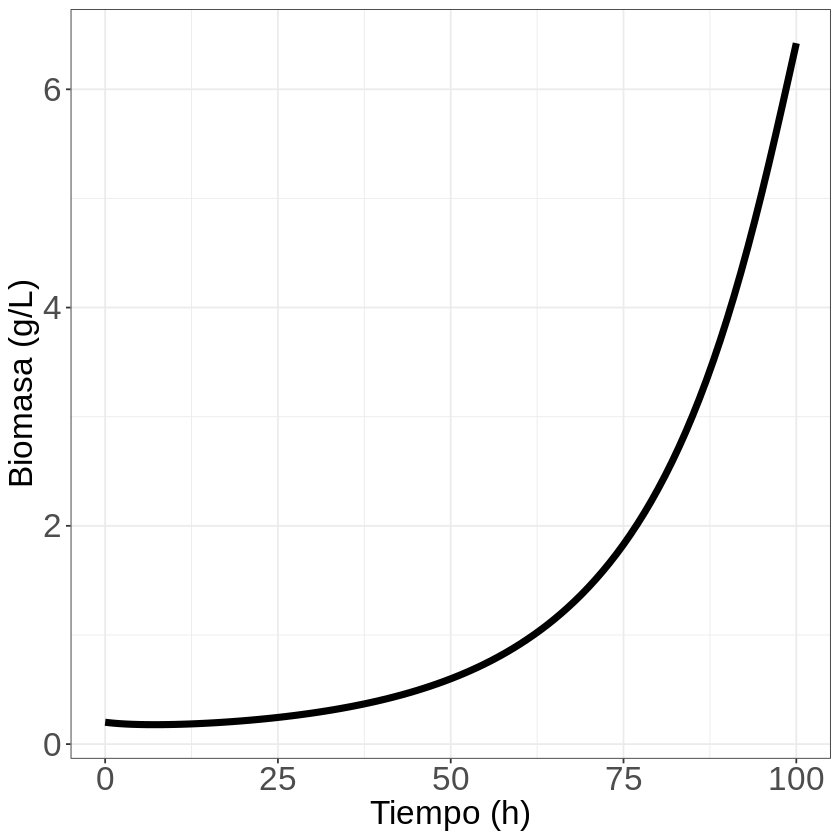

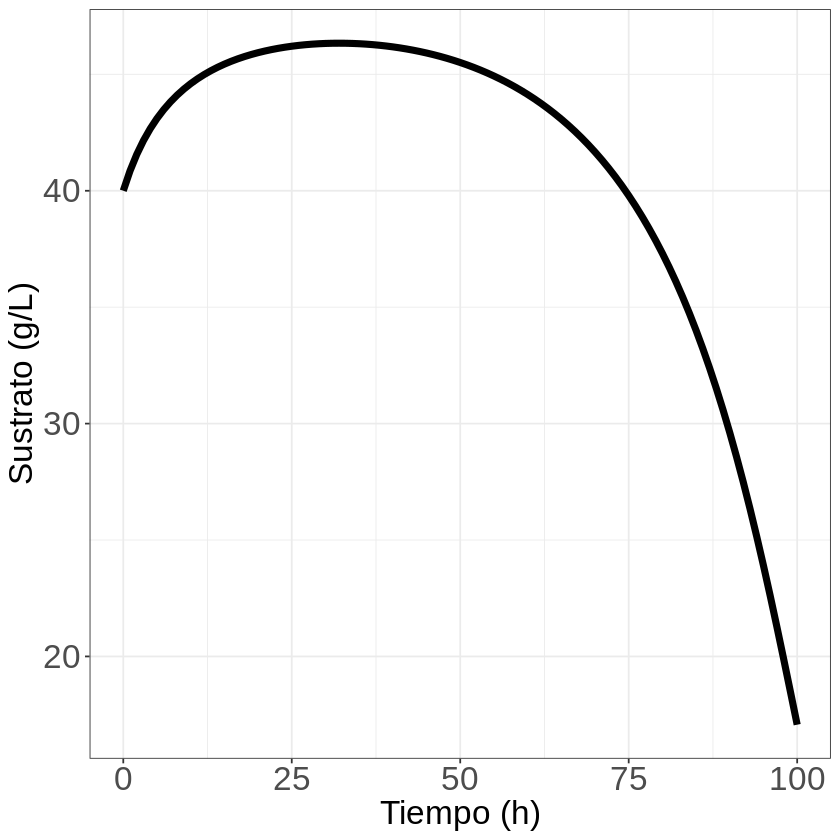

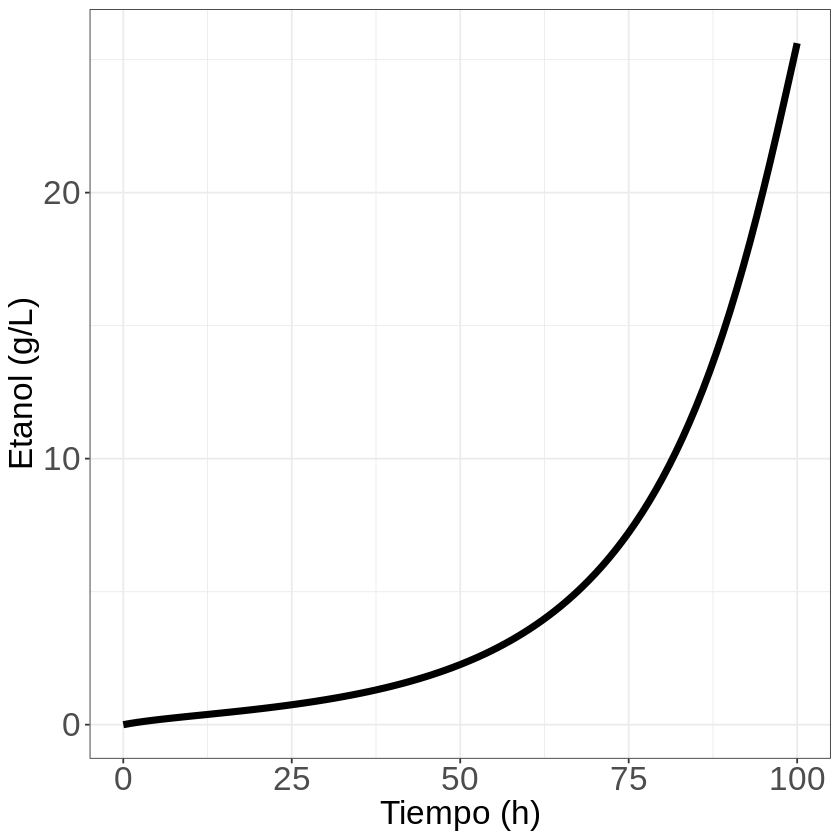

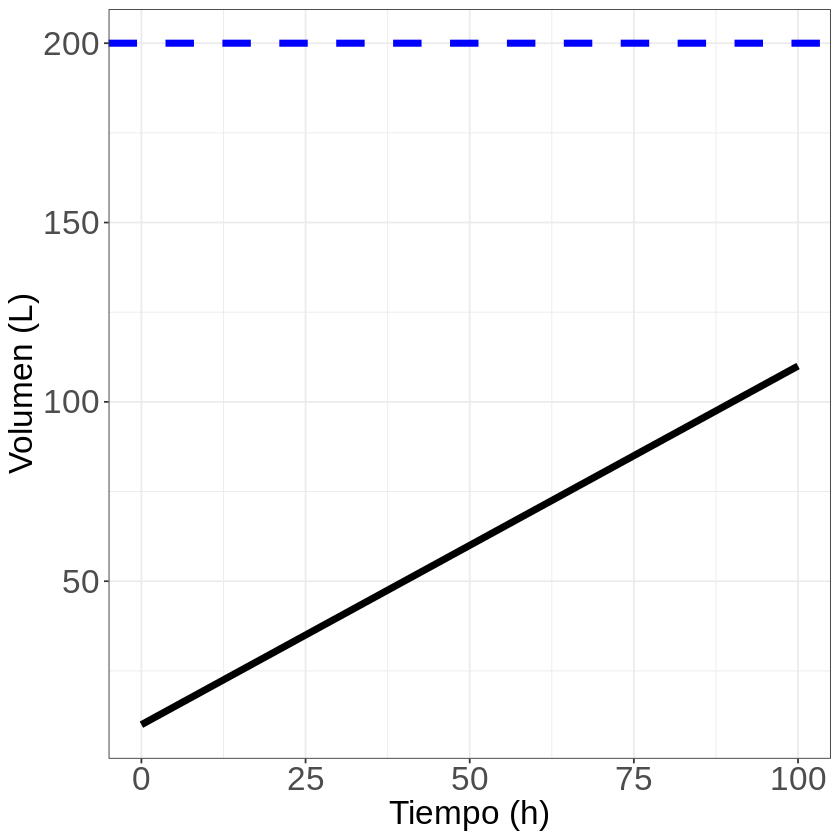

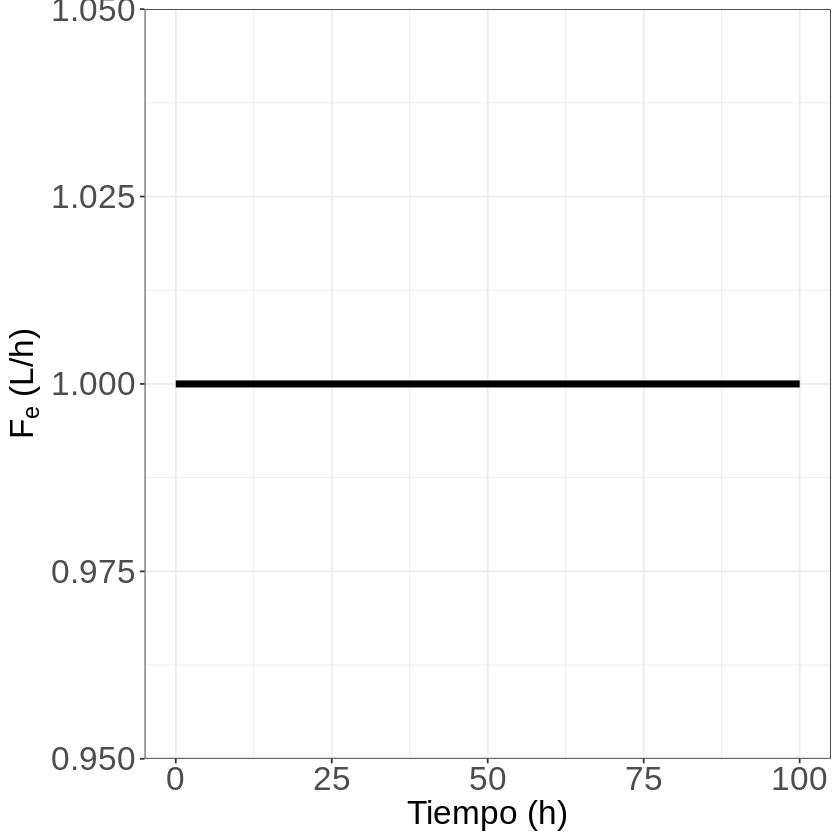

In [412]:
# graficar resultados 
plot_data(out)

In [414]:
#@title función para obtener la biomasa final (función a optimizar)
end_biomass <- function(times, state, parms, Fe) {

        # simular proceso
        out <- ode(func = model, y = s, times = times, 
        parms = parms, Fe = Fe)

        # última observación en la simulación
        out <- as.data.frame(out)
        m <- nrow(out)

        # valor de estado al final de la simulación
        end_V <- out$V[m]
        end_x <- out$x[m]
        
        end_mx <- end_V*end_x
        
        return(list(end_x = end_x, end_V = end_V, end_mx = end_mx))
}

In [415]:
end_biomass(times = times, state = s, parms = p, Fe = Fe)

$end_x
[1] 6.42231

$end_V
[1] 110

$end_mx
[1] 706.4541

In [416]:
#@title función para obtener la biomasa final para diferentes valores de Fe 
end_biomass2 <- function(times, state, parms, Fe) {
        
        # vectores para guardar los valores finales
        n <- length(Fin)
        end_x <- numeric(length = n)
        end_V <- numeric(length = n)
        end_mx <- numeric(length = n)
        # ciclo for para evaluar todos los valores en Fe
        for (i in 1:n) {
                
                # obtener valores finales final de mx
                out <- end_biomass(times = times,state = state,
                parms = parms, Fe = Fe[i])
                
                # guardar mx final para Fe[i]
                end_x[i] <- out$end_x
                end_V[i] <- out$end_V
                end_mx[i] <- out$end_mx
                
        }
        
        return(list(end_x = end_x, end_V = end_V, end_mx = end_mx))
}

In [417]:
Fe = seq(0,2,len = length(times))

end_biomass2(times = times, state = s, parms = p, Fe = Fe)

$end_x
  [1] 8.198170 8.404716 8.554238 8.667159 8.755125 8.825226 8.882001 8.928467
  [9] 8.966682 8.998078 9.023659 9.044124 9.059956 9.071472 9.078865 9.082234
 [17] 9.081595 9.076905 9.068081 9.054993 9.037487 9.015391 8.988519 8.956692
 [25] 8.919721 8.877441 8.829703 8.776391 8.717416 8.652764 8.582421 8.506463
 [33] 8.425010 8.338248 8.246419 8.149798 8.048791 7.943771 7.835155 7.723422
 [41] 7.609055 7.492546 7.374389 7.255065 7.135038 7.014745 6.894557 6.774958
 [49] 6.656172 6.538536 6.422310 6.307718 6.194948 6.084158 5.975472 5.868990
 [57] 5.764783 5.662863 5.563395 5.466260 5.371505 5.279121 5.189087 5.101375
 [65] 5.015948 4.932766 4.851784 4.772952 4.696219 4.621530 4.548832 4.478053
 [73] 4.409190 4.342132 4.276844 4.213271 4.151360 4.091059 4.032316 3.975082
 [81] 3.919308 3.864945 3.811950 3.760277 3.709884 3.660729 3.612770 3.565971
 [89] 3.520292 3.475699 3.432156 3.389629 3.348087 3.307497 3.267830 3.229058
 [97] 3.191151 3.154084 3.117829 3.082362

$end_V
  [1]  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44
 [19]  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80
 [37]  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114 116
 [55] 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152
 [73] 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188
 [91] 190 192 194 196 198 200 202 204 206 208

$end_mx
  [1]  81.9817 100.8566 119.7593 138.6745 157.5922 176.5045 195.4040 214.2832
  [9] 233.1337 251.9462 270.7098 289.4120 308.0385 326.5730 344.9969 363.2894
 [17] 381.4270 399.3838 417.1317 434.6396 451.8743 468.8003 485.3800 501.5747
 [25] 517.3438 532.6464 547.4416 561.6890 575.3495 588.3879 600.7695 612.4653
 [33] 623.4507 633.7069 643.2207 651.9839 660.0009 667.2768 673.8234 679.6612
 [41] 684.8149 689.3142 693.1925 696.4862 699.2337 701.4745 703.2448 704.5956
 [49] 705.5543 706.1619 706.4541 706.4644 706.2241 705.7623 705.1057 704.2788
 [57] 703.3036 702.1950 700.9878 699.6813 698.2957 696.8440 695.3377 693.7869
 [65] 692.2008 690.5873 688.9533 687.3051 685.6479 683.9865 682.3248 680.6640
 [73] 679.0152 677.3726 675.7413 674.1234 672.5204 670.9337 669.3645 667.8138
 [81] 666.2823 664.7706 663.2793 661.8088 660.3594 658.9312 657.5242 656.1386
 [89] 654.7744 653.4314 652.1096 650.8088 649.5288 648.2694 647.0304 645.8115
 [97] 644.6125 643.4330 642.2727 641.1314

# Optimización manteniendo $F_{in}$ constante

In [418]:
# valores de Fin que vamos a investigar
print(Fe)

  [1] 0.00 0.02 0.04 0.06 0.08 0.10 0.12 0.14 0.16 0.18 0.20 0.22 0.24 0.26 0.28
 [16] 0.30 0.32 0.34 0.36 0.38 0.40 0.42 0.44 0.46 0.48 0.50 0.52 0.54 0.56 0.58
 [31] 0.60 0.62 0.64 0.66 0.68 0.70 0.72 0.74 0.76 0.78 0.80 0.82 0.84 0.86 0.88
 [46] 0.90 0.92 0.94 0.96 0.98 1.00 1.02 1.04 1.06 1.08 1.10 1.12 1.14 1.16 1.18
 [61] 1.20 1.22 1.24 1.26 1.28 1.30 1.32 1.34 1.36 1.38 1.40 1.42 1.44 1.46 1.48
 [76] 1.50 1.52 1.54 1.56 1.58 1.60 1.62 1.64 1.66 1.68 1.70 1.72 1.74 1.76 1.78
 [91] 1.80 1.82 1.84 1.86 1.88 1.90 1.92 1.94 1.96 1.98 2.00


In [419]:
# @title función fitness para encontrar el flujo óptimo Fin de alimentación al biorreactor 
fitness1 <- function(x, times, state, parms) {
        # end_biomass() regresa el valor de la biomasa final
        # para el flujo de alimentación Fin 
        out <- end_biomass(times = times, 
        state = state,
        parms = parms, 
        Fe = x) # x es el flujo de alimentación Fin
        
        end_mx <- out$end_mx
        return(end_mx)
}

In [420]:
# probar la función con Fin = 1
fitness1(x = 1, times = times, state = s, parms = p)

[1] 706.4541

### Optimización de $F_e$ para *Isstchenkia terrícola*

In [421]:
# @title función para mostrar fitness
show_fitness <- function(times = times, state = s, parms = p, Fe = Fe){
    # obtener biomasa final para todos los Fin
    out <- end_biomass2(times = times, state = state, parms = parms, Fe = Fe)
    # mostrar función que se va a optimizar 
    par(mar = c(5,7,4,2) + 0.1)
    plot(Fin, out$end_mx, ylab = "Producción de biomasa (g)", xlab = expression(paste(F[e], " (L/h)")), 
        type = "l", col = 1, lwd = 3, cex.lab = 1.6, cex.axis = 1.5)
}

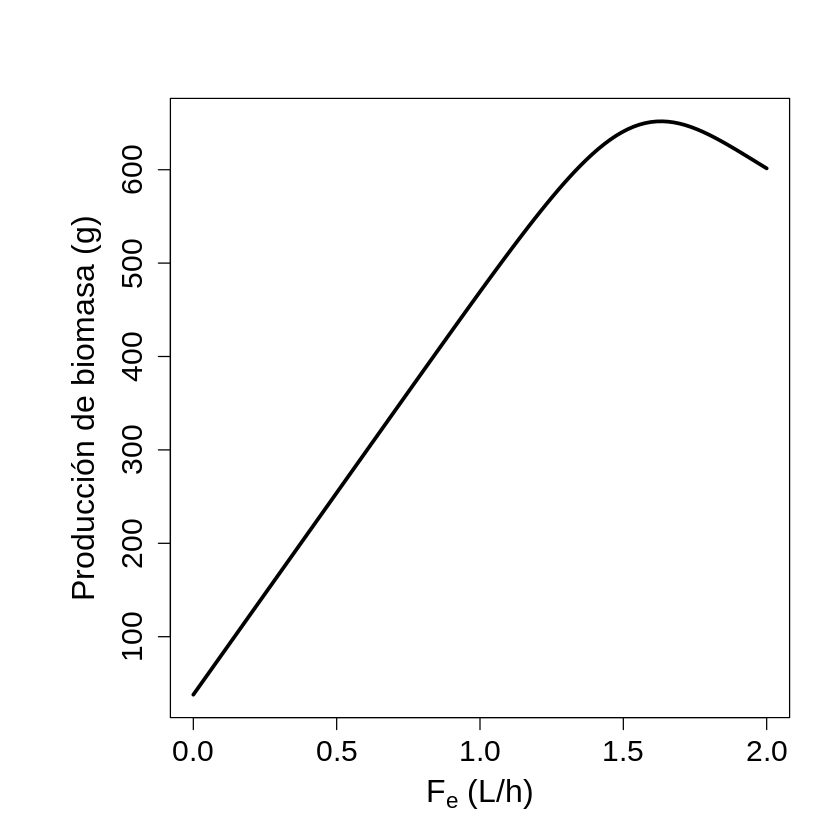

In [422]:
# mostrar función fitness evaluada para todos los Fin
show_fitness(times = times, state = s, parms = p_it, Fe = Fe)

In [139]:
#@title función para encontrar el flujo de alimentación óptimo
get_Fin_opt <- function(p, pop_size, generations) {
    time1 <- Sys.time()
    GA <- ga(type = "real-valued",
         fitness = fitness1,
         times= times,
         state = s,
         parms = p,
         lower = 0,
         upper = 2,
         maxiter = generations, 
         popSize = pop_size, 
         elitism = 2)
    time2 <- Sys.time()
    cat("tiempo de ejecución:",time2 - time1,"\n")
         return(GA)
}

In [238]:
#@title función para mostrar evolución del AG
show_GA_evol <- function(GA) {
    out <- plot(GA)
    show(
            ggplot(out) +
    geom_ribbon(aes(x = iter, ymin = median, ymax = max, 
                    colour = "mediana", fill = "mediana")) +
    geom_line(aes(x = iter, y = max, colour = "mejor"), lwd = 2) +
    geom_point(aes(x = iter, y = max, colour = "mejor"), cex = 2) +
    geom_line(aes(x = iter, y = mean, colour = "promedio"), lty = 2, lwd = 2) +
    geom_point(aes(x = iter, y = mean, colour = "promedio"), pch = 1, cex = 2) +
    xlab("Generación") +  ylab("Valor fitness (g)") +
    scale_colour_manual(breaks = c("mejor", "promedio", "mediana"),
                        values = c("green3", "dodgerblue3", adjustcolor("green3", alpha.f = 0.1))) +
    scale_fill_manual(breaks = "mediana",
                        values = adjustcolor("green3", alpha.f = 0.1)) +
    guides(fill = "none", 
            colour = guide_legend(override.aes = 
                                    list(fill = c(NA, NA, adjustcolor("green3", alpha.f = 0.1)),
                                        pch = c(19,1,NA)))) +
    theme_bw() +
    theme( 
        plot.title = element_text(size=25),
        axis.text = element_text(size=20),
        axis.title = element_text(size=20),
        legend.title = element_blank(),
        legend.text = element_text(size=20),
        legend.position = c(0.8, 0.50), 
        #legend.pos = "top",
        #legend.background = element_blank()
        legend.background = element_rect(fill=NA))
    )
}

In [423]:
#@title función para mostrar resultados de la optimización
show_results <- function(GA, parms) {
    # mostrar evolución del algoritmo
    show_GA_evol(GA)
    # valor Fin que genera la máxima producción de biomasa 
    cat("Fin_opt:", GA@solution," L/h\n")
    # maxima producción de biomasa que se obtiene
    cat("mx_opt:", GA@fitnessValue, "g\n")
    # mostrar resultados de la optimización
    show_fitness(times = times, state = s, parms = parms, Fe = Fe)
    abline(v = GA@solution, col="red", lwd = 3, lty = 2)
    abline(v = c(0,2), col="blue", lwd = 3, lty = 3)
    # simular con perfil óptimo
    out_opt <- ode(func = model, y = s, times = times,
     parms = parms, Fe = GA@solution)
    out_opt <- as.data.frame(out_opt)
    return(out_opt)
}

In [293]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_it_const <- get_Fin_opt(p_it, pop_size = pop_size_const, generations = generation_const)

tiempo de ejecución: 0.7245963 


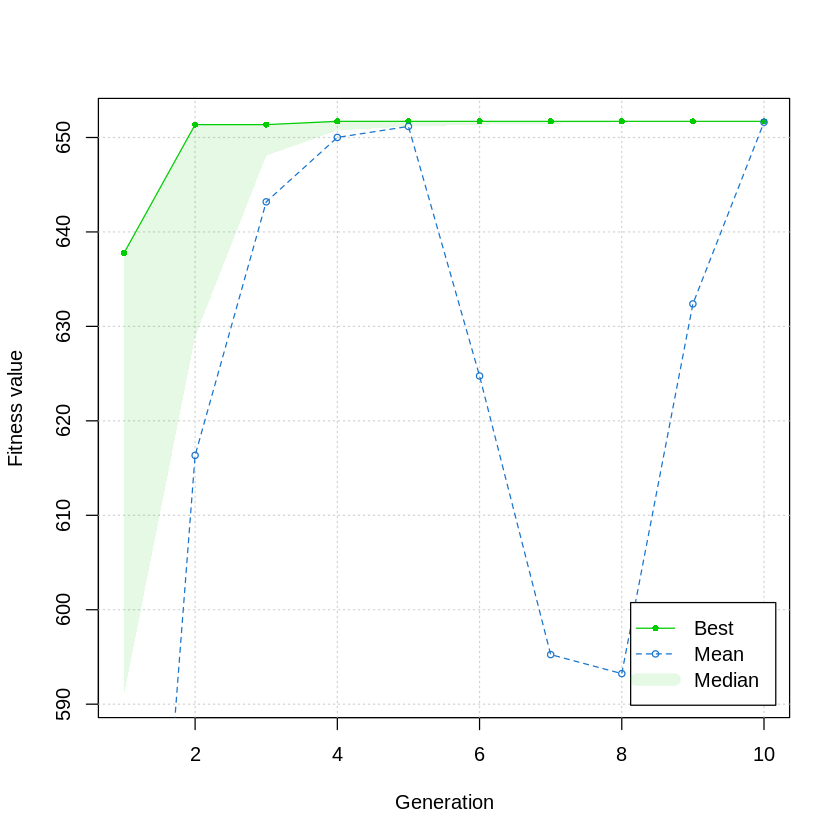

Fin_opt: 1.62926  L/h
mx_opt: 651.7111 g


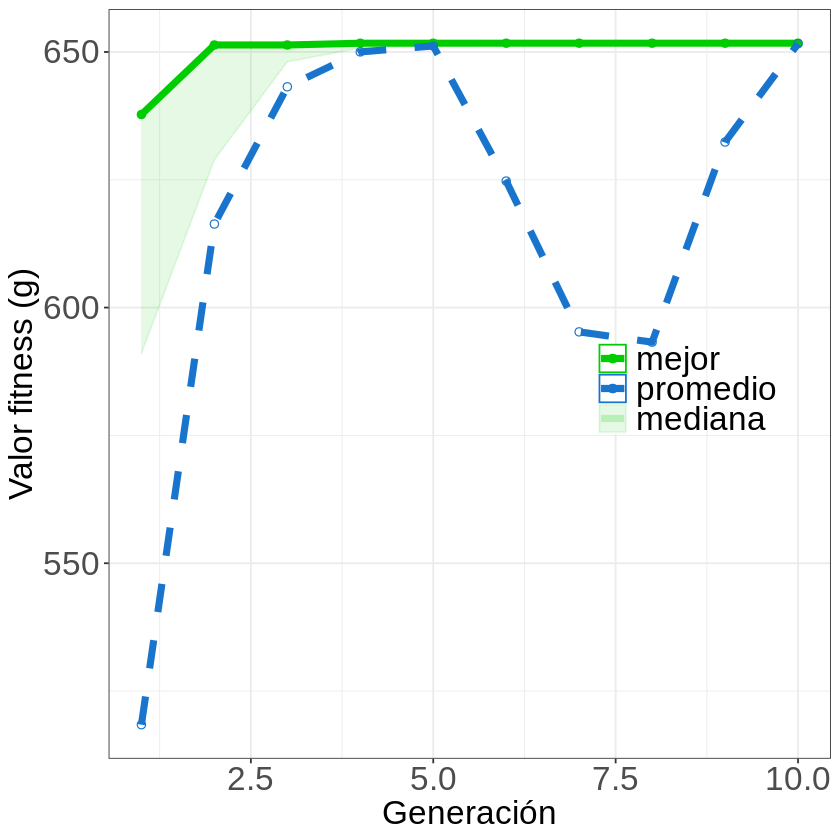

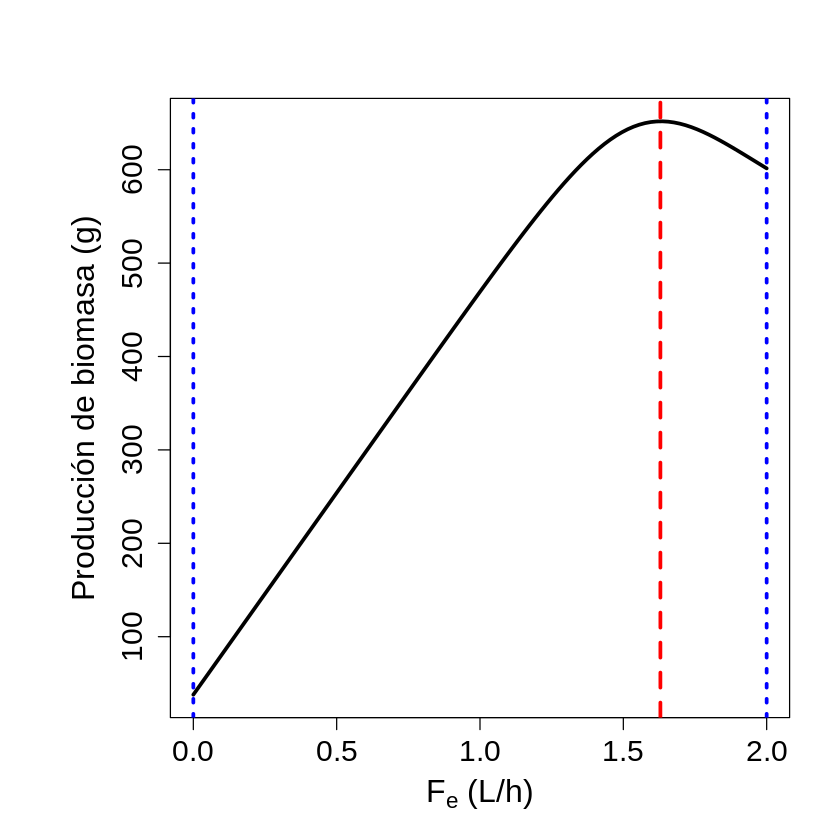

In [424]:
out_it_opt_const <- show_results(GA_it_const, p = p_it)

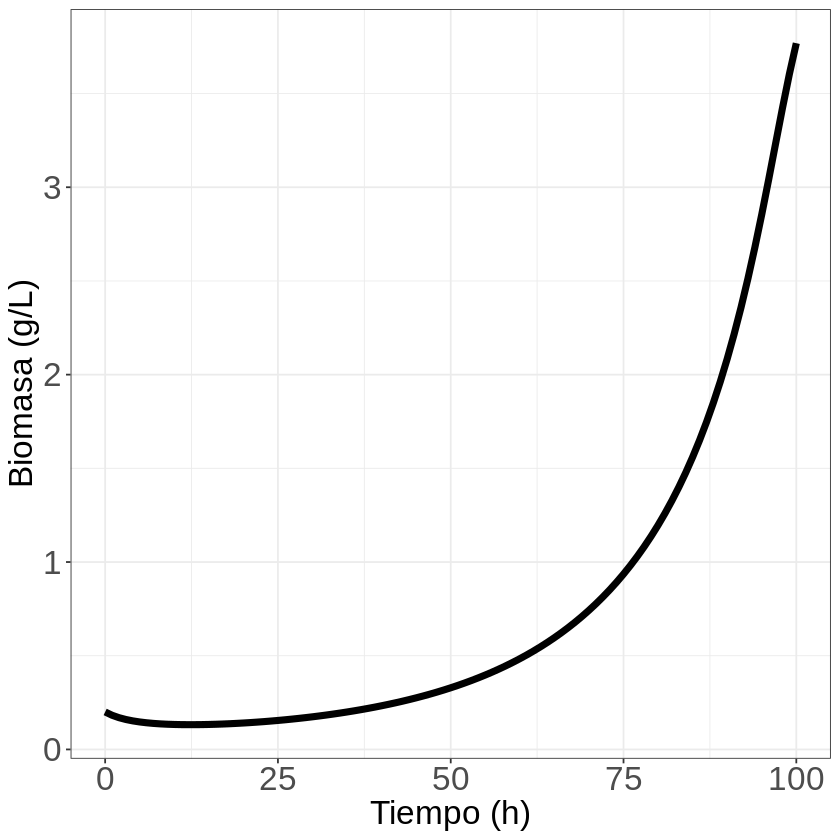

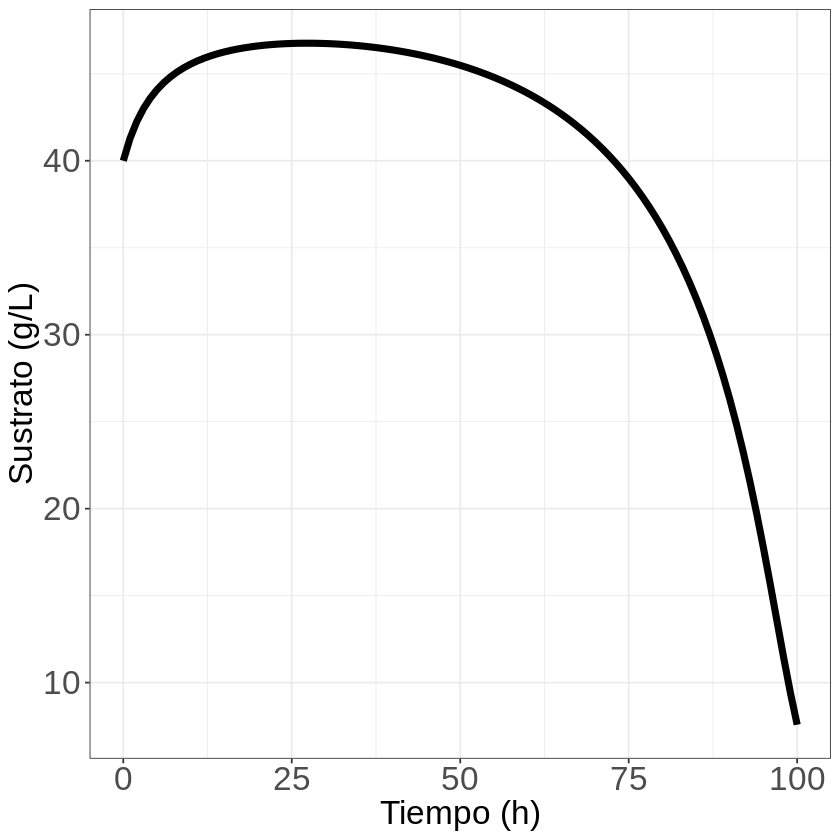

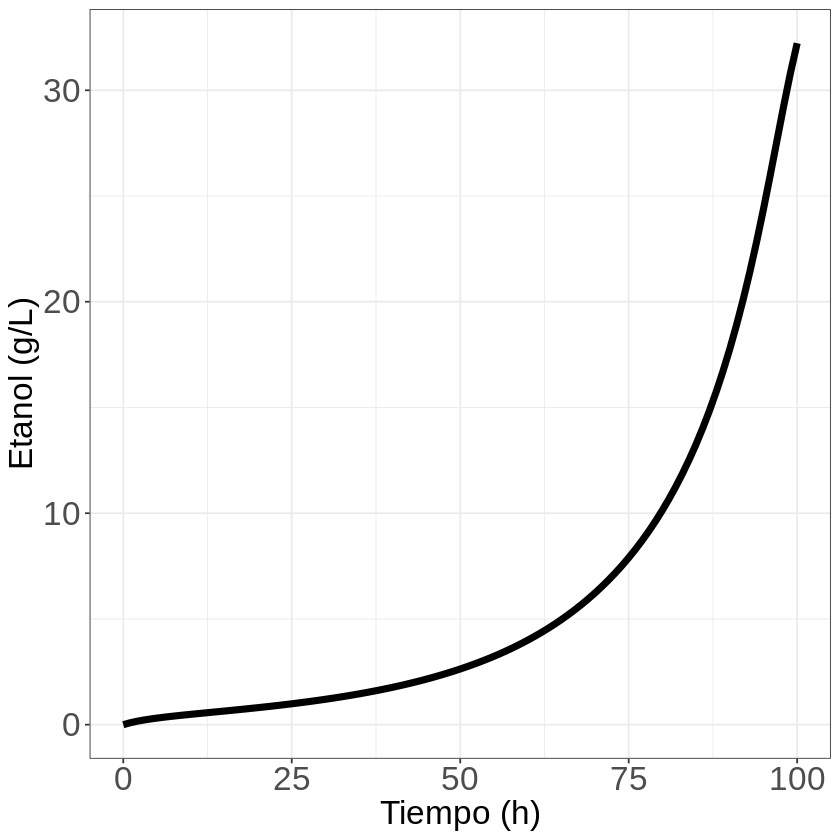

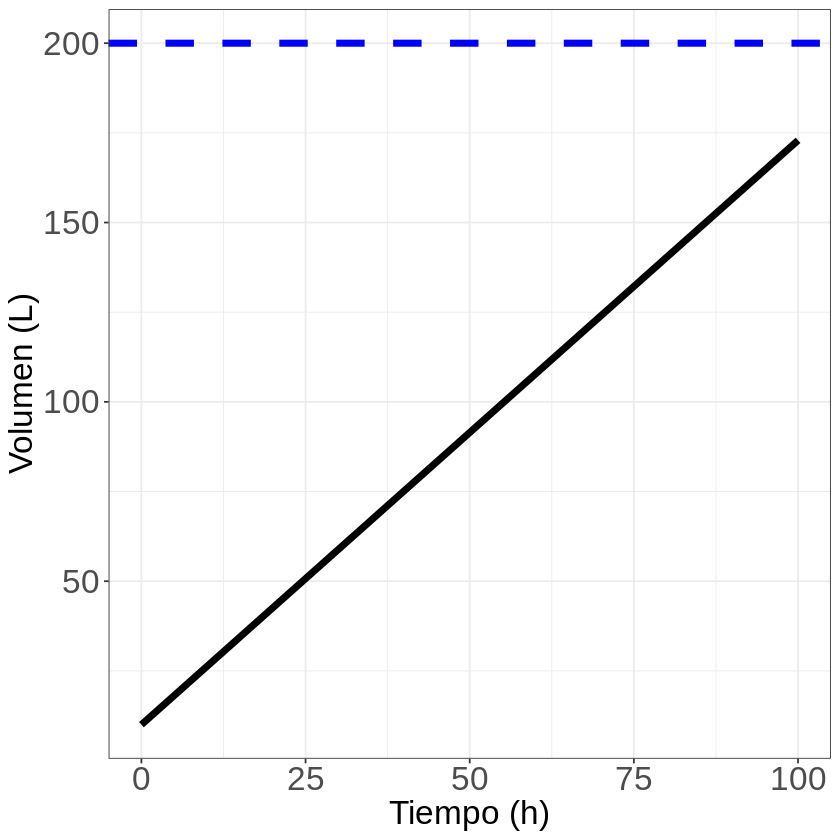

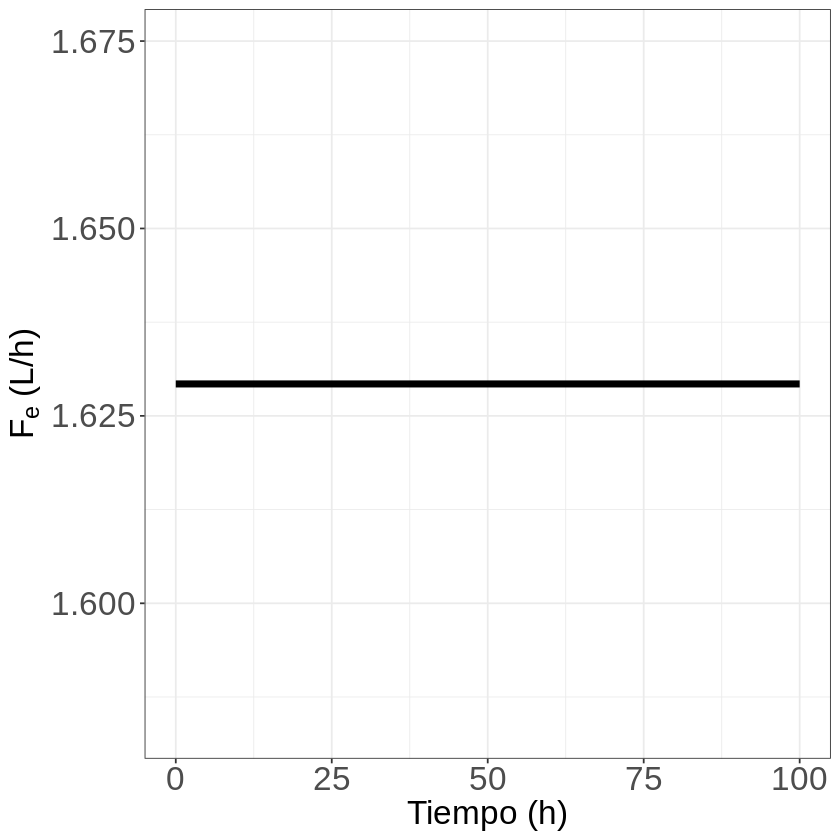

In [370]:
plot_data(out_it_opt_const)

### Optimización de Fin para *Kluyveromyces marxianus*

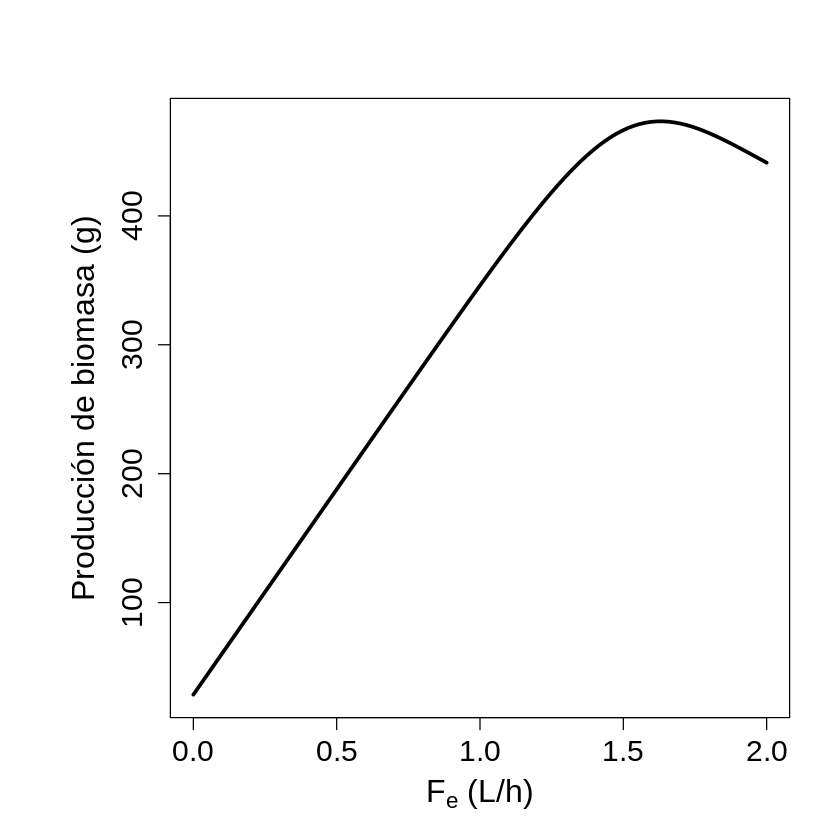

In [425]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_km, Fe = Fe)

tiempo de ejecución: 0.9136813 


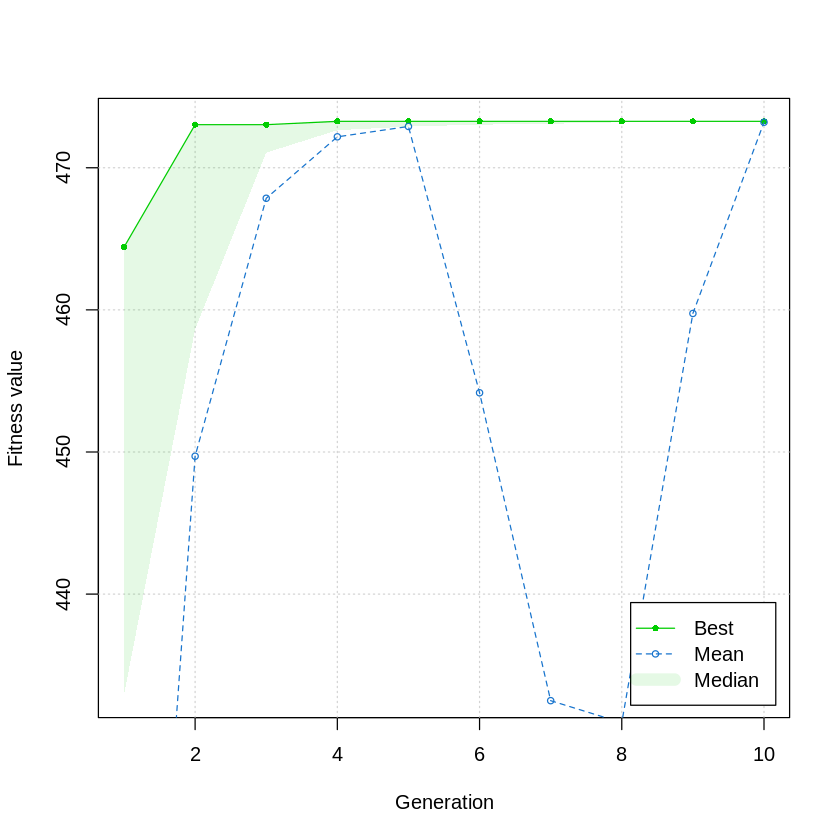

Fin_opt: 1.62926  L/h
mx_opt: 473.2654 g


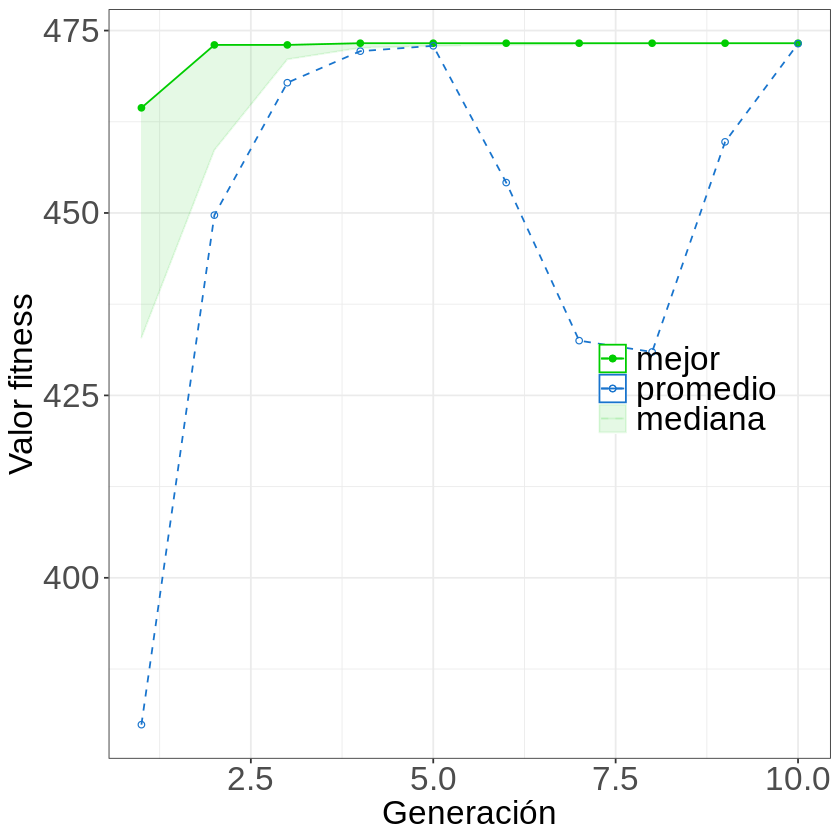

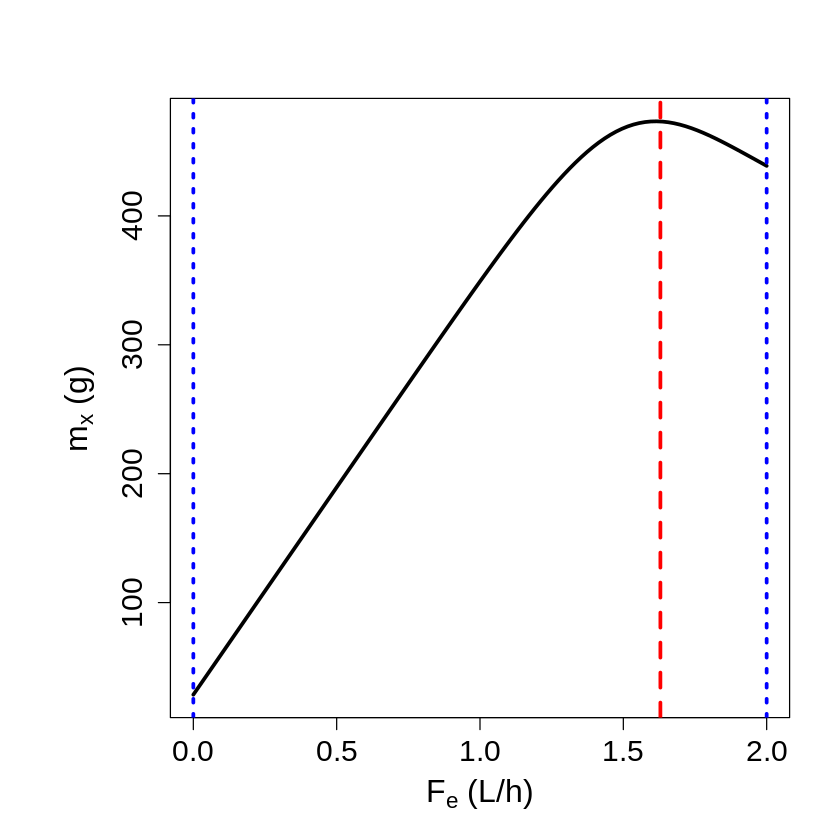

In [223]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_km_const <- get_Fin_opt(p_km, pop_size = pop_size_const, generations = generation_const)

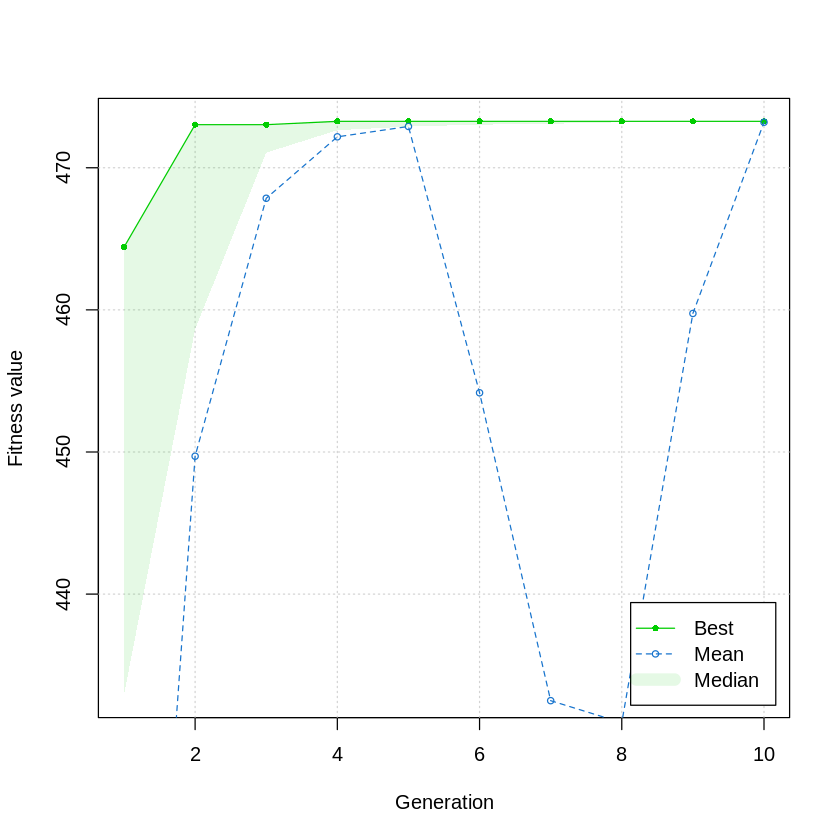

Fin_opt: 1.62926  L/h
mx_opt: 473.2654 g


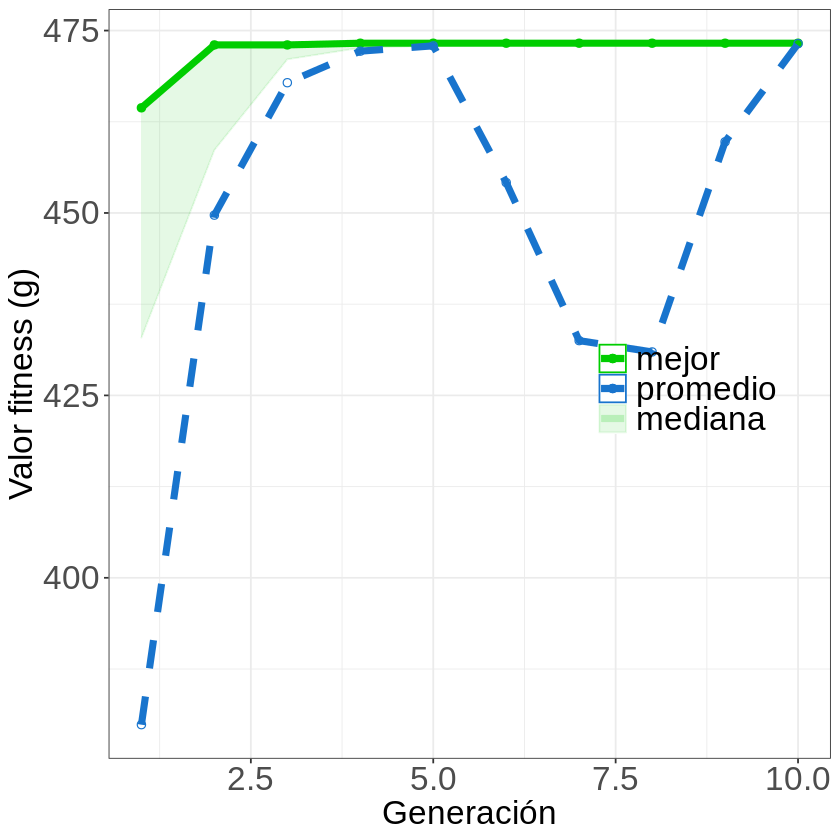

time V        s         x        p        Fe     
96   95  164.7797 17.487803 2.132219 20.25203 1.62926
97   96  166.4090 15.634763 2.255628 21.43202 1.62926
98   97  168.0382 13.745800 2.381419 22.63475 1.62926
99   98  169.6675 11.870445 2.506300 23.82877 1.62926
100  99  171.2968 10.070320 2.626177 24.97496 1.62926
101 100  172.9260  8.409266 2.736808 26.03281 1.62926

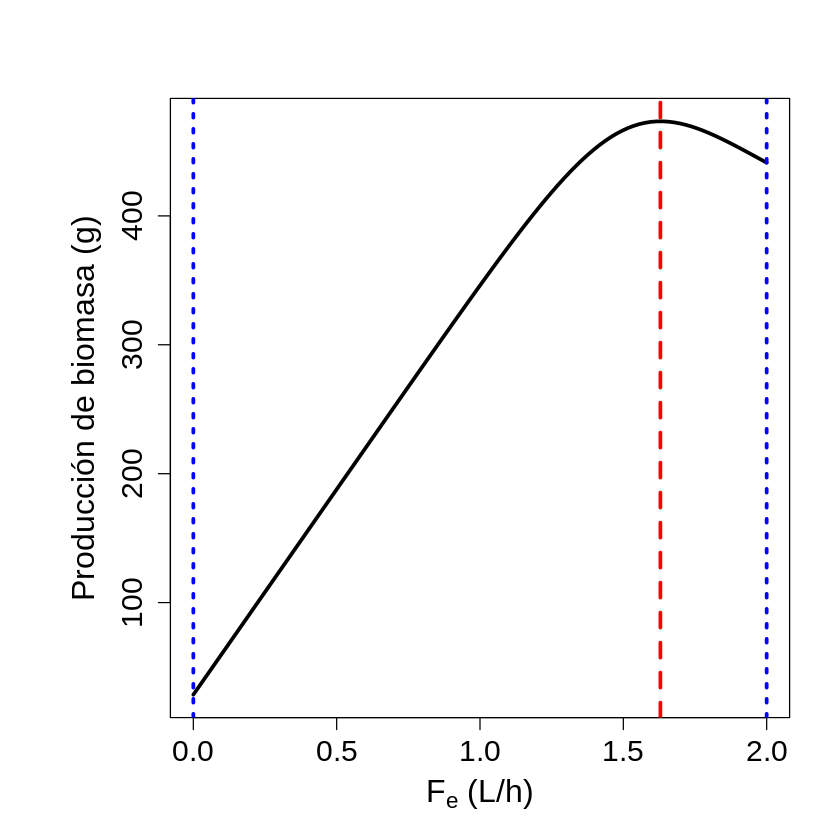

In [426]:
out_km_opt_const <- show_results(GA_km_const, p = p_km)
tail(out_km_opt_const)

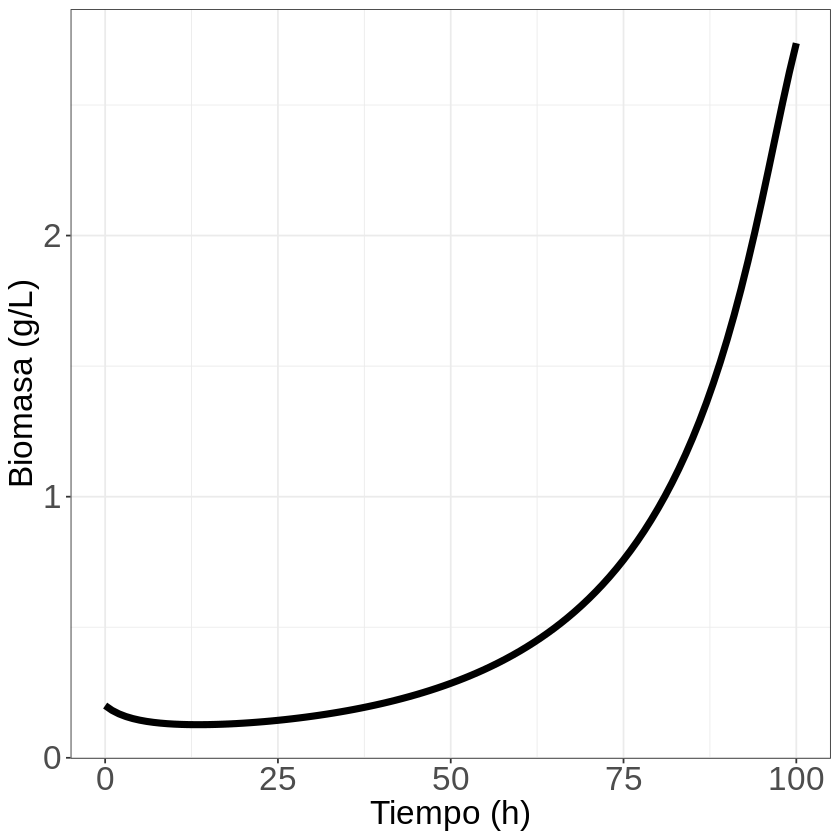

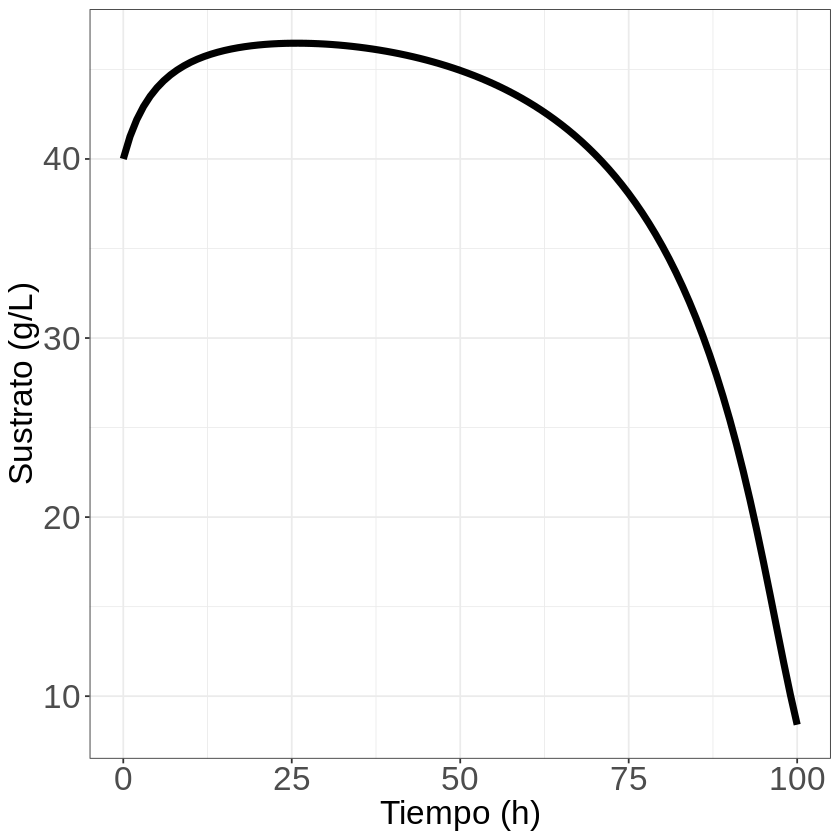

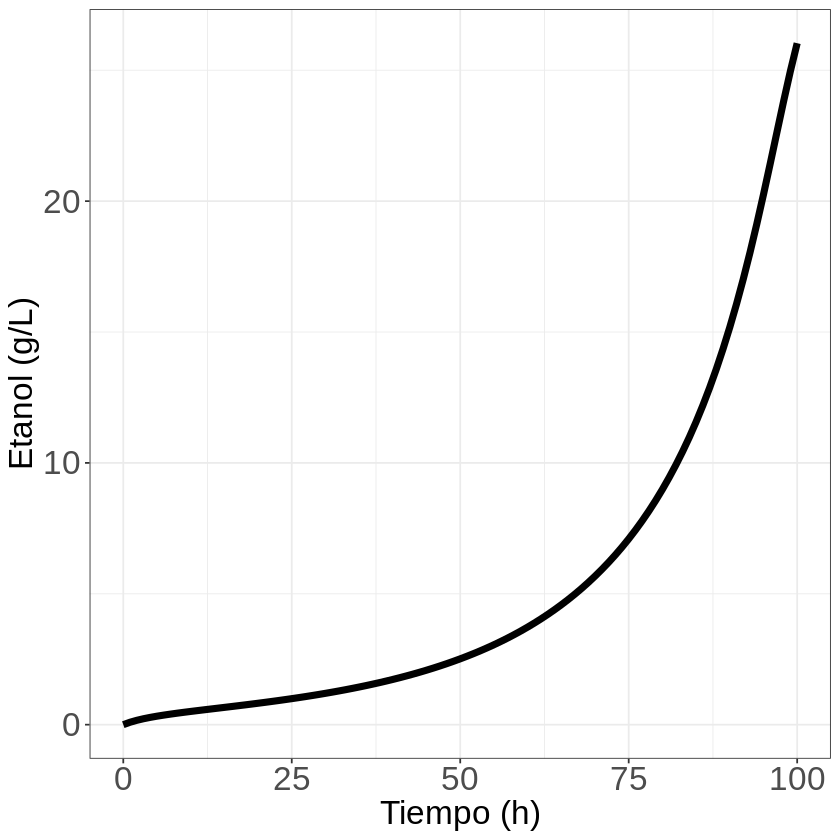

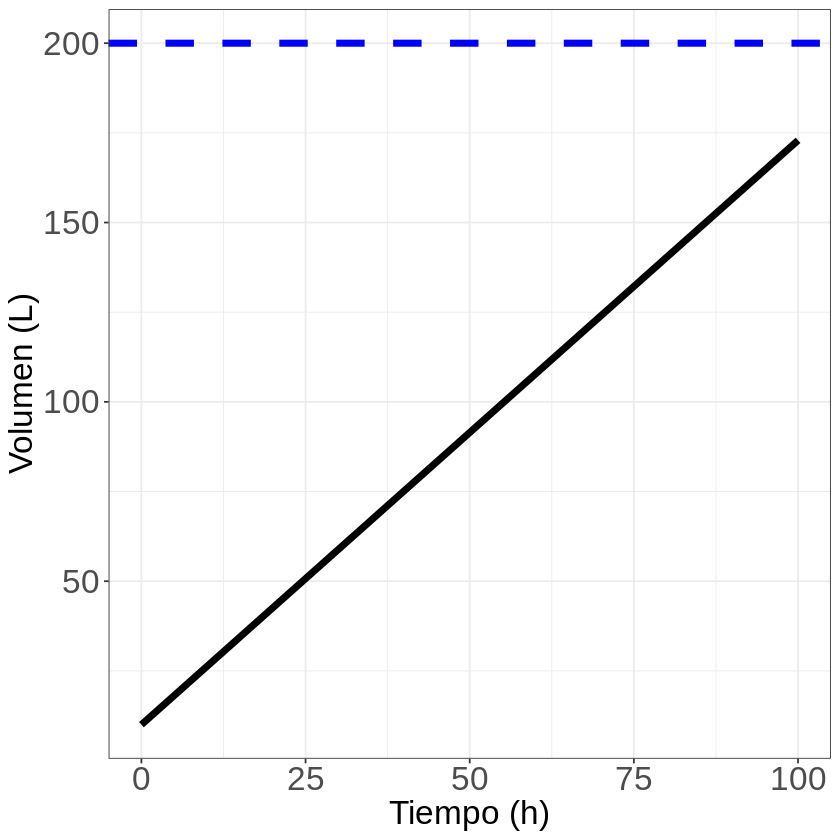

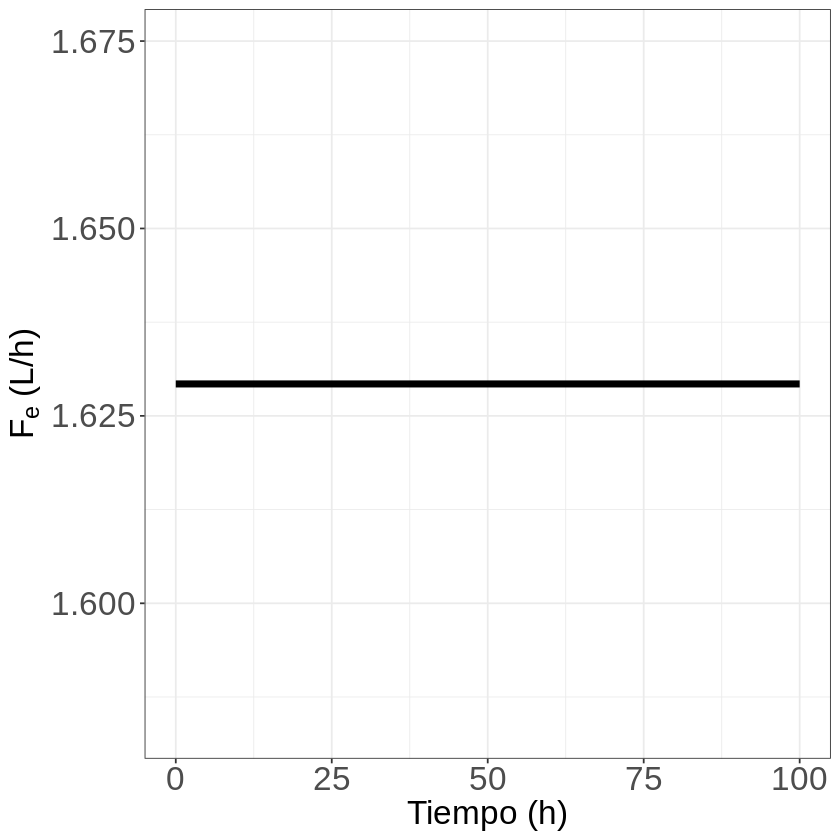

In [372]:
plot_data(out_km_opt_const)

### Optimización de Fin para *Pichia kluyveri*

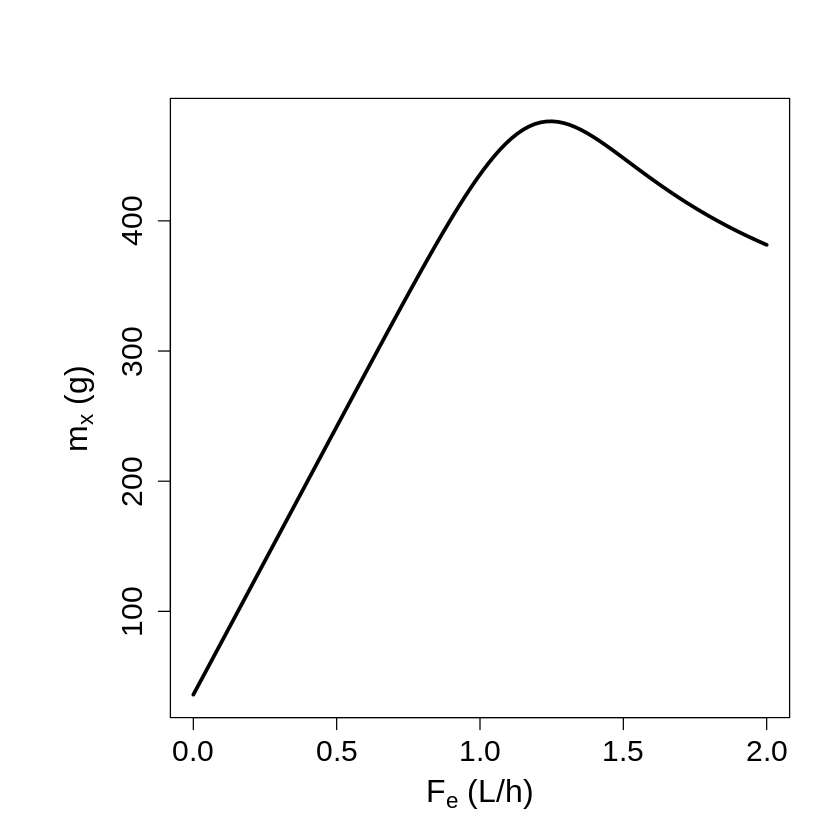

In [25]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_pk, Fe = Fe)

tiempo de ejecución: 0.8852901 


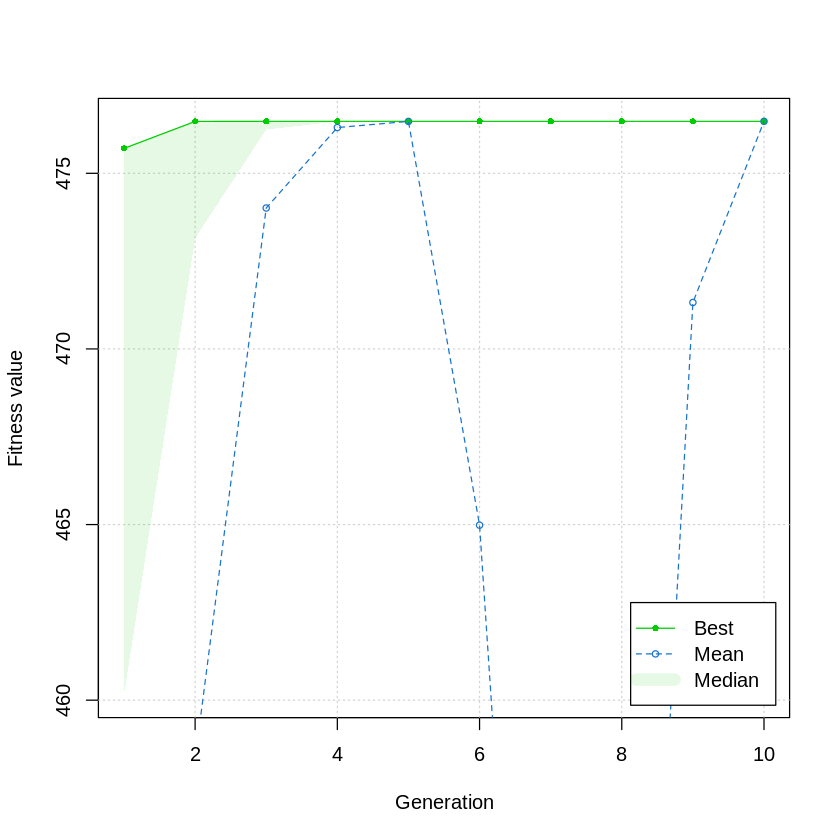

Fin_opt: 1.249466  L/h
mx_opt: 476.4802 g


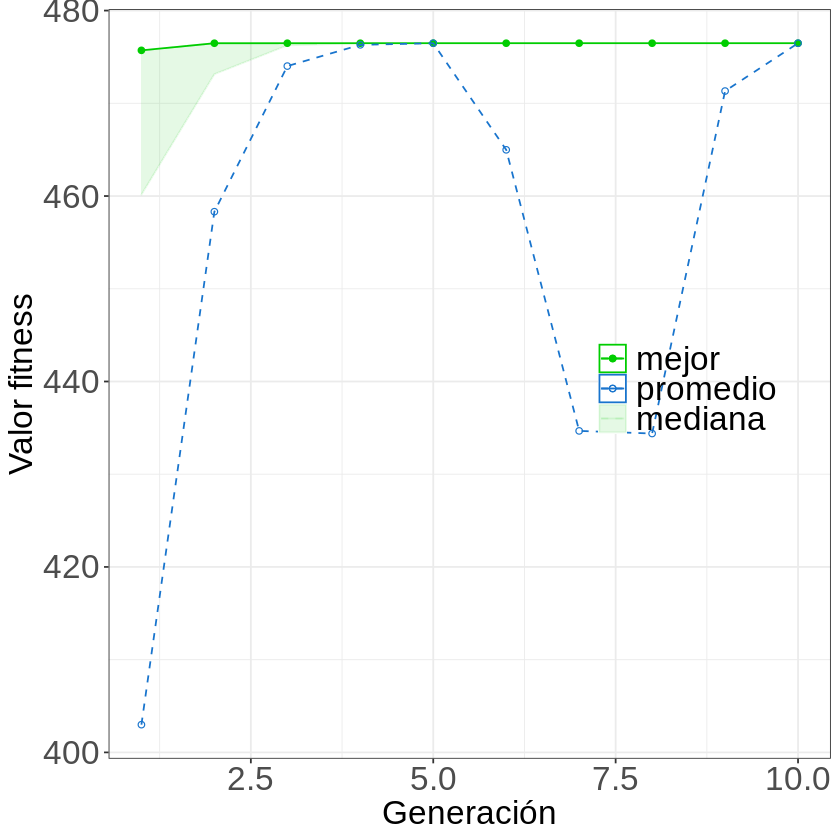

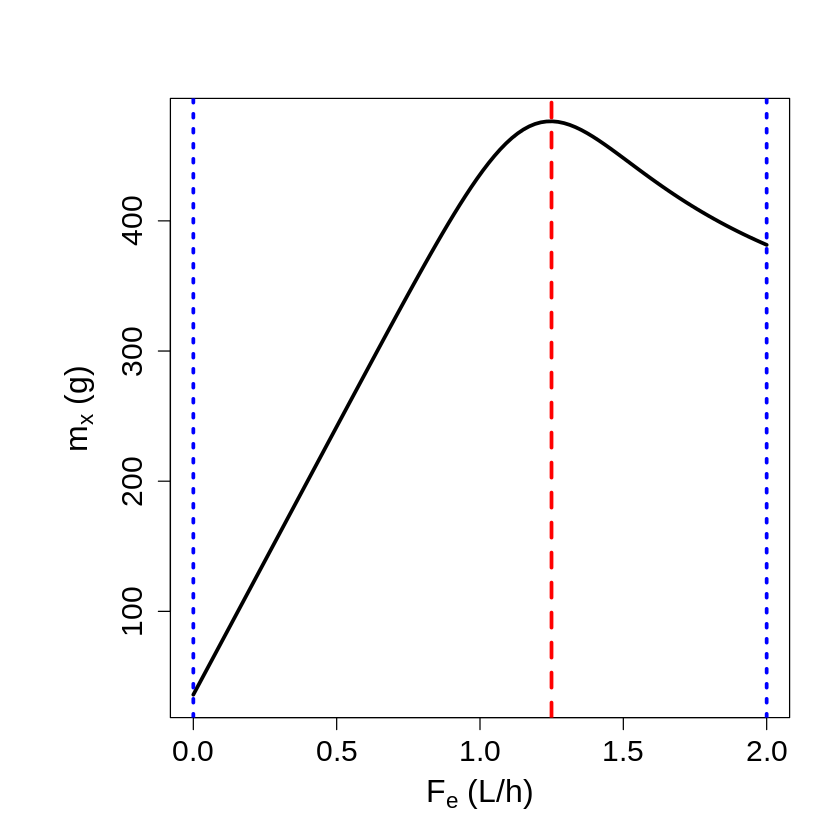

In [224]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_pk_const <- get_Fin_opt(p_pk, pop_size = pop_size_const, generations = generation_const)

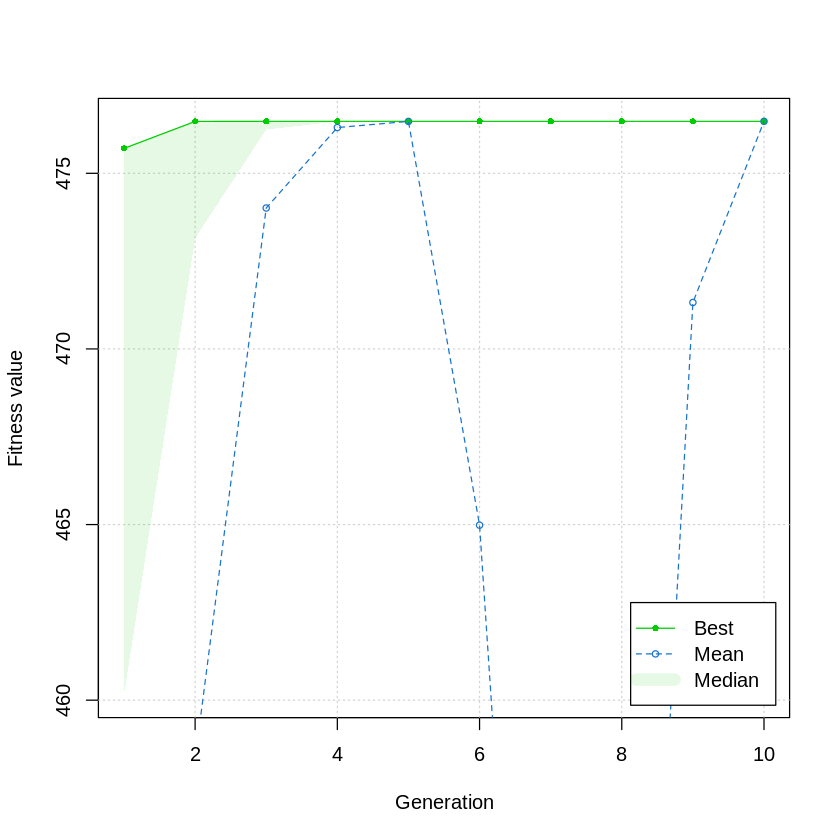

Fin_opt: 1.249466  L/h
mx_opt: 476.4802 g


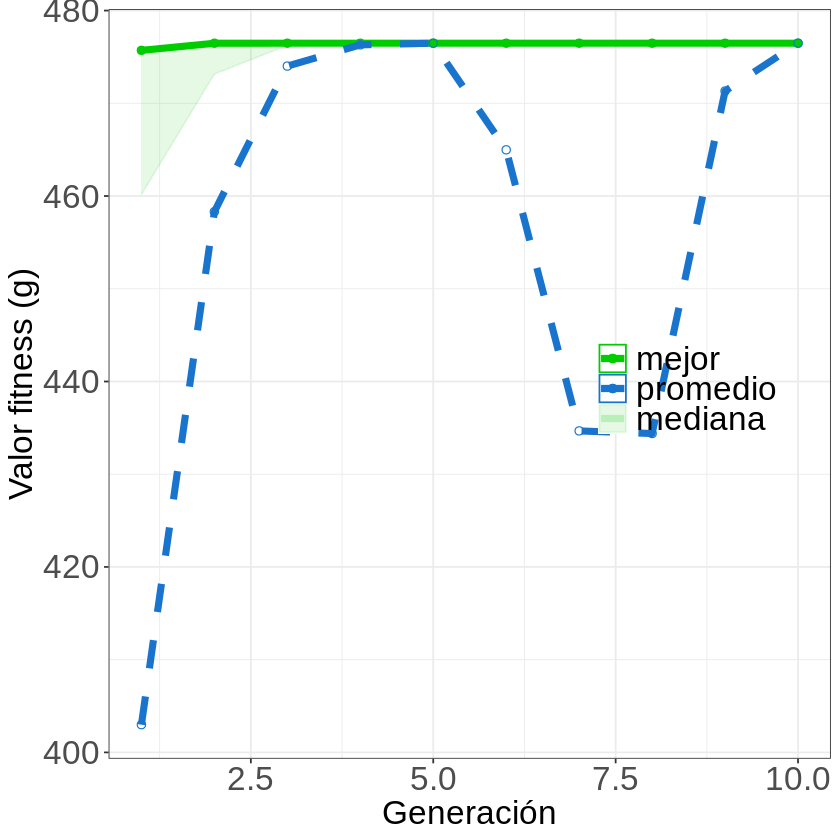

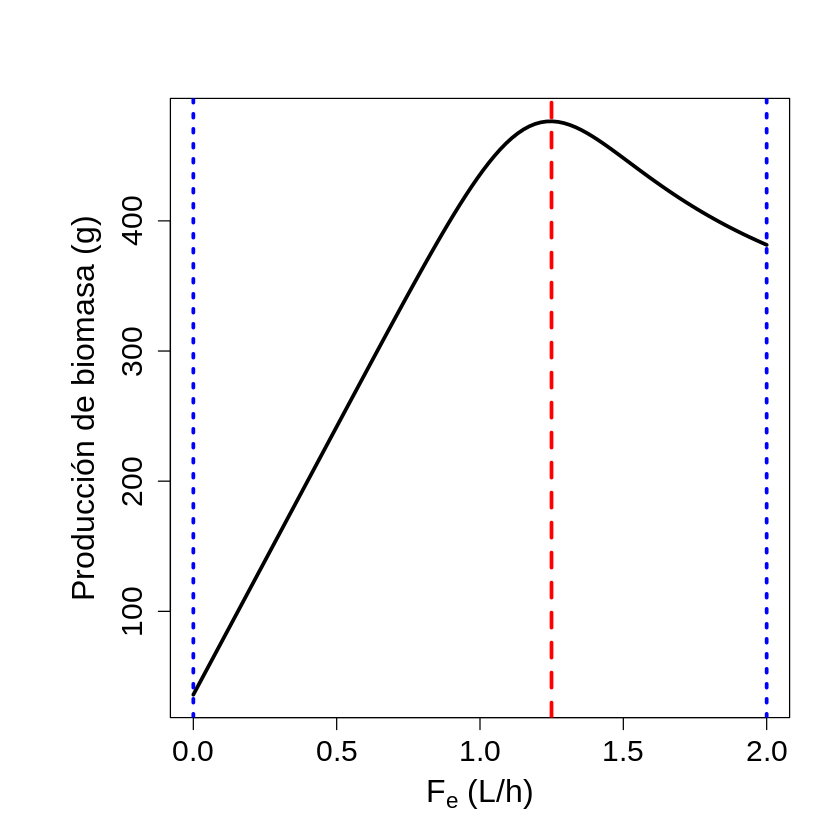

In [373]:
out_pk_opt_const <- show_results(GA_pk_const, p = p_pk)

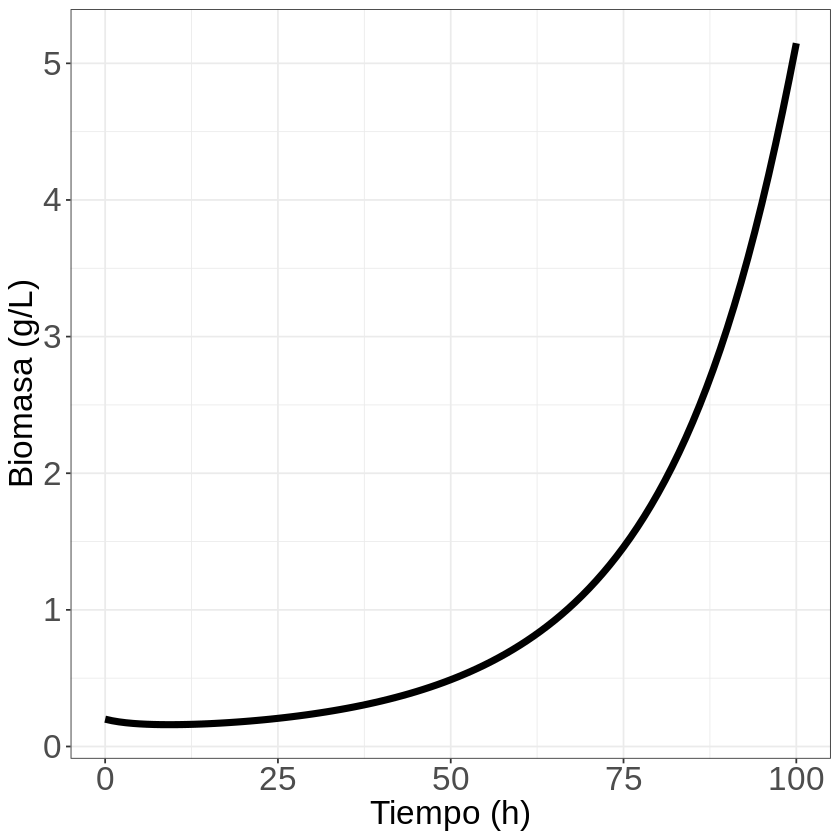

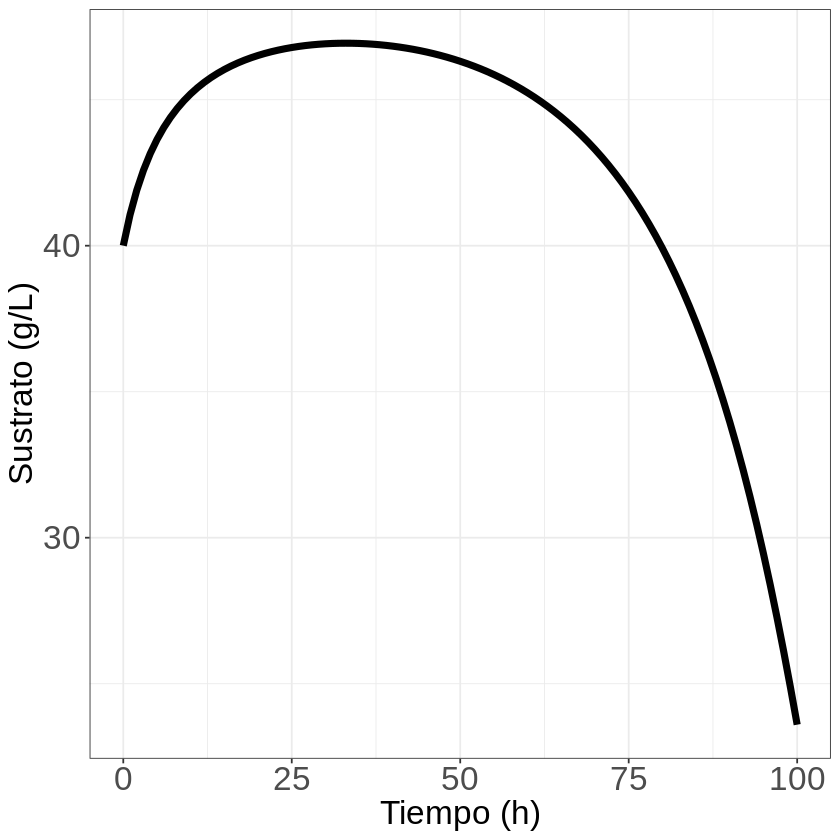

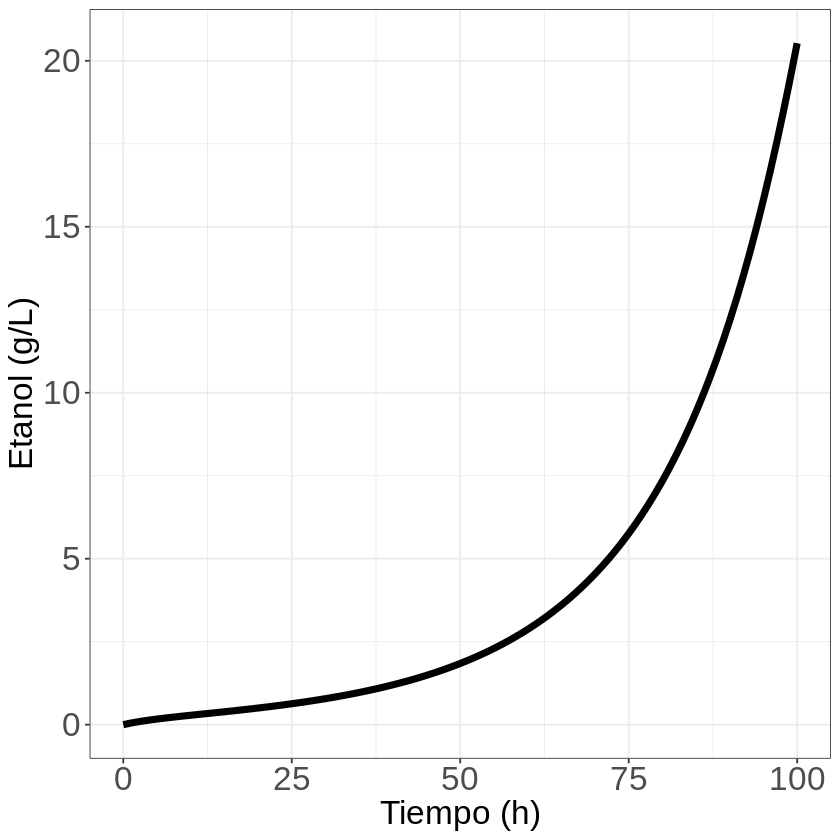

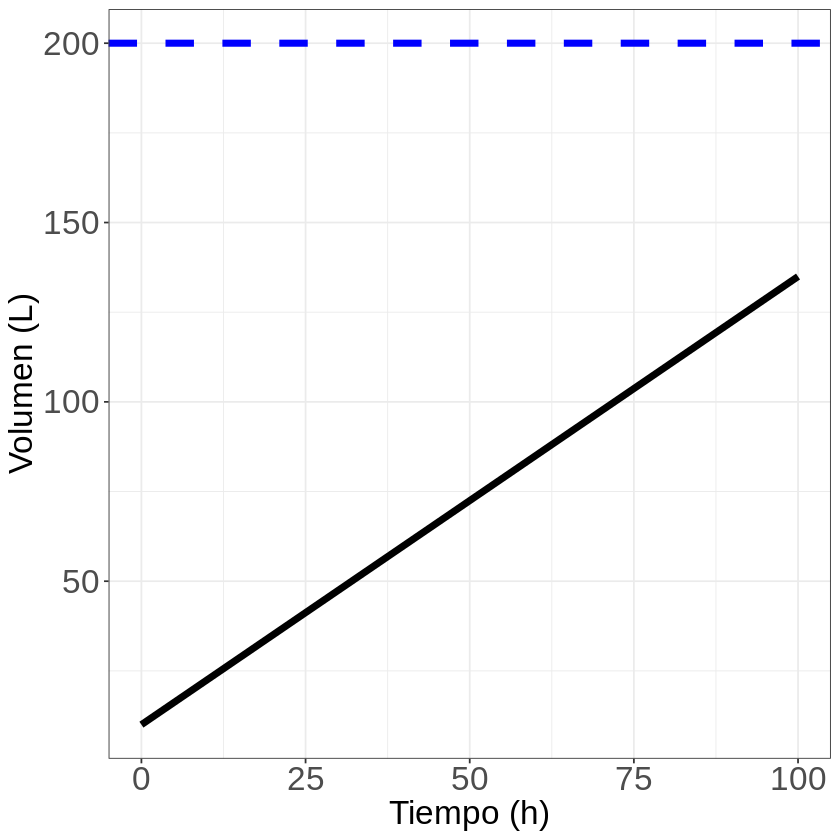

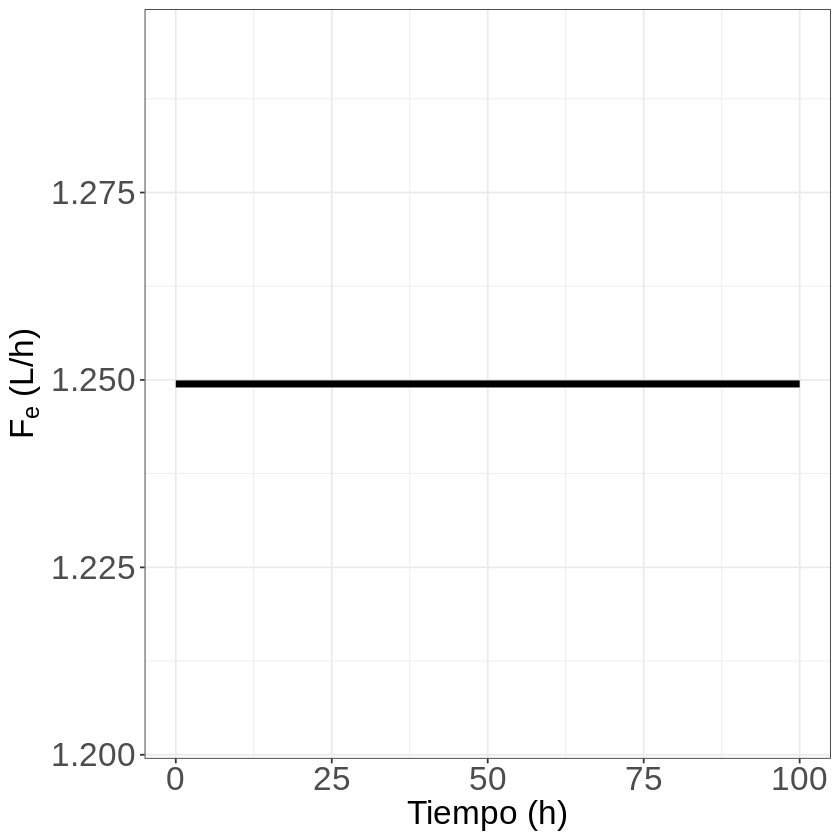

In [356]:
plot_data(out_pk_opt_const)

### Optimización de Fin para *Zygosaccharomyces bailii*

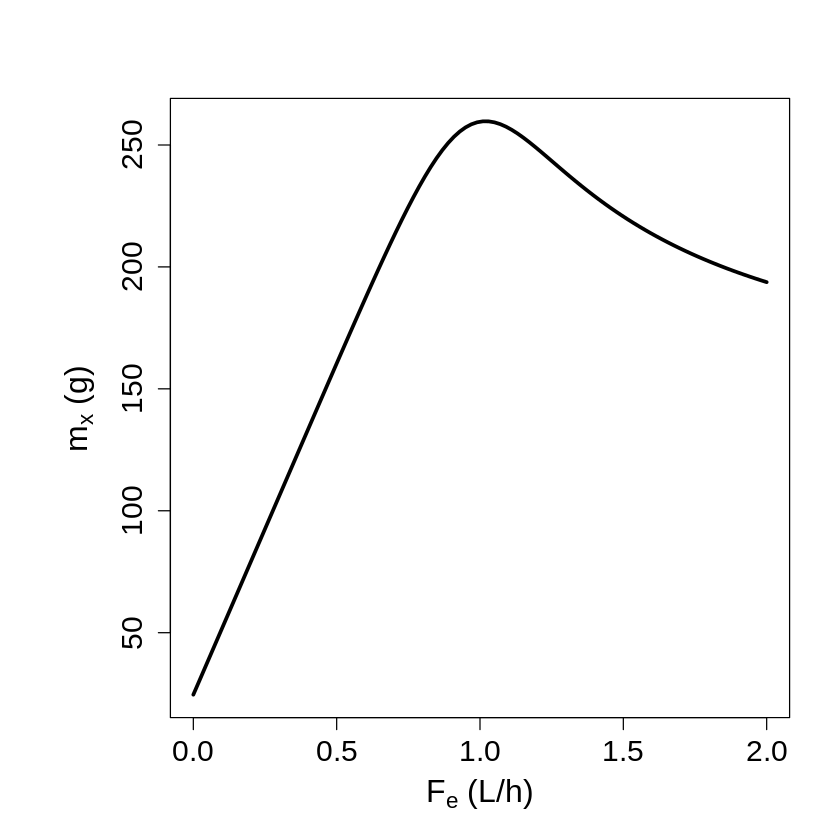

In [27]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_zb, Fe = Fe)

tiempo de ejecución: 0.6987343 


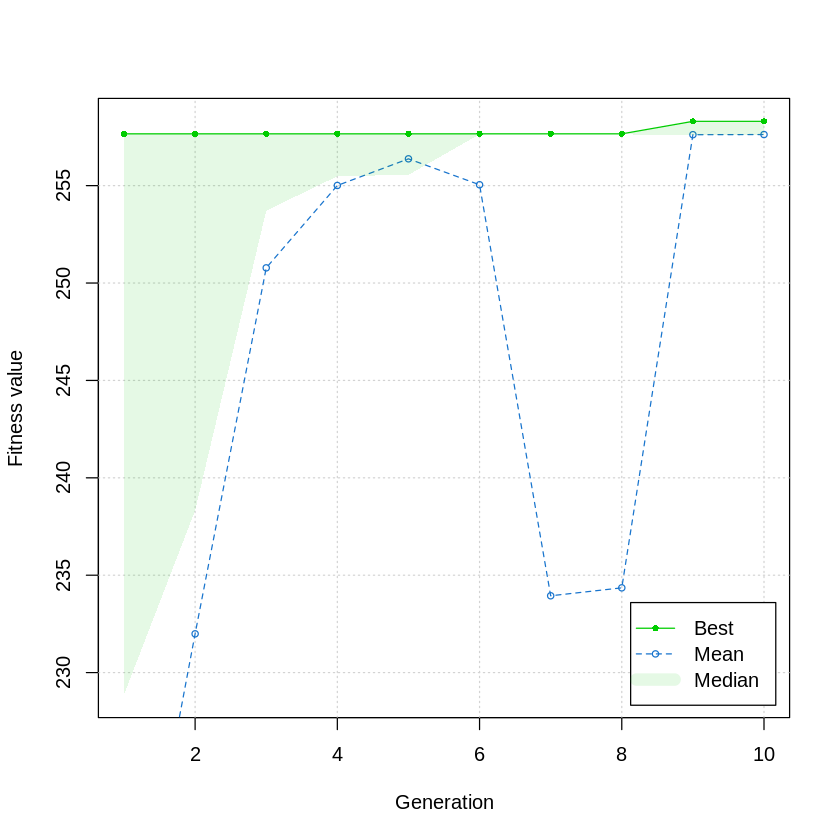

Fin_opt: 0.9663353  L/h
mx_opt: 258.3015 g


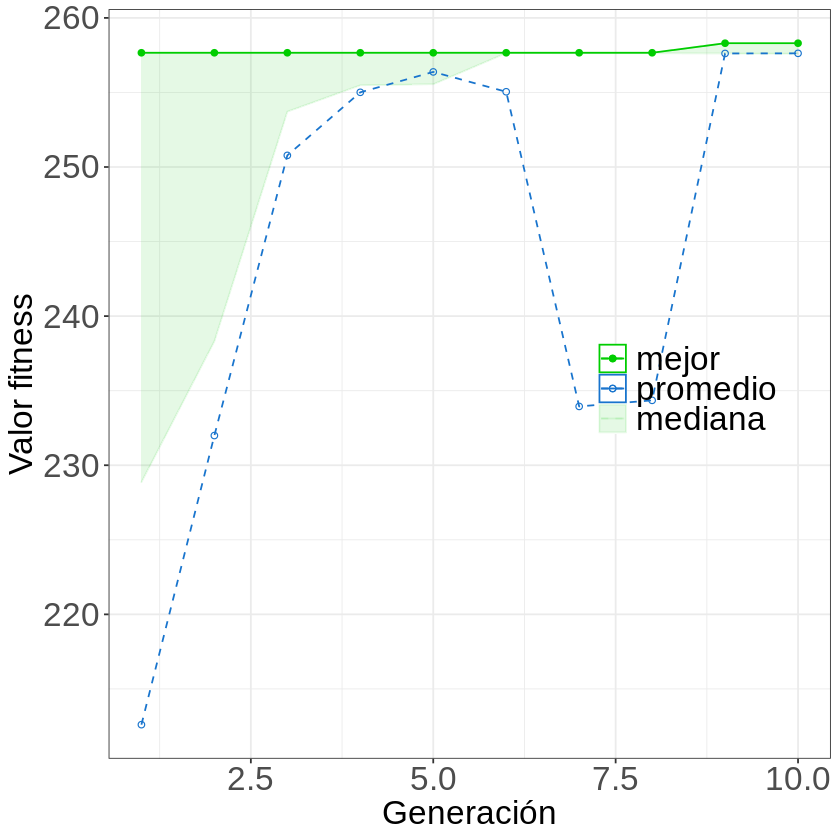

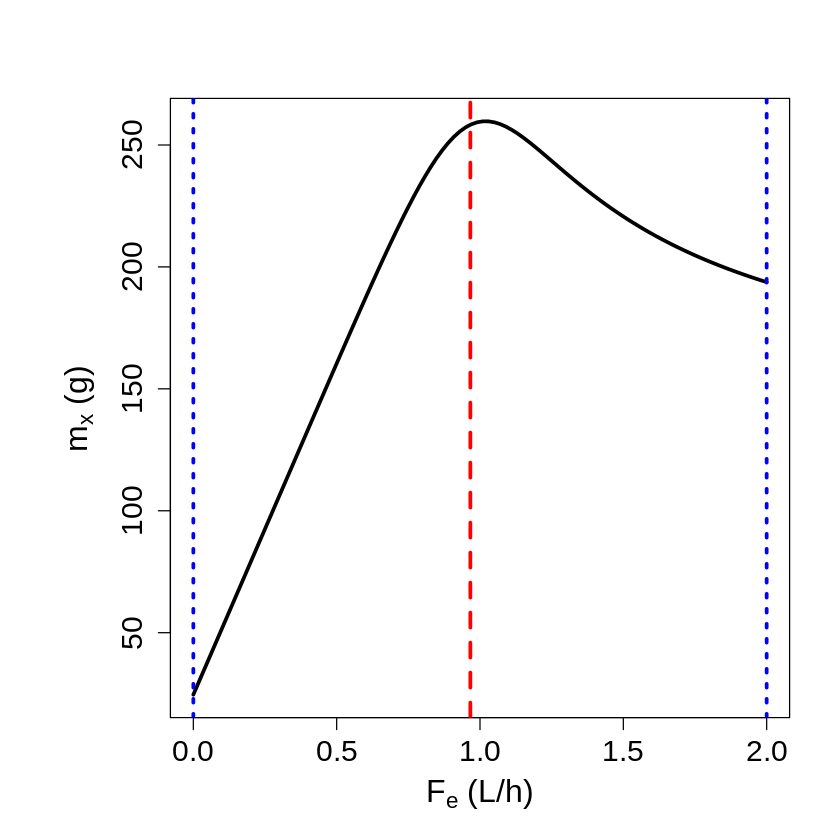

In [225]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_zb_const <- get_Fin_opt(p_zb, pop_size = pop_size_const, generations = generation_const)

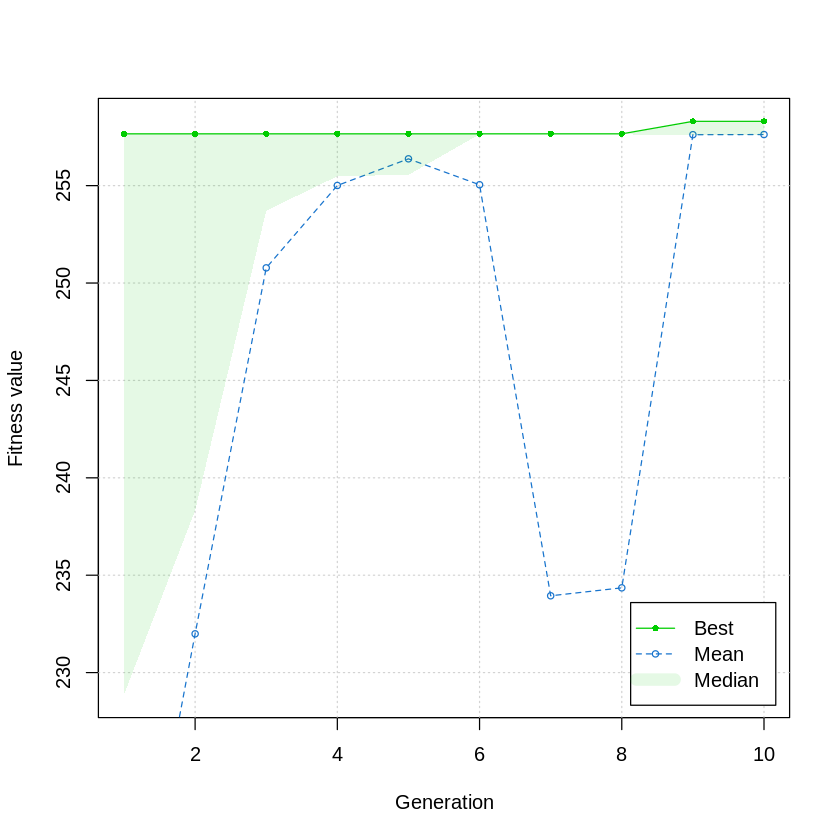

Fin_opt: 0.9663353  L/h
mx_opt: 258.3015 g


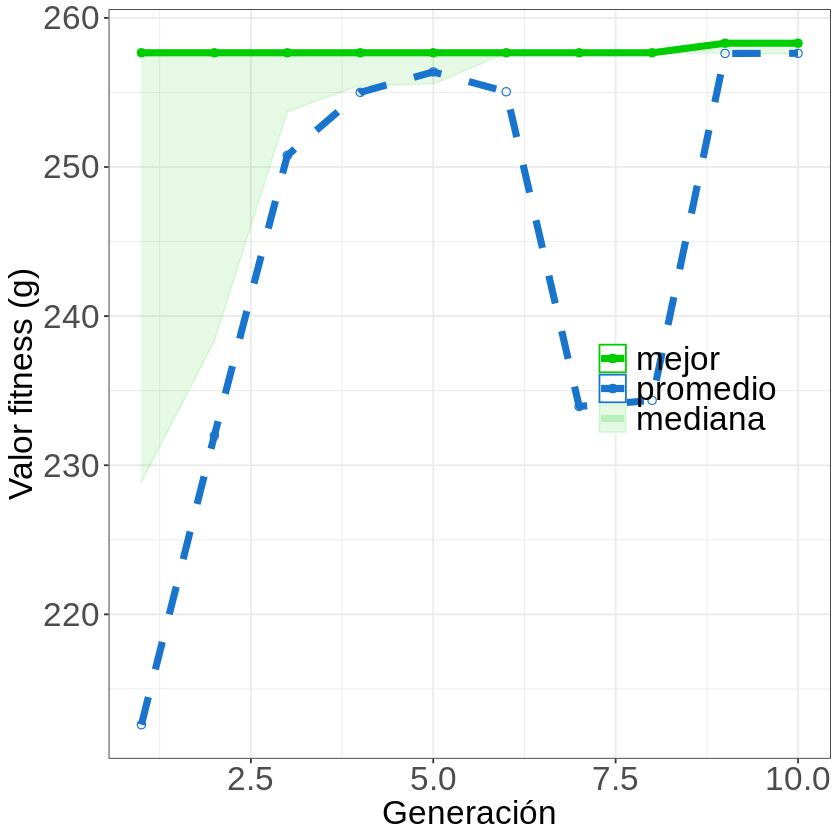

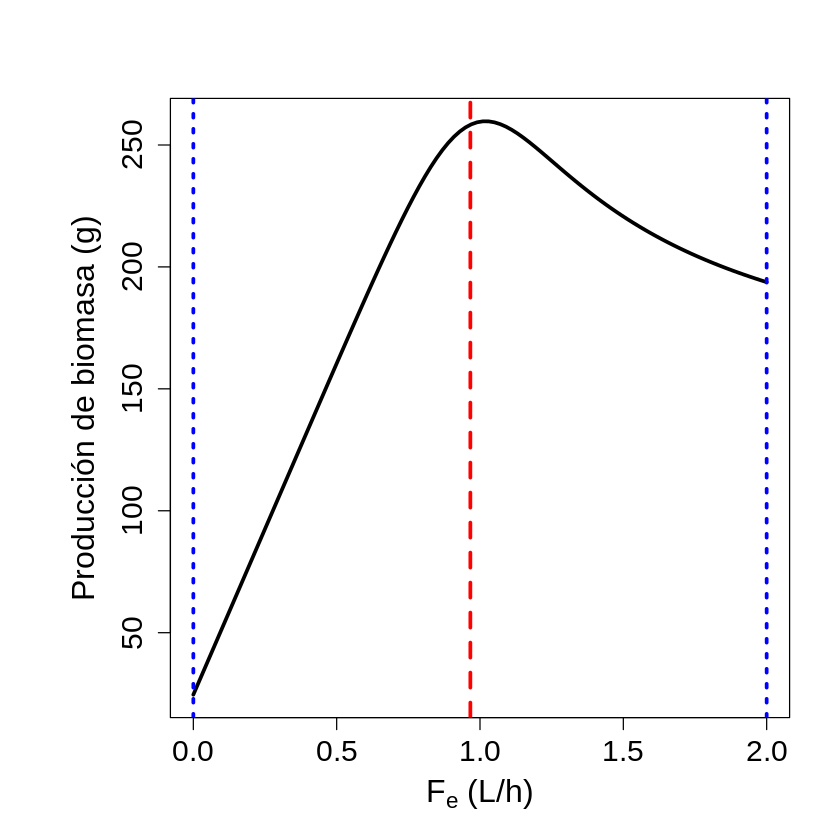

In [374]:
out_zb_opt_const <- show_results(GA_zb_const, p = p_zb)

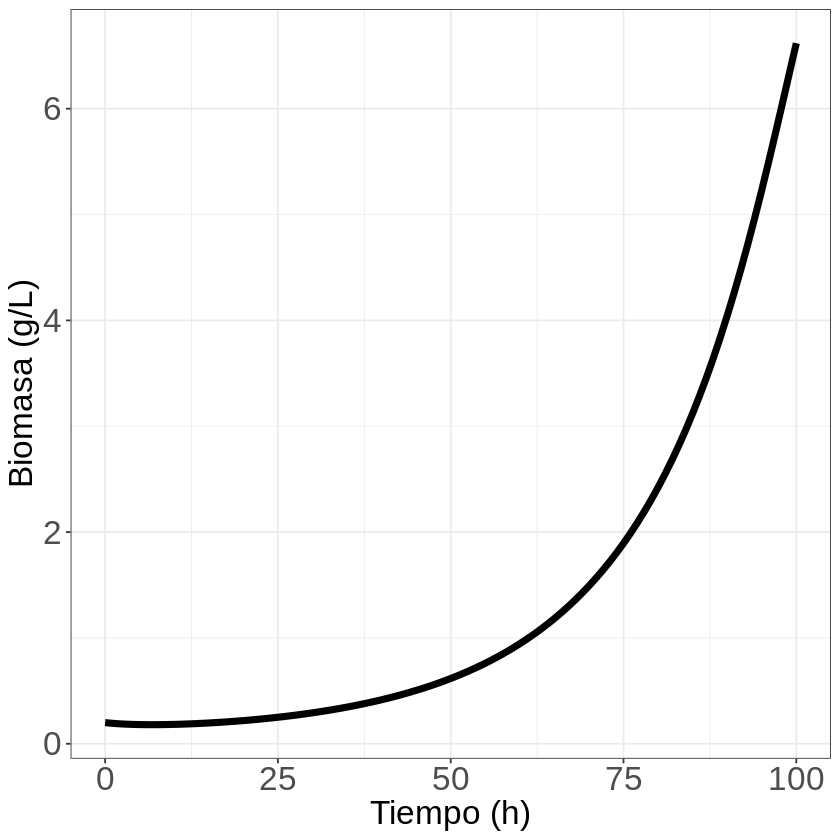

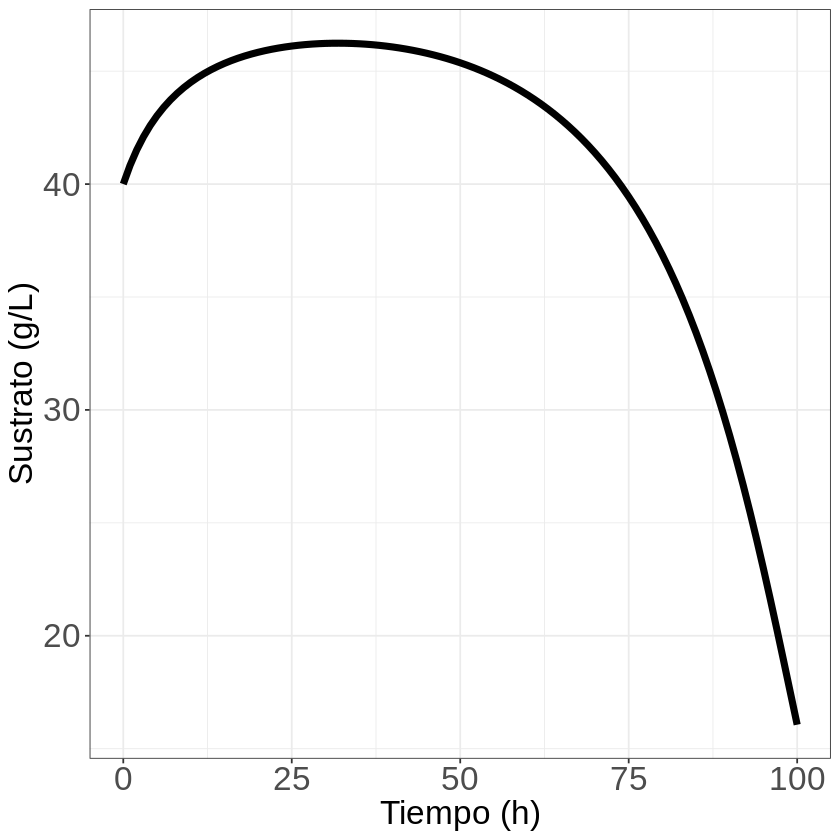

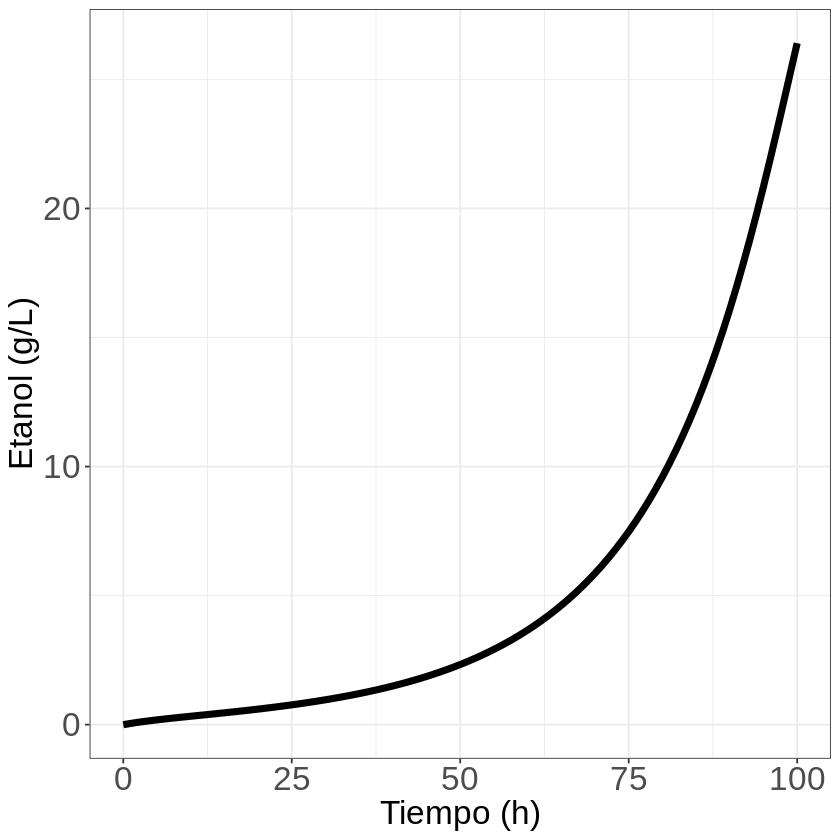

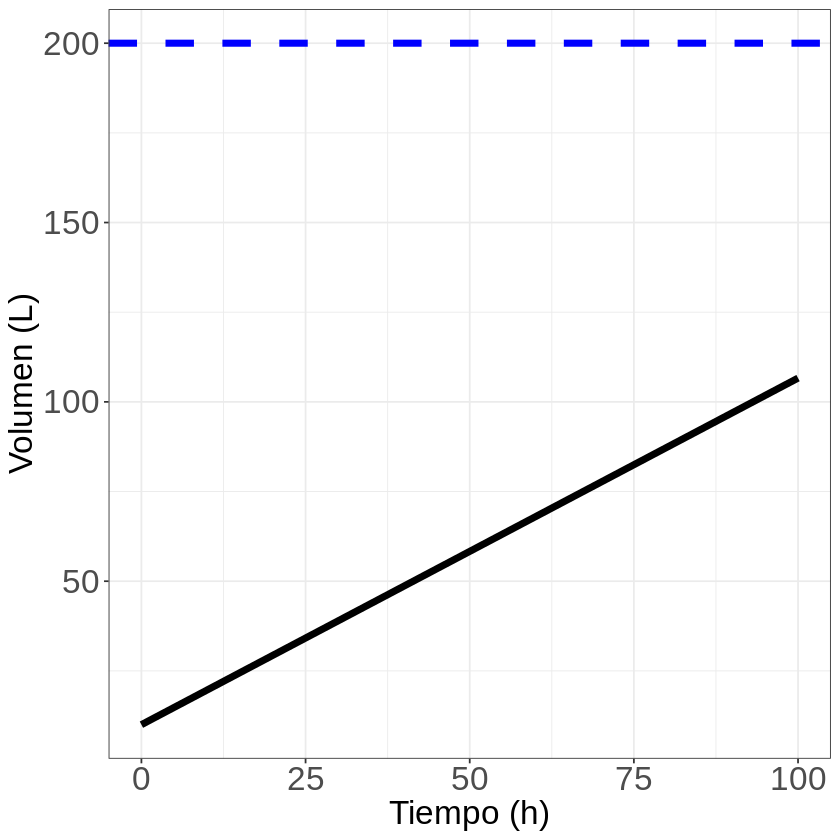

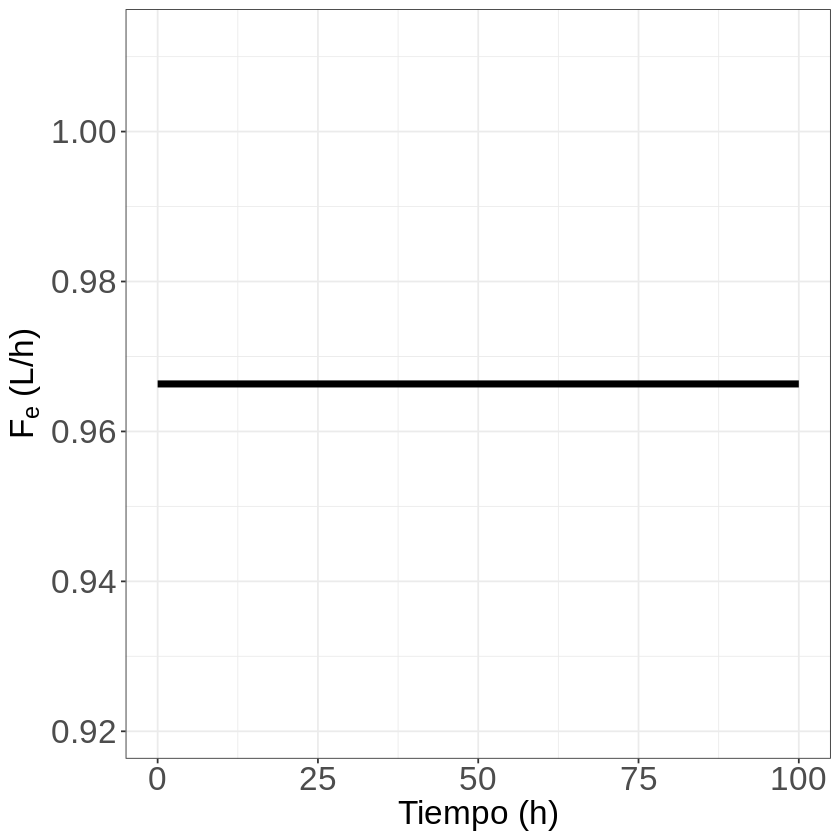

In [358]:
plot_data(out_zb_opt_const)

### Optimización de Fin para *Zygosaccharomyces rouxi*

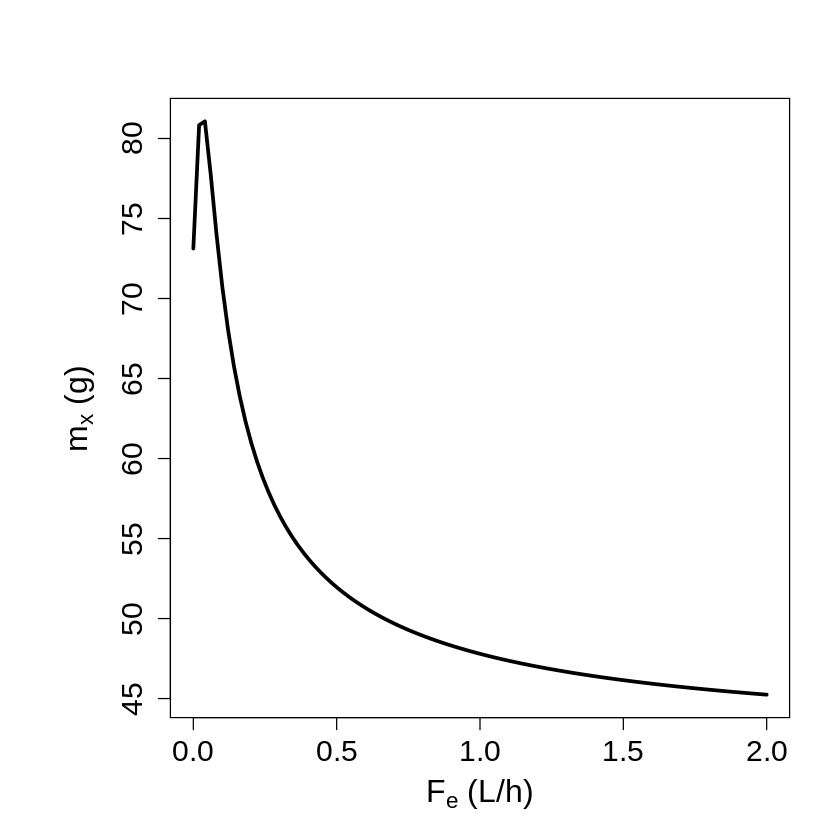

In [29]:
# mostrar función fitness evaluada para todos los Fe
show_fitness(times = times, state = s, parms = p_zr, Fe = Fe)

tiempo de ejecución: 0.7318861 


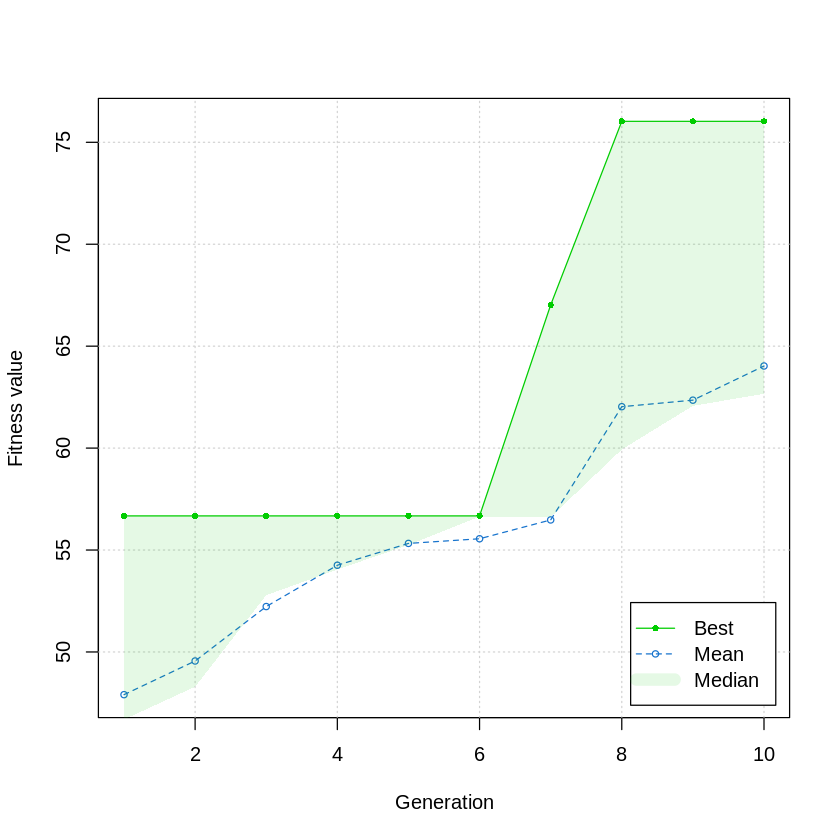

Fin_opt: 0.06974961  L/h
mx_opt: 76.02821 g


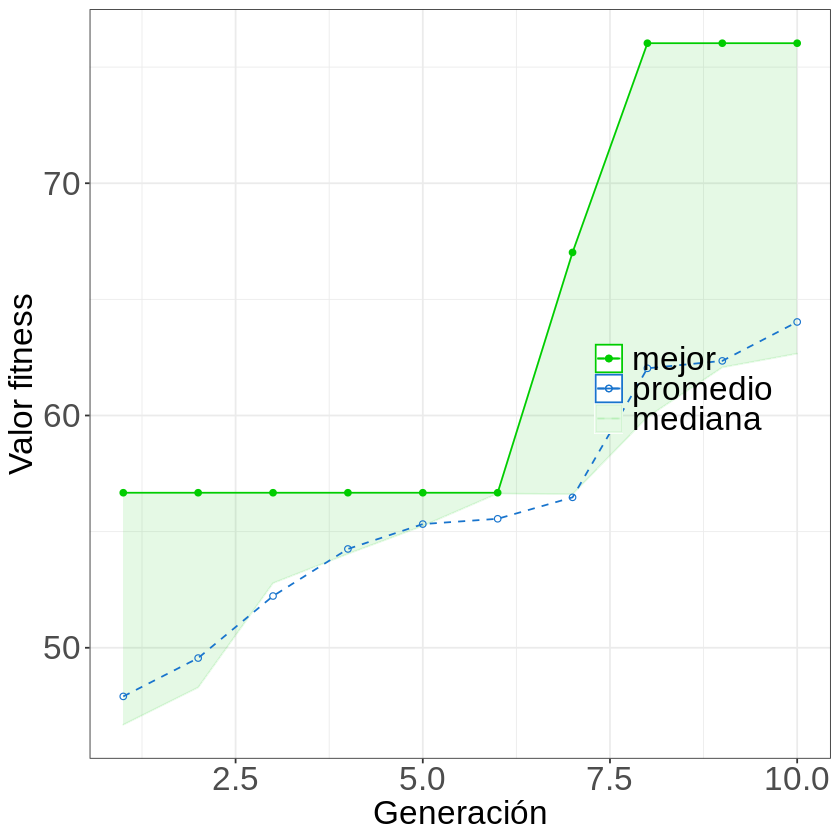

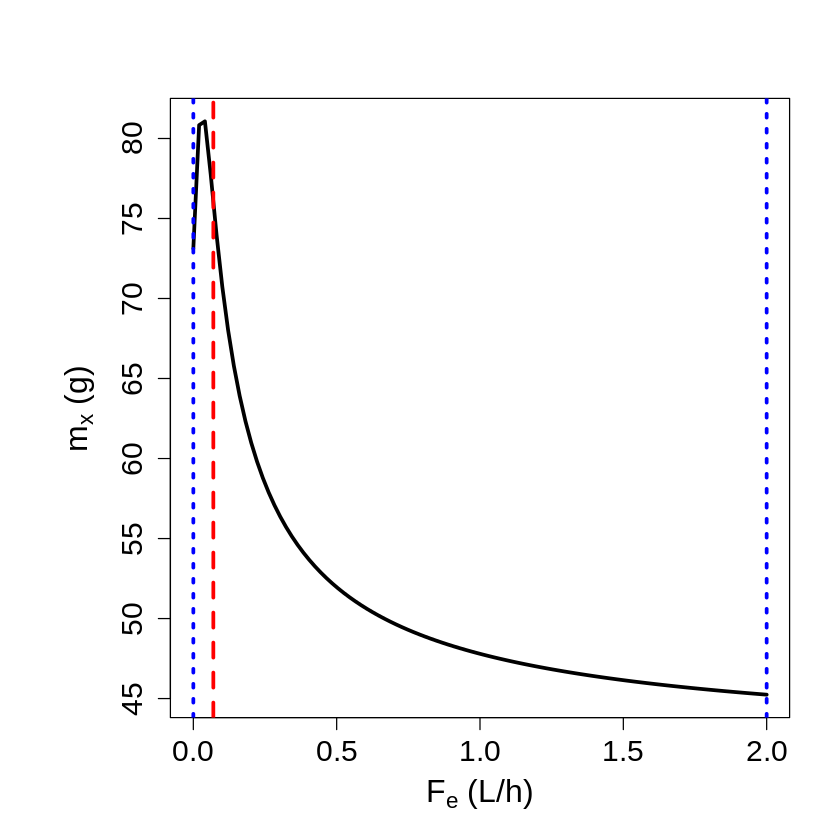

In [226]:
set.seed(123)
pop_size_const = 10
generation_const = 10
GA_zr_const <- get_Fin_opt(p_zr, pop_size = pop_size_const, generations = generation_const)

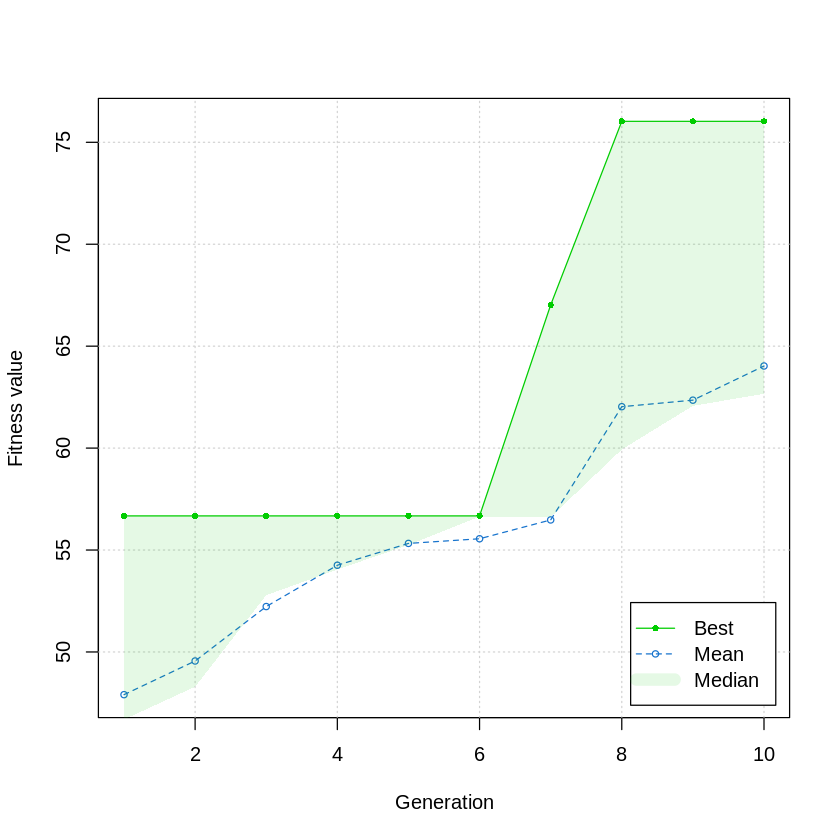

Fin_opt: 0.06974961  L/h
mx_opt: 76.02821 g


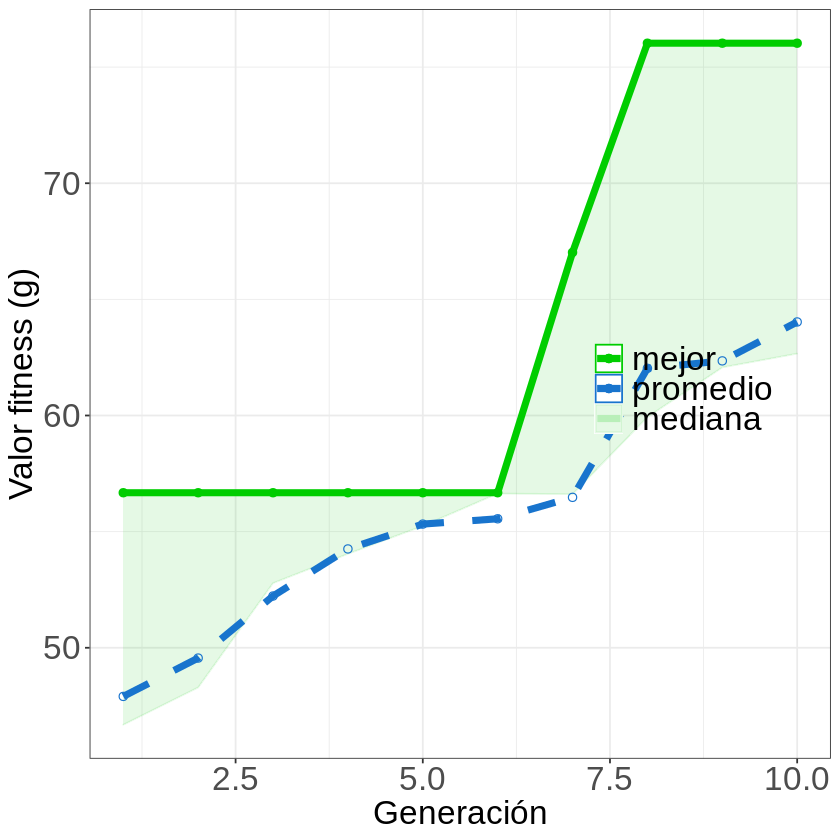

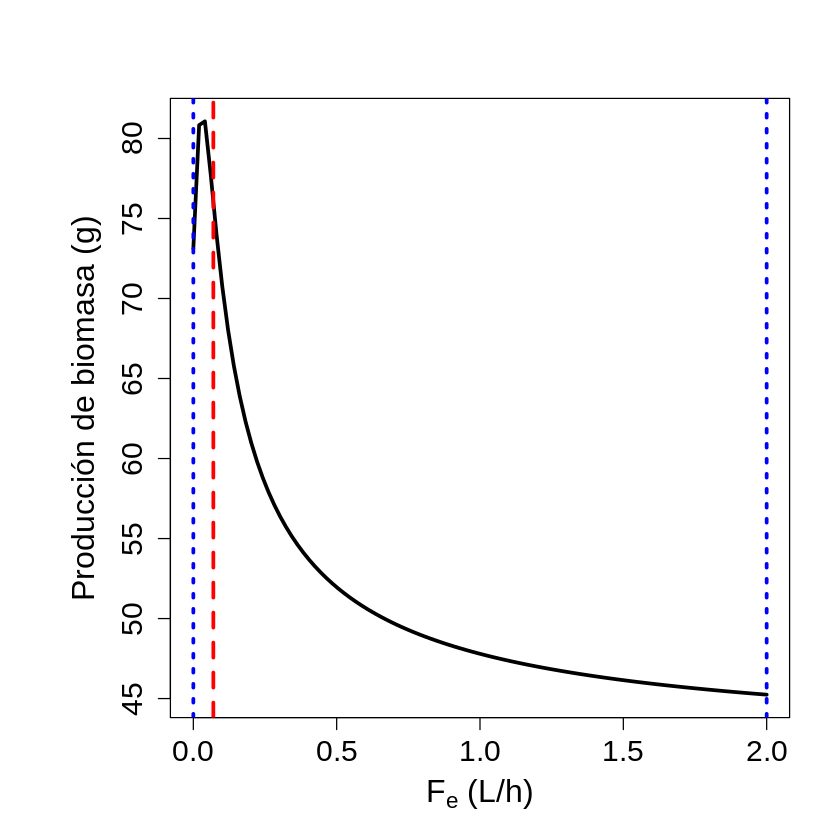

In [375]:
out_zr_opt_const <- show_results(GA_zr_const, p = p_zr)

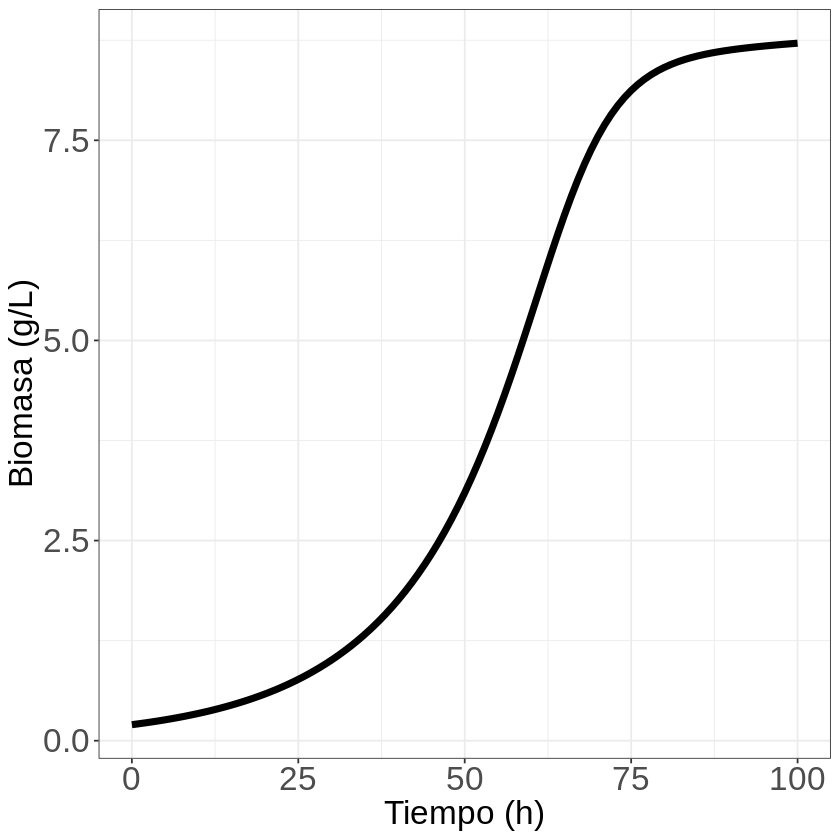

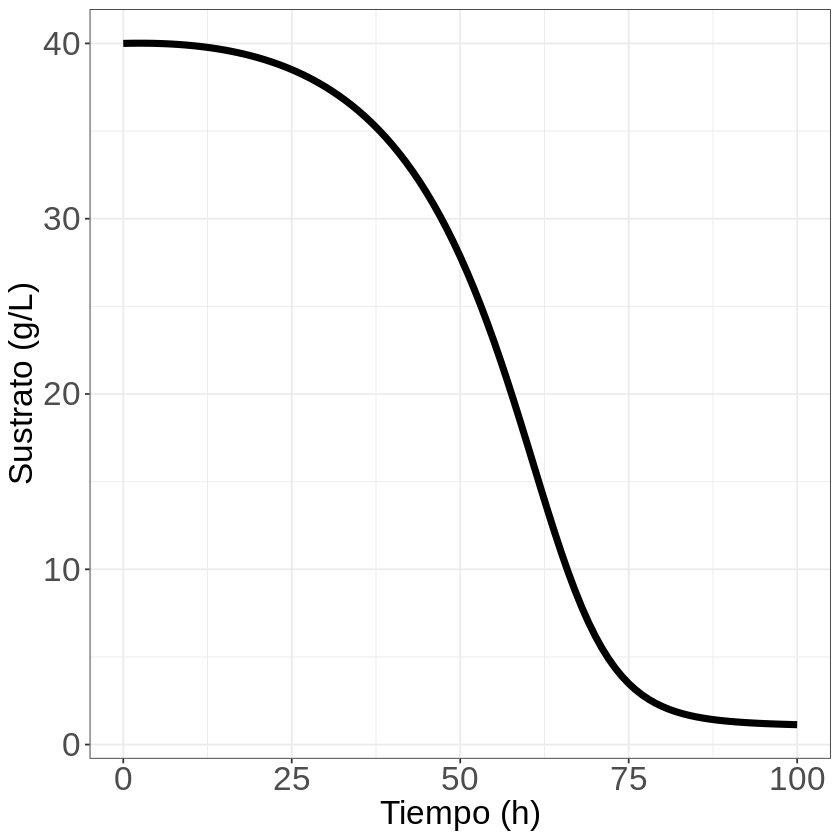

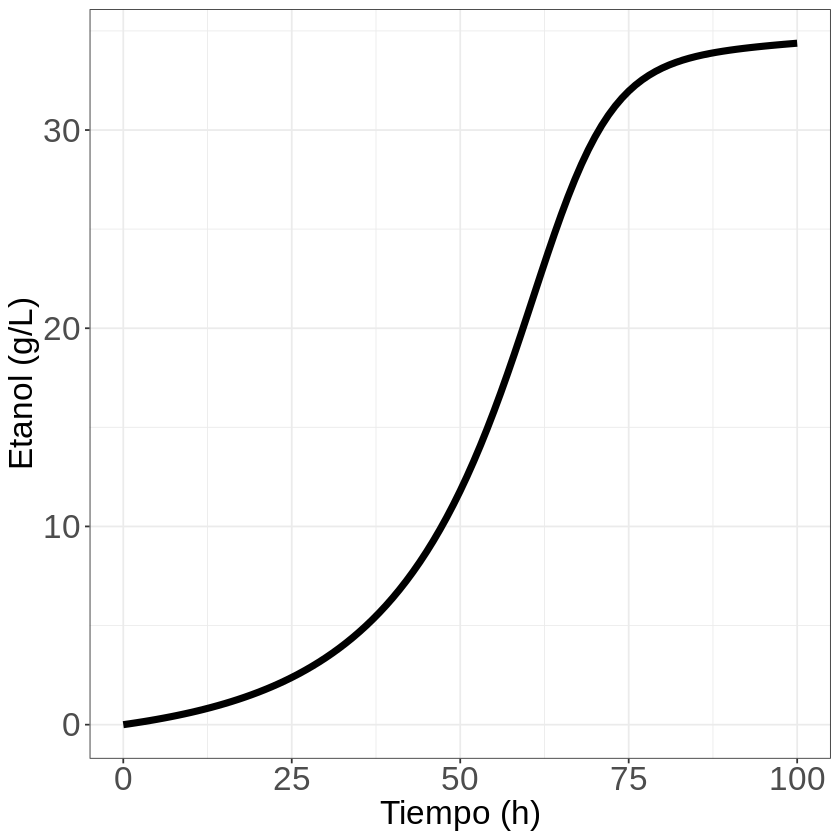

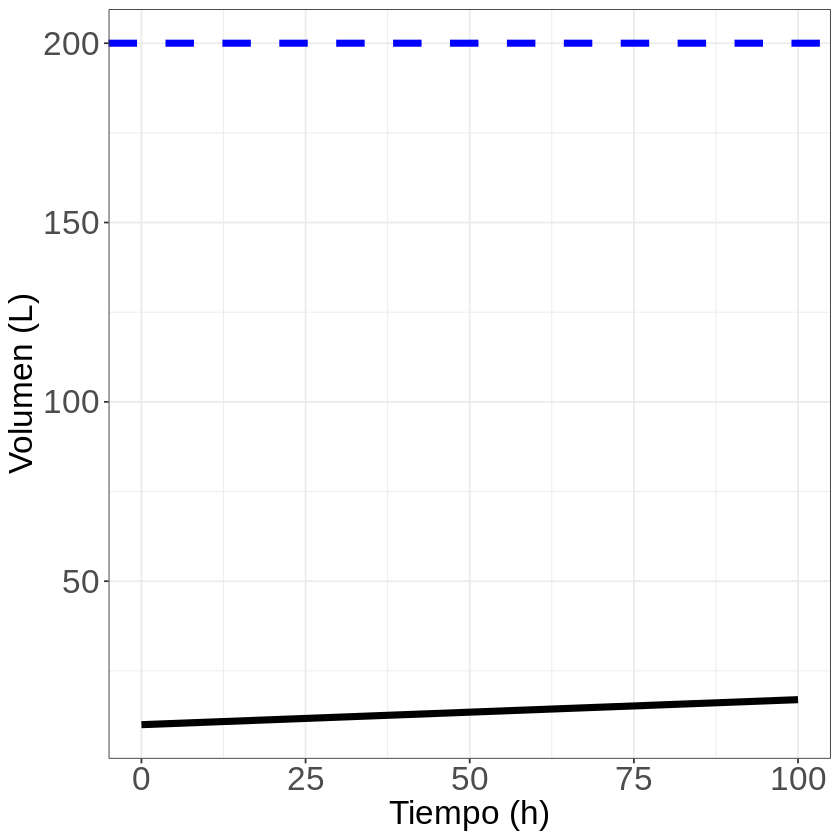

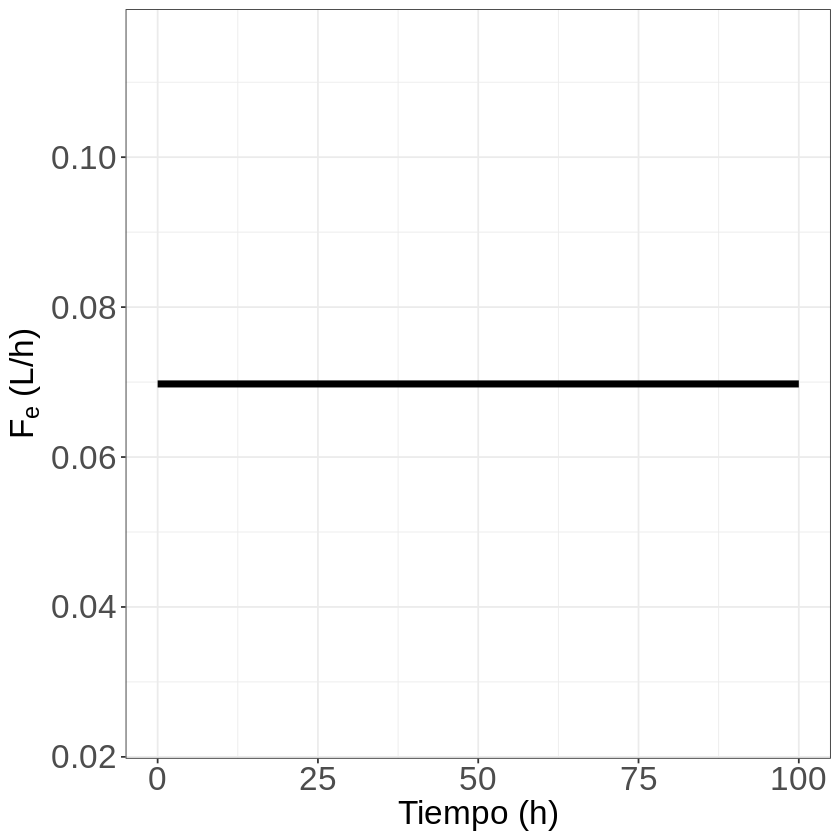

In [360]:
plot_data(out_zr_opt_const)

# Encontrar el perfil de alimentación $F_{e}$ que genera la máxima producción de biomasa $m_x$

Ahora optimizamos para encontrar el perfil $F_{e}$ que genere una máxima producción de biomasa

In [427]:
#@title función para variar Fe durante el proceso
change_Fe <- function(times, state, parms, Fe) {
        
        n <- length(times)
        # vectores para guardar los resultados
        V <- rep(state[1], n)
        su <- rep(state[2],n)
        x <- rep(state[3],n)
        p <- rep(state[4],n)
        
        # resolver EDO para los diferentes valores de Fin
        for (i in 1:(n-1)) {
                # actualizar tiempo de integración
                tspan <- c(times[i], times[i+1])
                # resolver EDOs
                out <- ode(y = state,
                           times = tspan,
                           func = model,
                           parms = parms,
                           Fe = Fe[i+1])# actualizar Fin
                m <- nrow(out)
                # actualizar condiciones iniciales
                state <- out[m,c(2,3,4,5)]
                # guardar resultados 
                out <- as.data.frame(out)
                V[i+1] <- out$V[m]
                su[i+1] <- out$s[m]
                x[i+1] <- out$x[m]
                p[i+1] <- out$p[m]
                Fe[i+1] <- out$Fe[m]
        }
        
        out <- data.frame(times = times, x = x, s = su, p = p, V = V, Fe = Fe)
        return(out)
}

In [428]:
Fe <- rep(0, length(times))
Fe[51:100] <- 1

In [429]:
out <- change_Fe(times = times, state = s, parms = p, Fe = Fe)
tail(out)

times x        s        p        V  Fe
96   95   8.291510 6.935289 33.02318 56 1 
97   96   8.368758 6.577242 33.33468 57 1 
98   97   8.439052 6.252998 33.61827 58 1 
99   98   8.502954 5.959786 33.87622 59 1 
100  99   8.561031 5.694827 34.11079 60 1 
101 100   8.745793 4.771017 34.84984 60 0

In [430]:
n <- nrow(out)
cat("mx_end:", out$V[n]*out$x[n])

mx_end: 524.7476

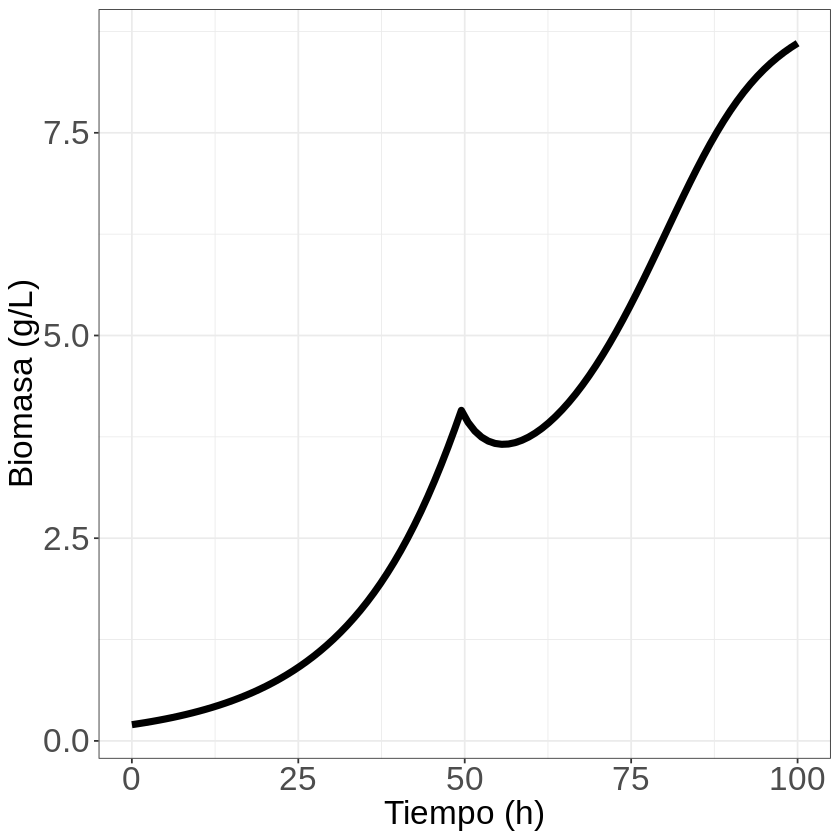

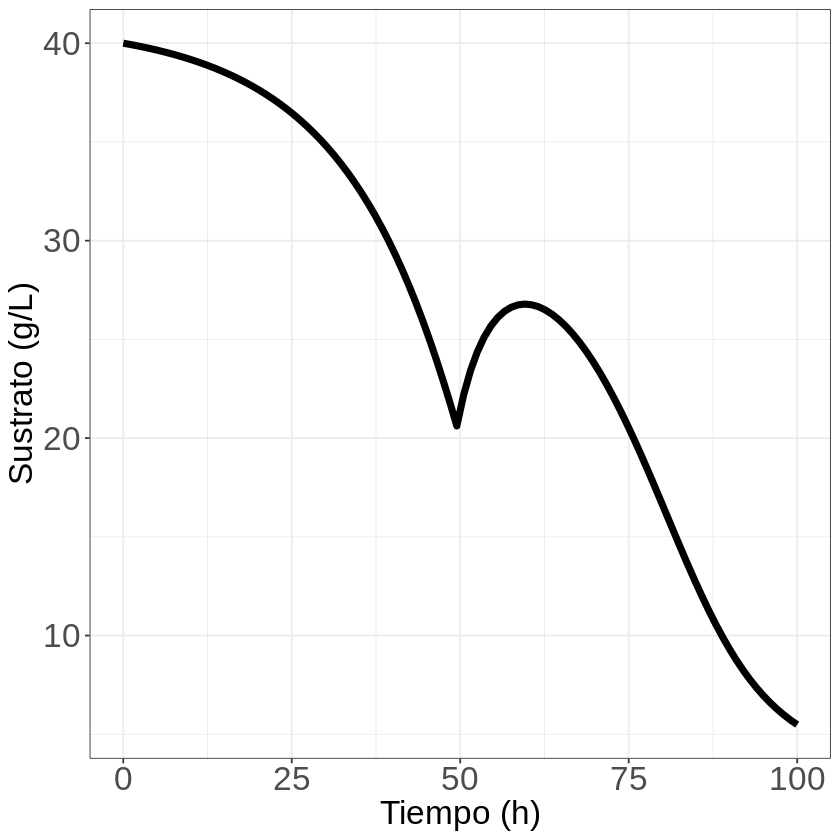

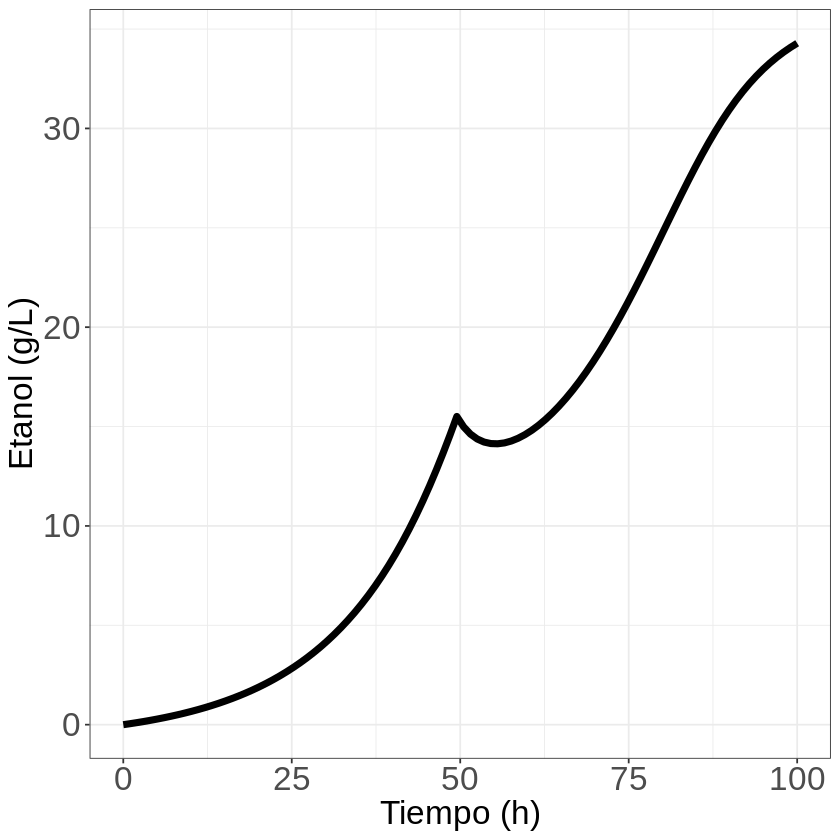

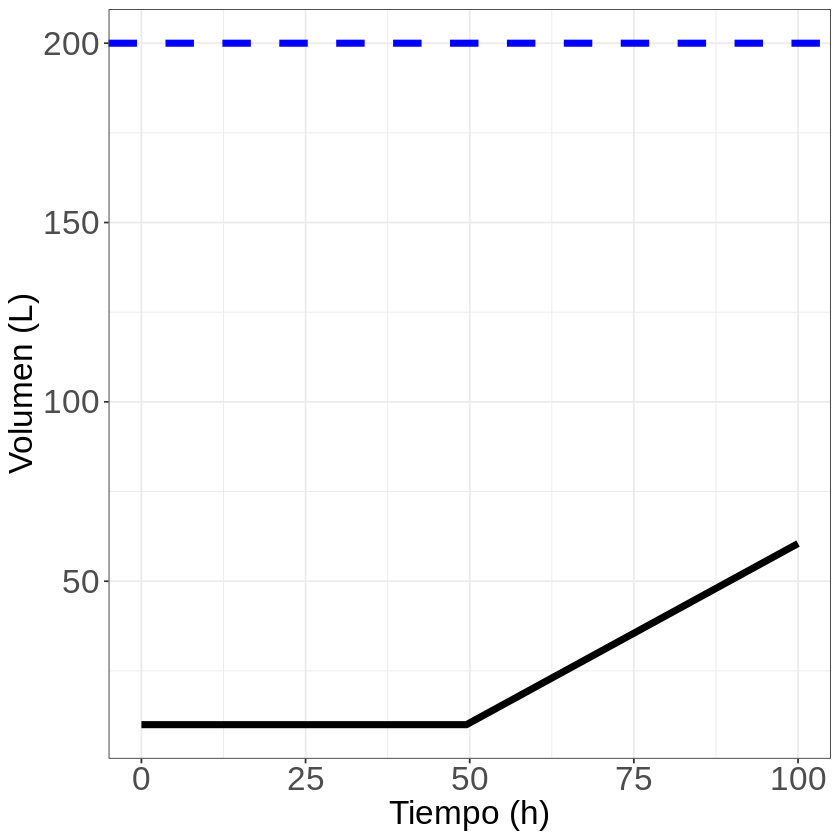

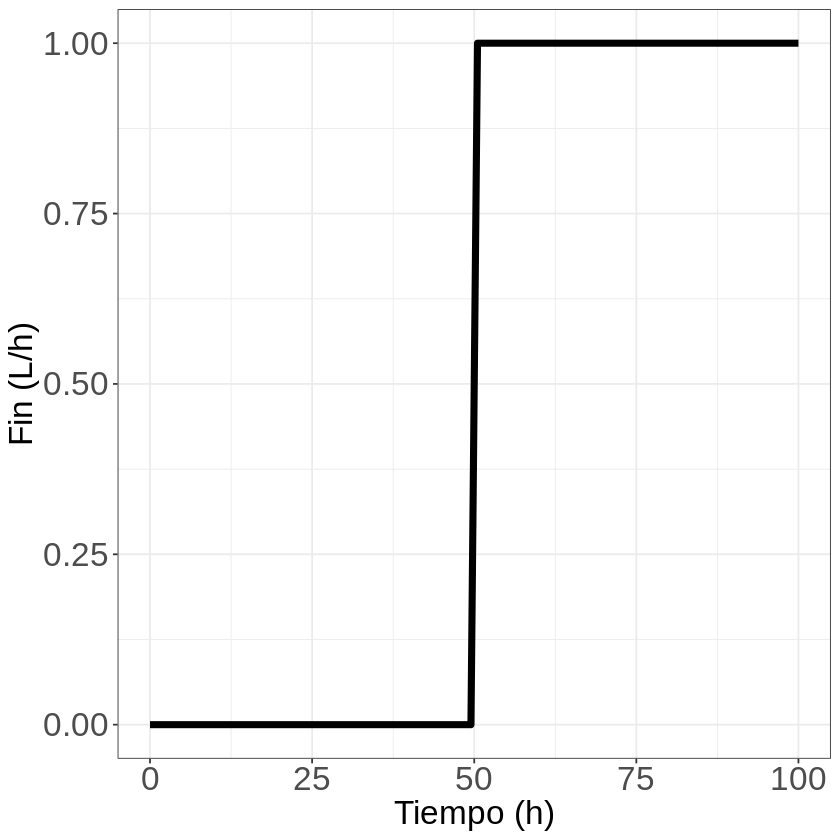

In [35]:
plot_data(out)

In [456]:
#@title función para suavizar el perfil de alimentación
smooth_Fe <- function(Fe) {
  for (i in 1:(length(Fe)/2)) {
    Fe[(2*i-1):(2*i)] = mean(Fe[(2*i-1):(2*i)])
  }
  return(Fe)
}

In [457]:
#@title función para modificar el perfil óptimo obtenido con el GA
modify_Fe <- function(Fe){
        Fe <- rep(Fe, each = 5)
        Fe <- smooth_Fe(Fe) # suavizar perfil
        return(Fe)
}

In [469]:
# @title función fitness para encontrar el perfil óptimo Fin de alimentación al biorreactor
fitness2 <- function(x, times, state, parms) {
        # x es el vector  con valores de Fin 
        # x tiene una longitud de 10, para hacerlo de tamaño 100 usamos rep()
        Fe <- modify_Fe(x)
        #Fin <- x
        # simular usando Fin variable 
        out <- change_Fe(times = times, state = state, 
        parms = parms, Fe = Fe)
        n <- length(times)
        # biomasa generada con el perfil Fin
        end_mx <- out$x[n]*out$V[n]
        
        return(end_mx)
}

In [470]:
fitness2(x = rep(c(0,1), each = 10), times = times, state = s, parms = p)

[1] 520.6485

### Optimización de perfil Fin para *Isstchenkia terrícola*

In [146]:
# @title función para obtener el perfil óptimo
get_Fin_opt2 <- function(p, pop_size, generations) {
    time1 <- Sys.time()
    GA <- ga(type = "real-valued",
            fitness = fitness2,
            times= times,
            state = s,
            parms = p,
            lower = rep(0, 20),
            upper = rep(2, 20),
            maxiter = 1000, 
            popSize = 50, 
            elitism = 2)
    time2 <- Sys.time()
    cat("timepo de ejecución:",time2 - time1)
    return(GA)
}

In [65]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_it <- get_Fin_opt2(p_it, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución 39.32359

In [483]:
#@title función para mostrar resultados de optimización del perfil óptimo
show_results2 <- function(GA, GA_const, p) {
    # mostrar evolución del algoritmo
    show_GA_evol(GA)
    # valor máximo de biomasa que se obtuvo
    cat("mx_opt:", GA@fitnessValue, "g\n")
    cat("mx_opt:", GA_const@fitnessValue, "g (Fin constante)")
    # guardar perfil óptimo
    Fe_opt <- modify_Fe(Fe = GA@solution[1,])
    # graficar perfil óptimo
    par(mar = c(5,7,4,2) + 0.1)
    plot(times, Fe_opt, type = "l", lwd = 3, 
        ylab = expression(paste(F[e], " (L/h)")), xlab = "Tiempo (h)", cex.lab = 1.6, cex.axis = 1.5, ylim = c(0,2))
    abline(h = mean(Fe_opt), lty = 2, lwd = 3, col = "red")
    abline(h = GA_const@solution, lty = 3, lwd = 3, col = "blue")
    # simular con perfil óptimo
    out_opt <- change_Fe(times = times, state = s, parms = p, Fe = Fe_opt)
    
    return(out_opt)
}

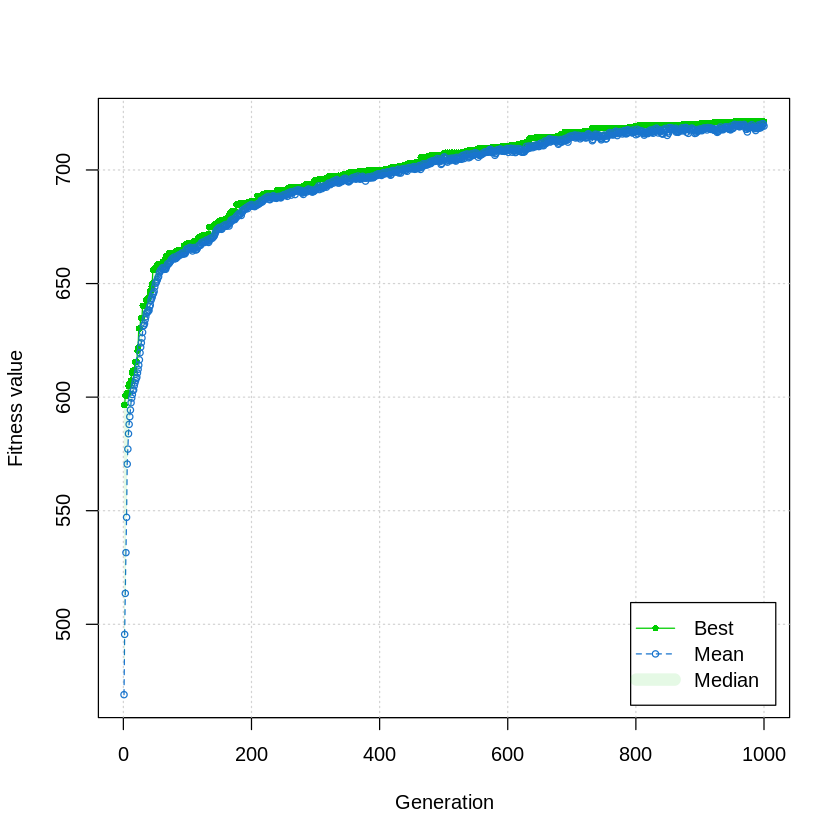

mx_opt: 721.4138 g
mx_opt: 651.7111 g (Fin constante)

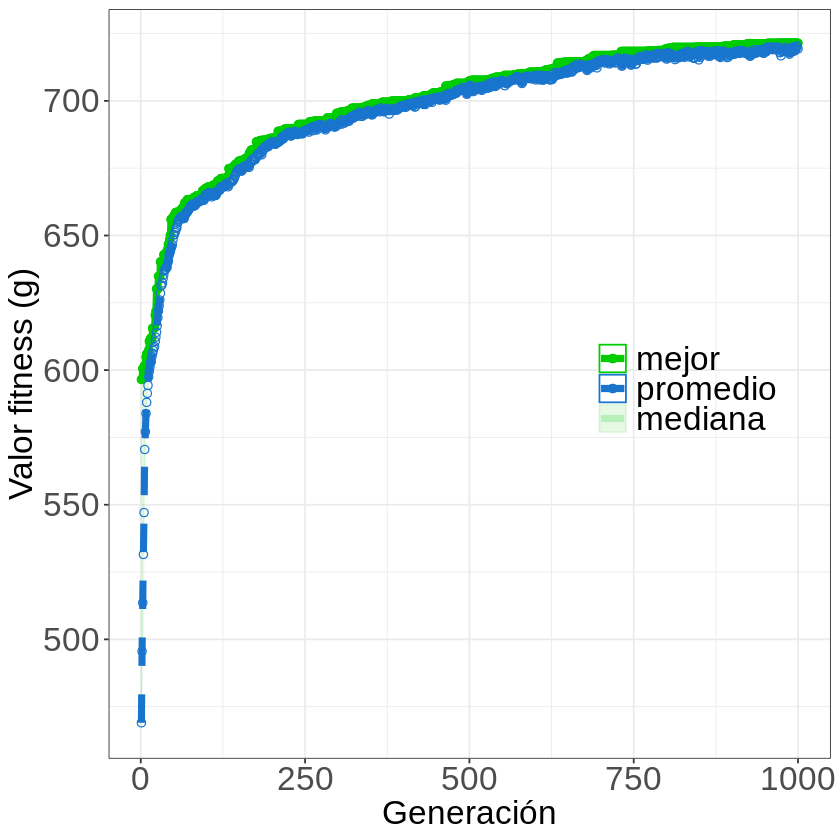

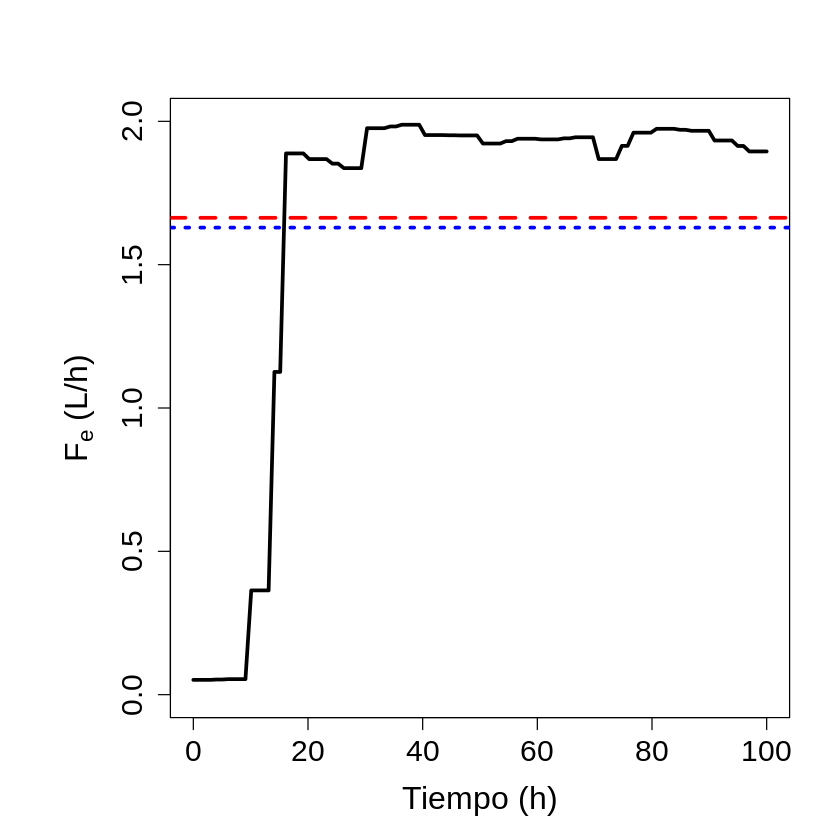

In [484]:
out_it_opt <- show_results2(GA_it,GA_it_const,p_it)

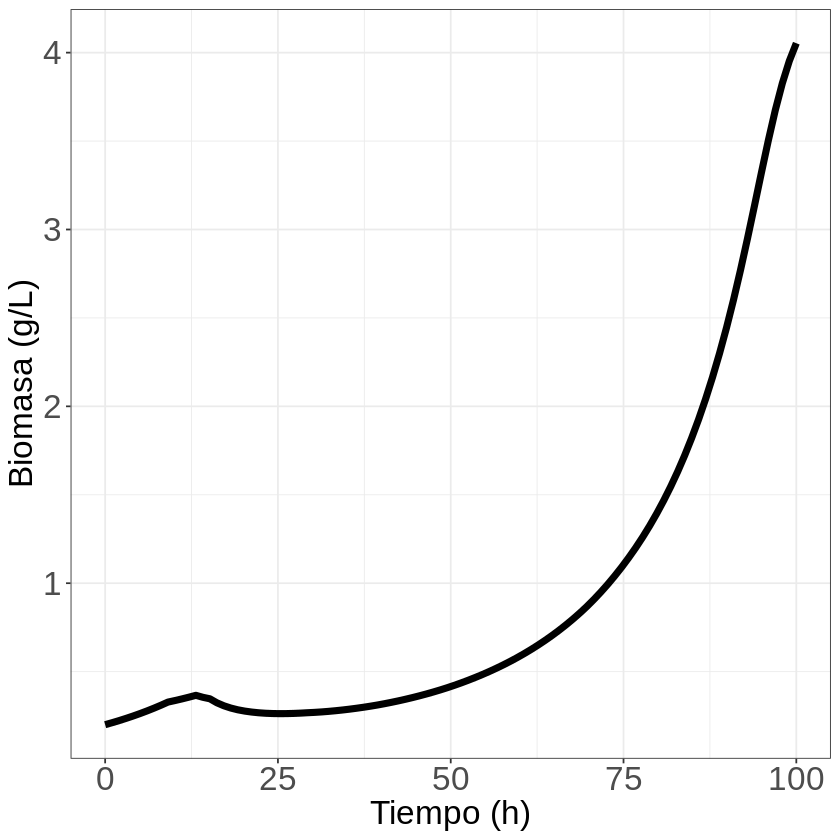

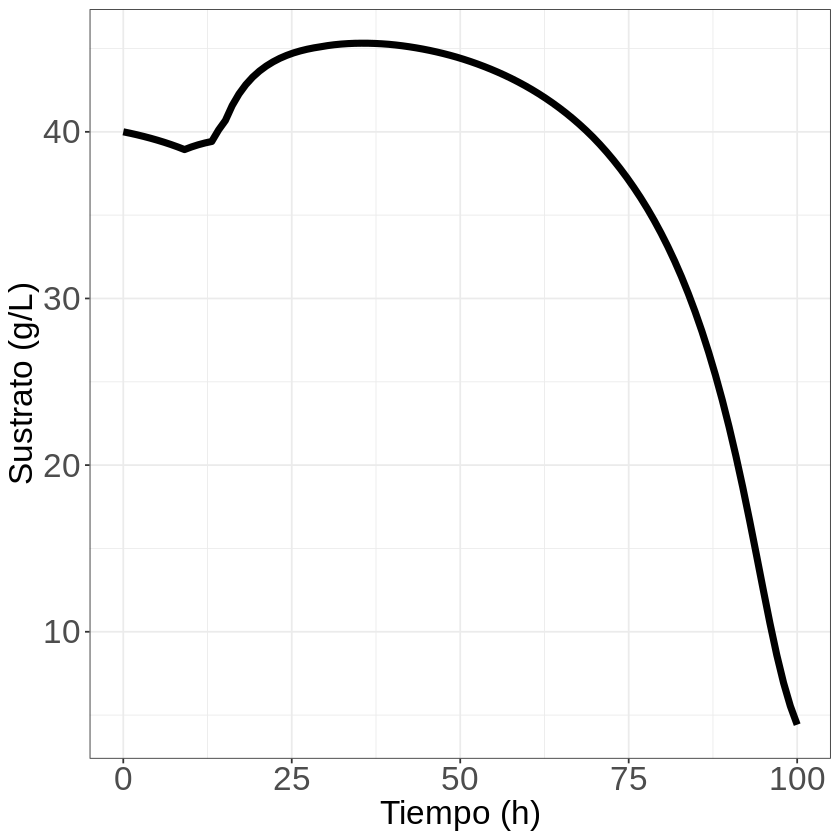

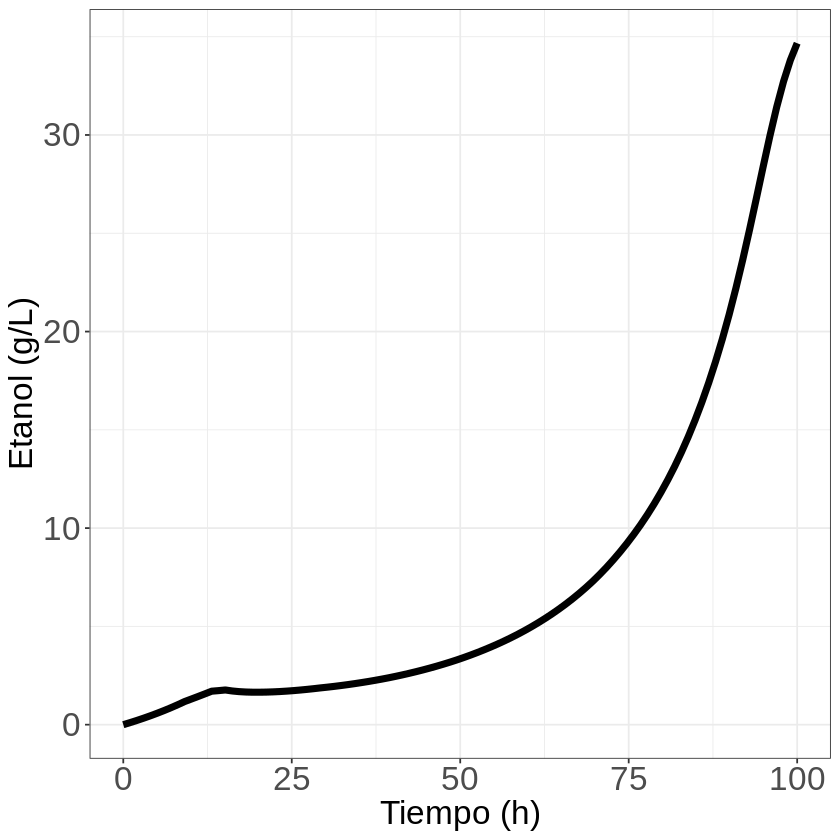

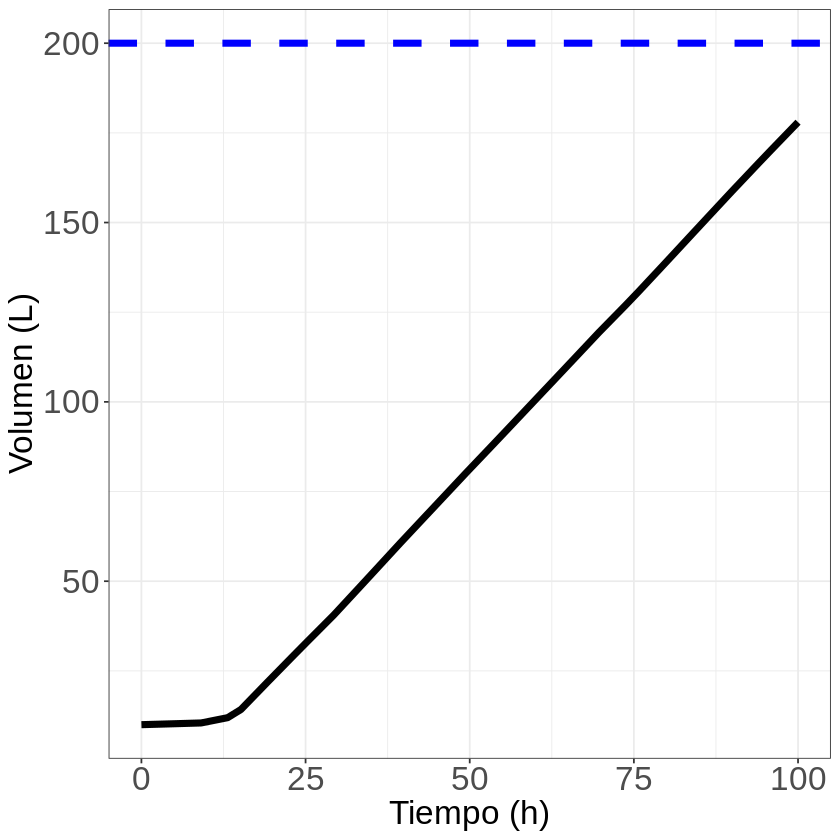

times     x        s         p        V        Fe      
95   94.94949 3.321035 12.554786 28.38290 168.3927 1.914071
96   95.95960 3.504744 10.514202 29.95974 170.3261 1.914071
97   96.96970 3.676038  8.611708 31.43006 172.2403 1.894999
98   97.97980 3.826977  6.935781 32.72577 174.1544 1.894999
99   98.98990 3.952978  5.537470 33.80756 176.0686 1.894999
100 100.00000 4.053281  4.425223 34.66891 177.9827 1.894999

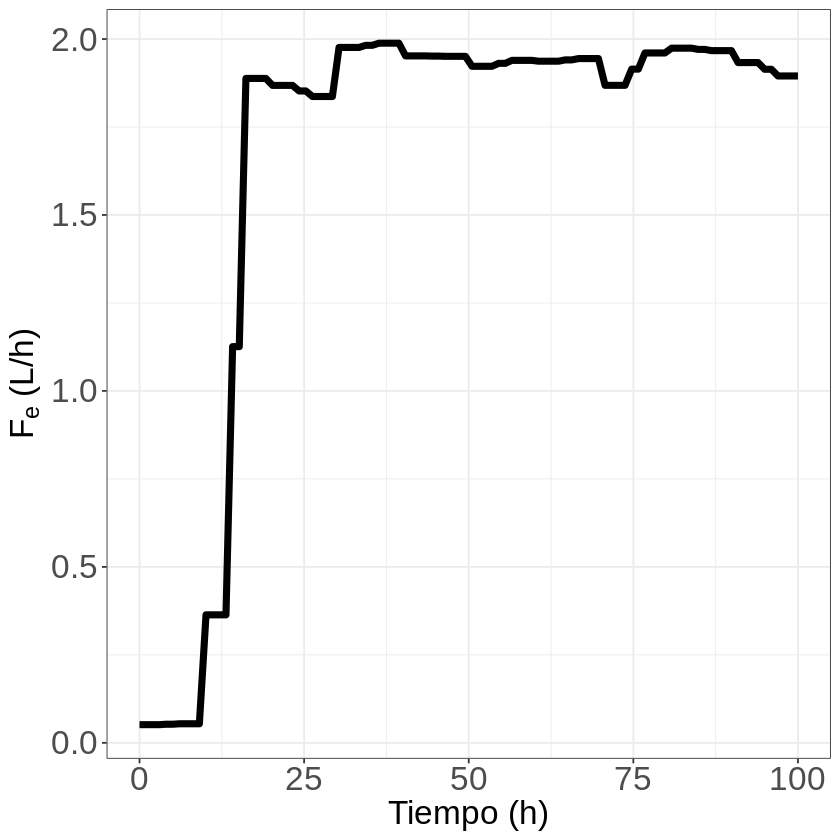

In [486]:
plot_data(out_it_opt)
tail(out_it_opt)

### Optimización del perfil Fin para *Kluyveromyces marxianus*

In [44]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_km <- get_Fin_opt2(p_km, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución 41.79018

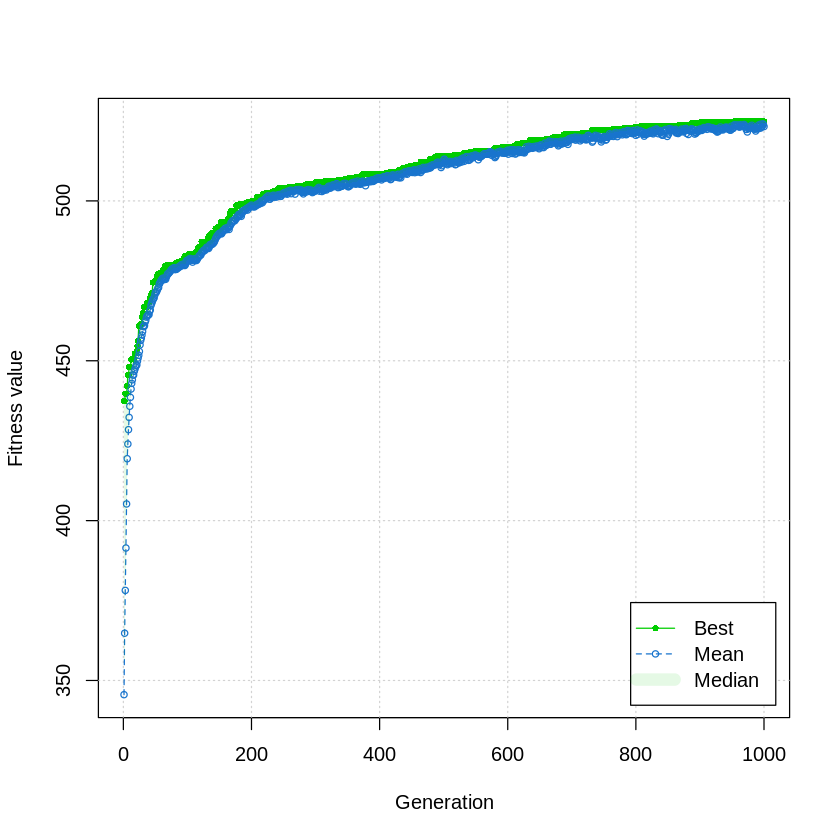

mx_opt: 524.8923 g
mx_opt: 473.2654 g (Fin constante)

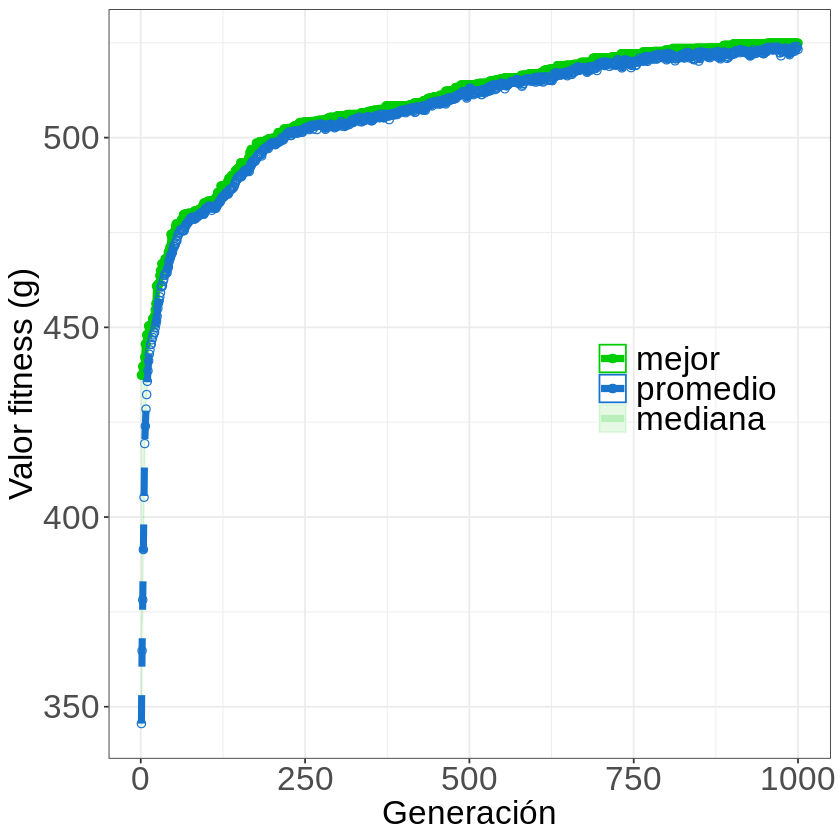

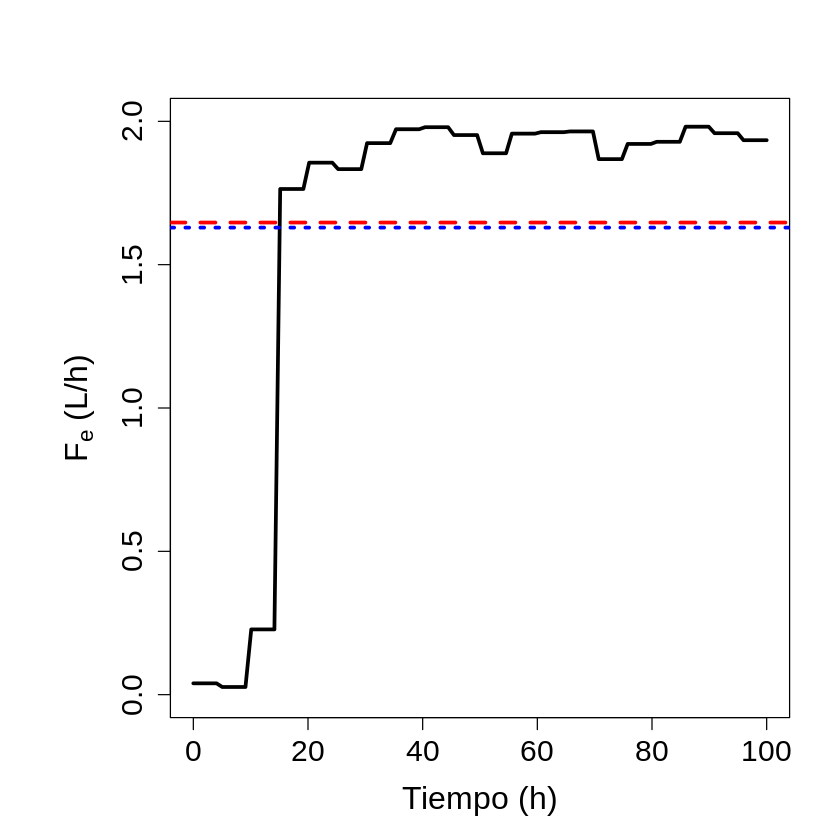

In [242]:
out_km_opt <- show_results2(GA_km,GA_km_const,p_km)

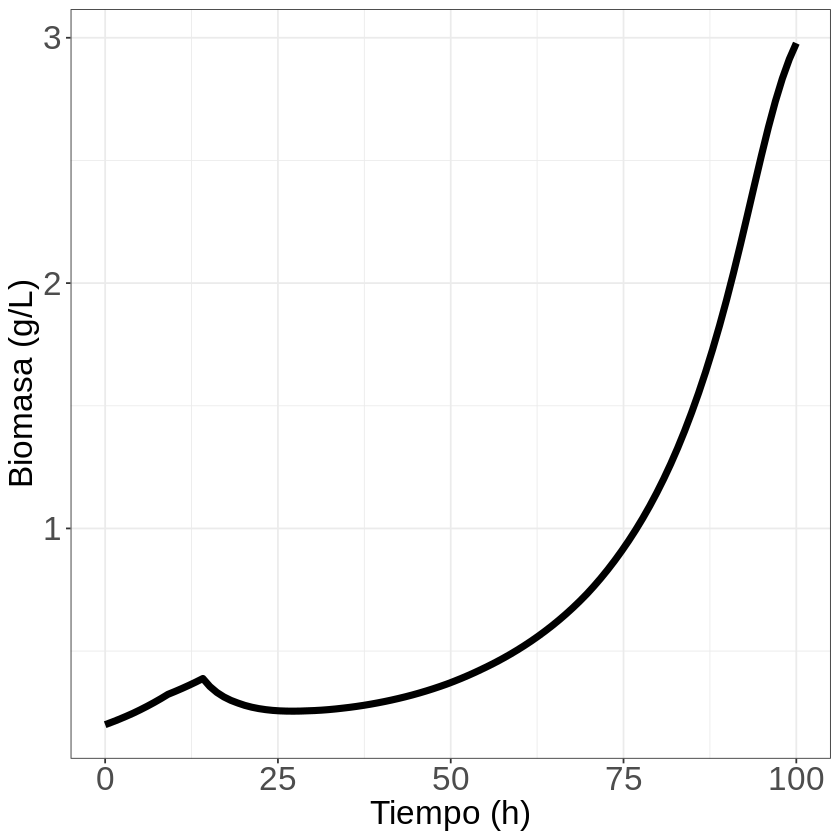

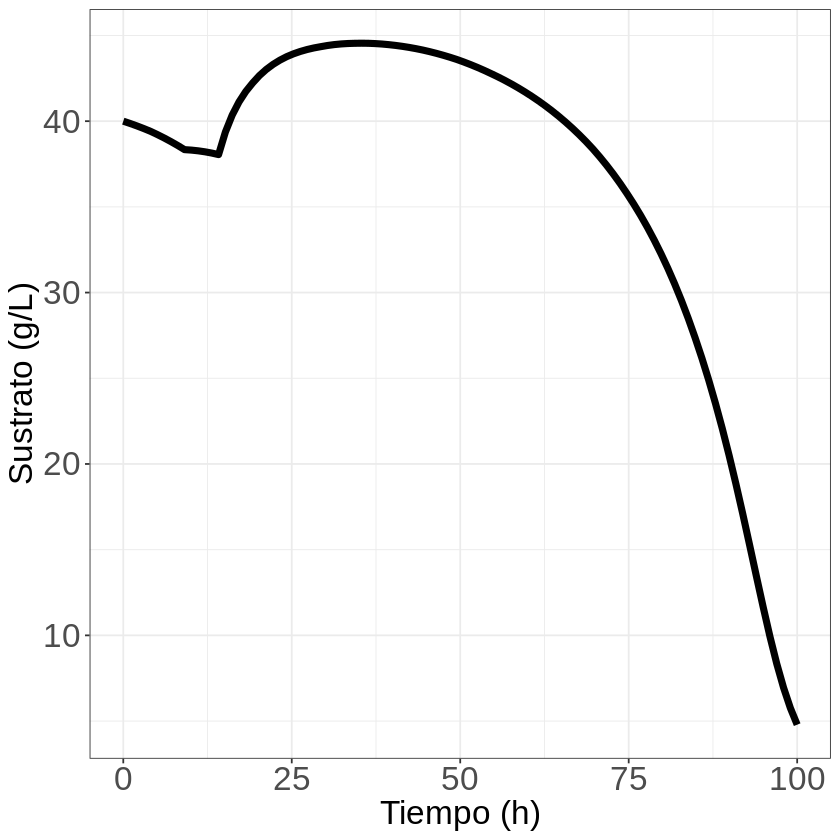

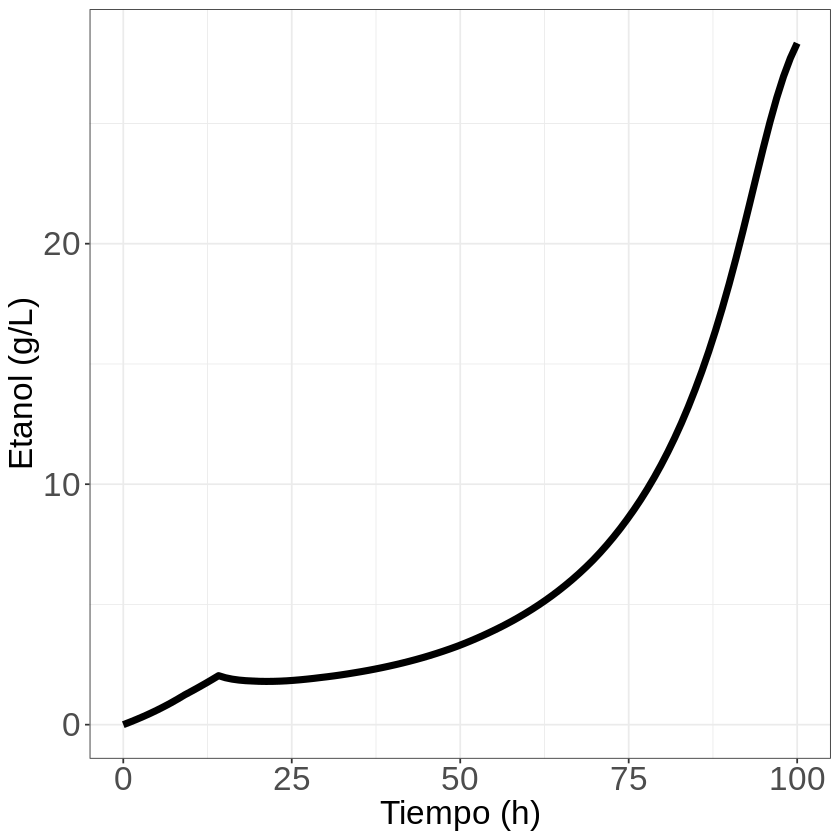

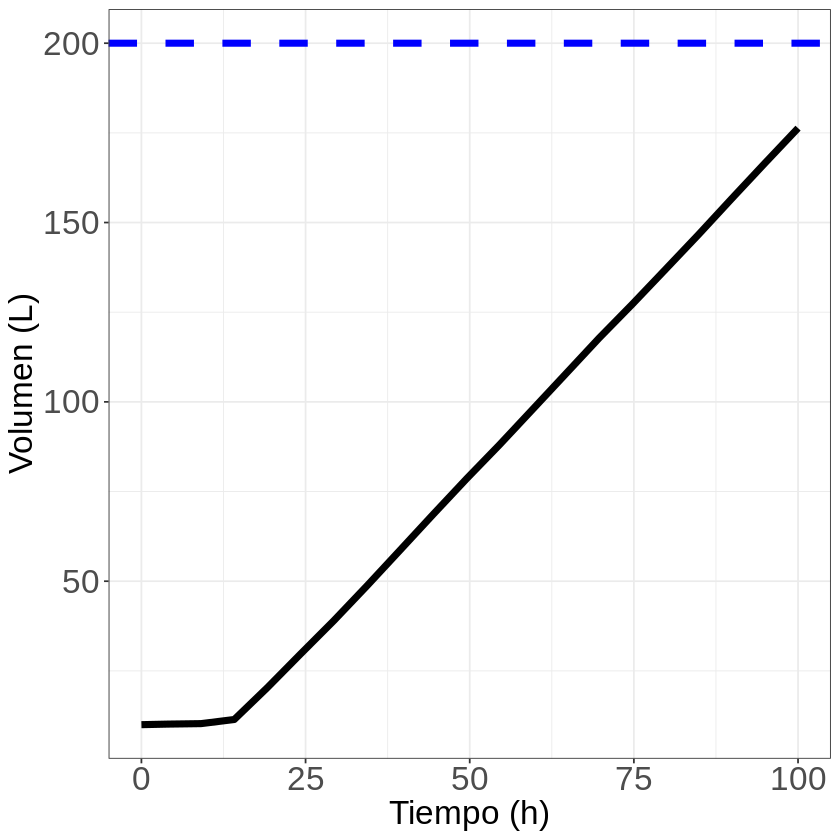

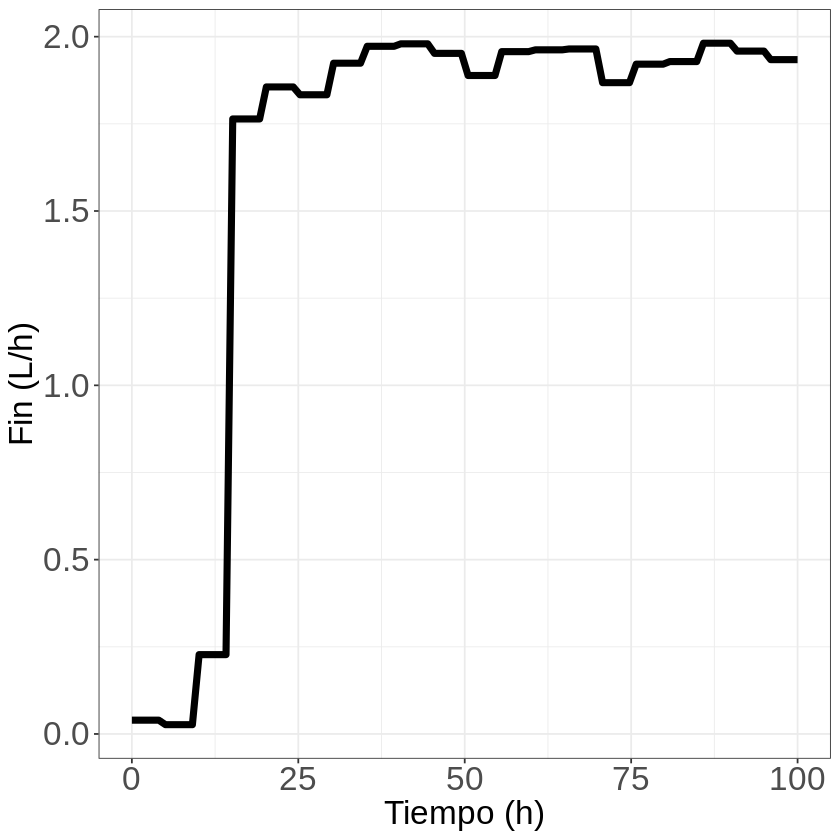

In [46]:
plot_data(out_km_opt)

### Optimización de perfil Fin para *Pichia kluyveri*

In [47]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_pk <- get_Fin_opt2(p_pk, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución 41.27473

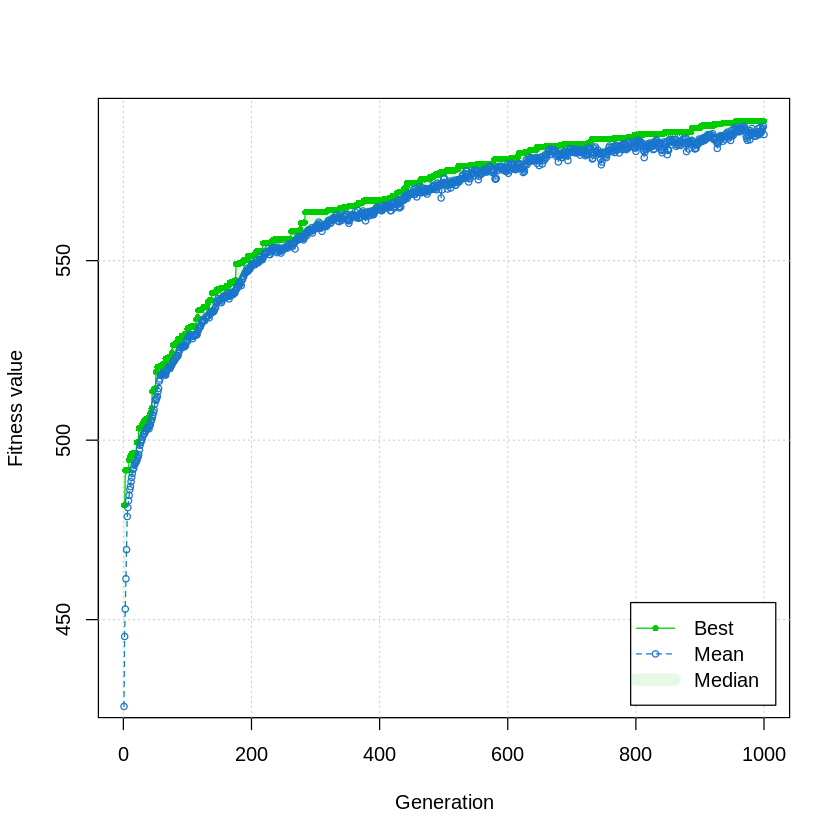

mx_opt: 588.8083 g
mx_opt: 476.4802 g (Fin constante)

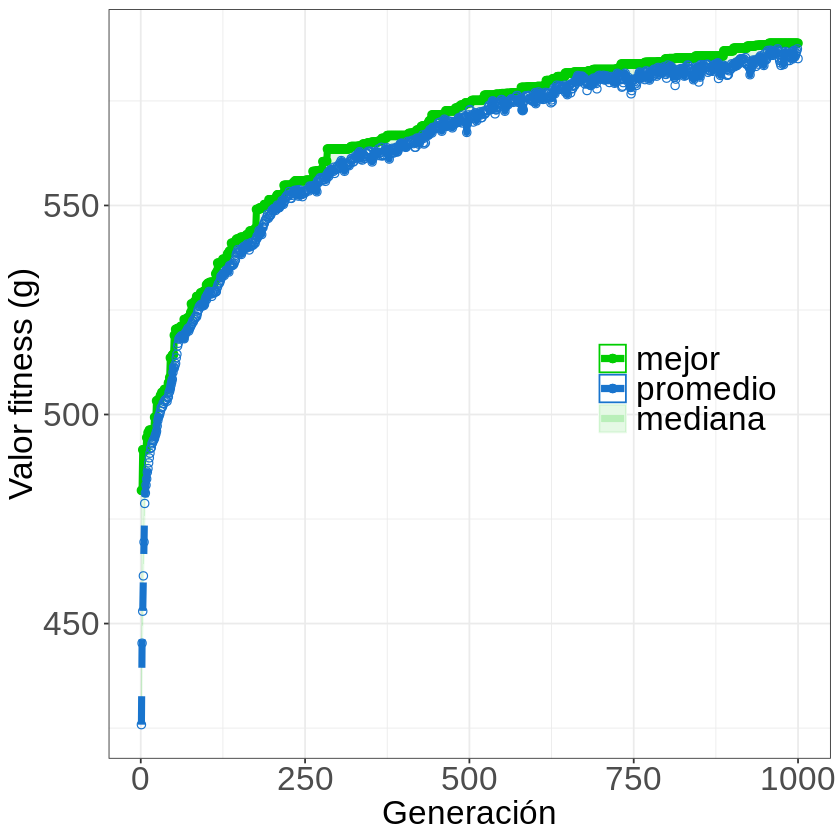

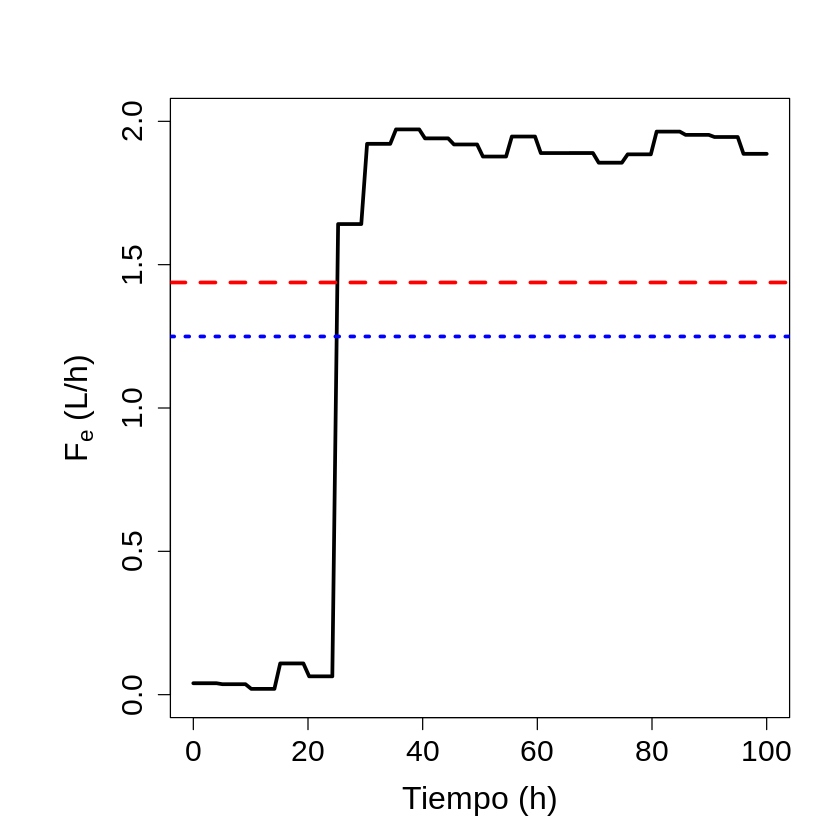

In [243]:
out_pk_opt <- show_results2(GA_pk,GA_pk_const,p_pk)

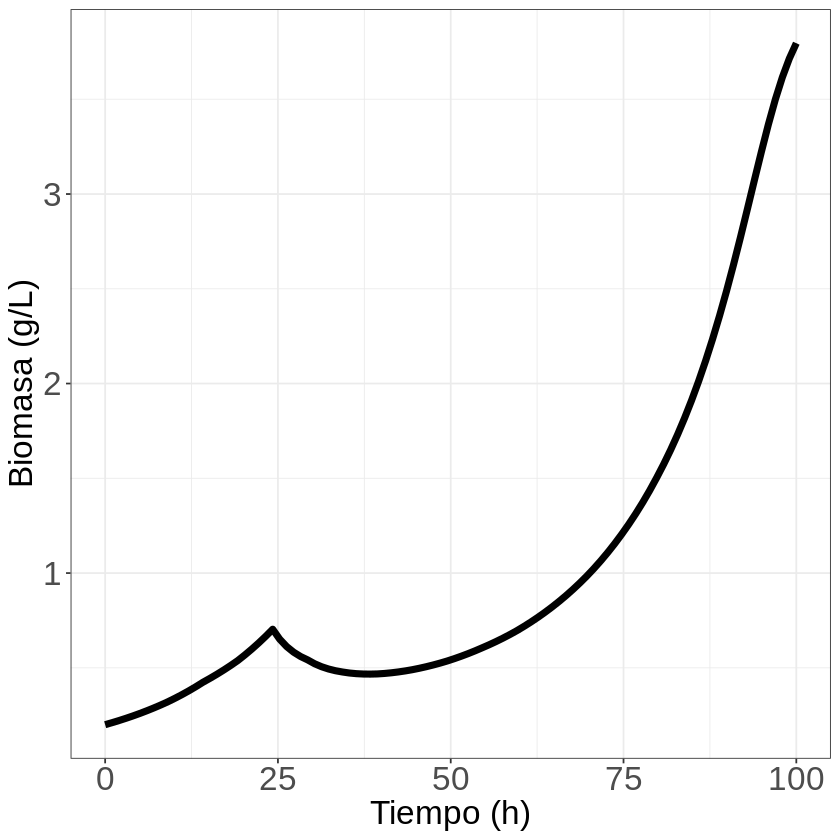

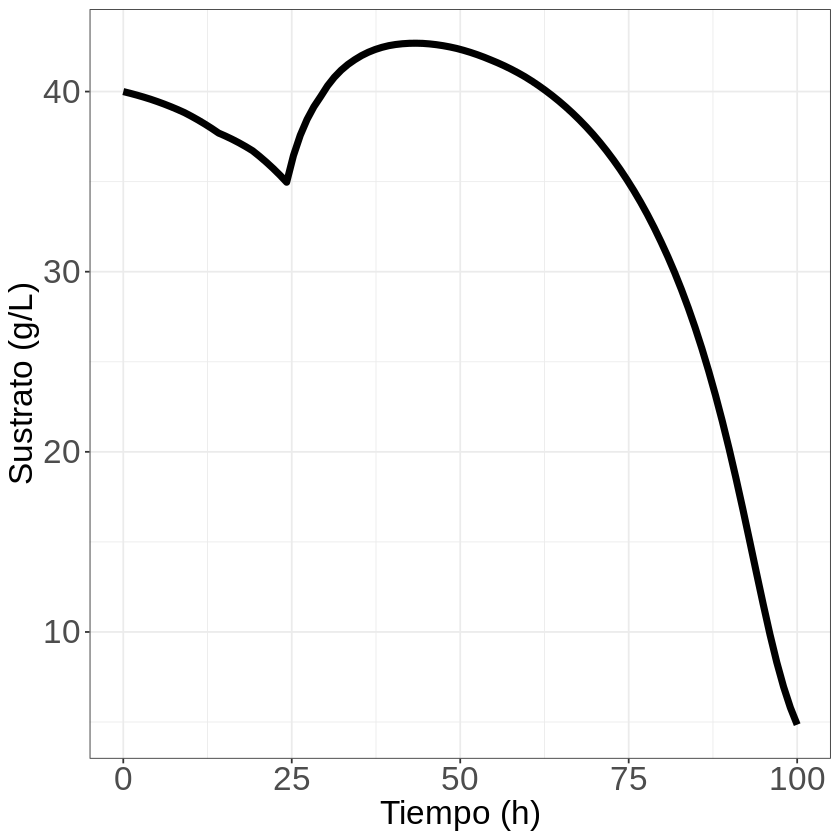

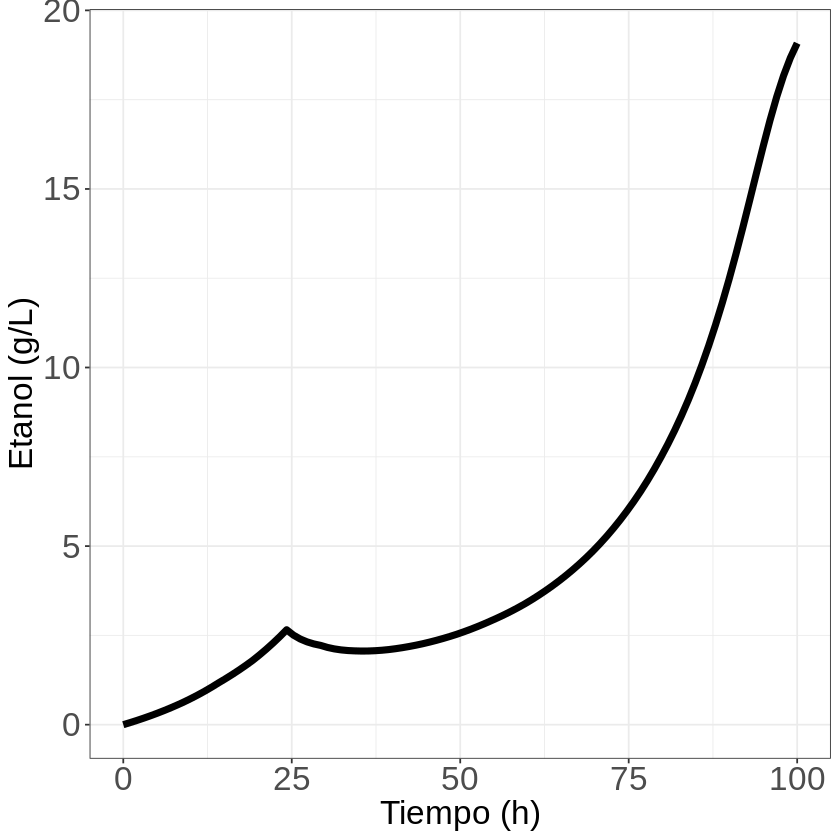

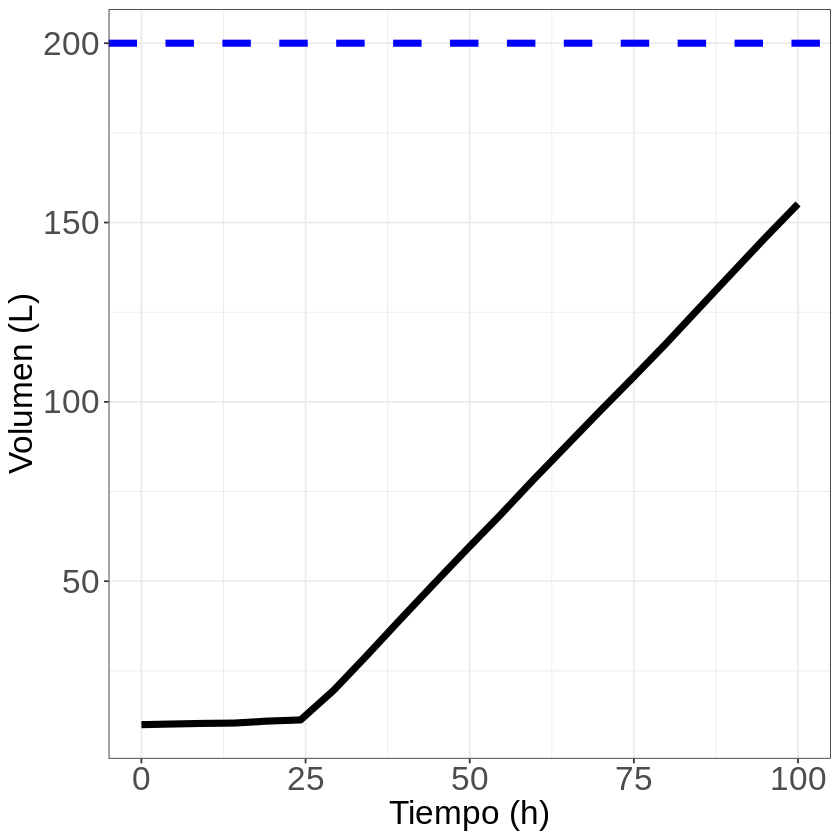

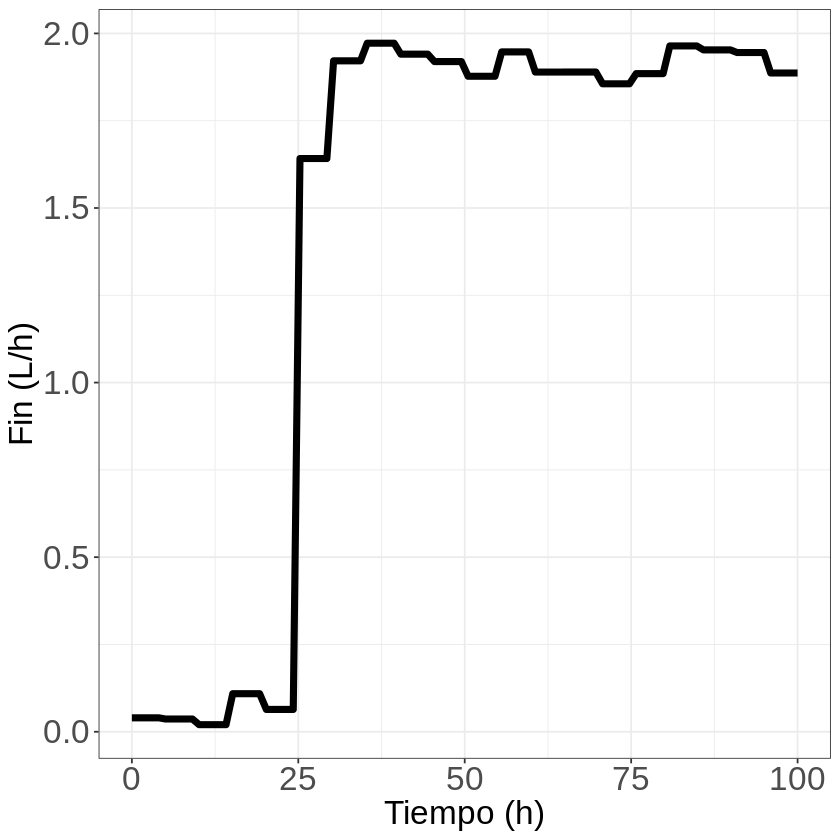

In [49]:
plot_data(out_pk_opt)

### Optimización de perfil Fin para *Zygosaccharomyces bailii*

In [50]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_zb <- get_Fin_opt2(p_zb, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución 40.59466

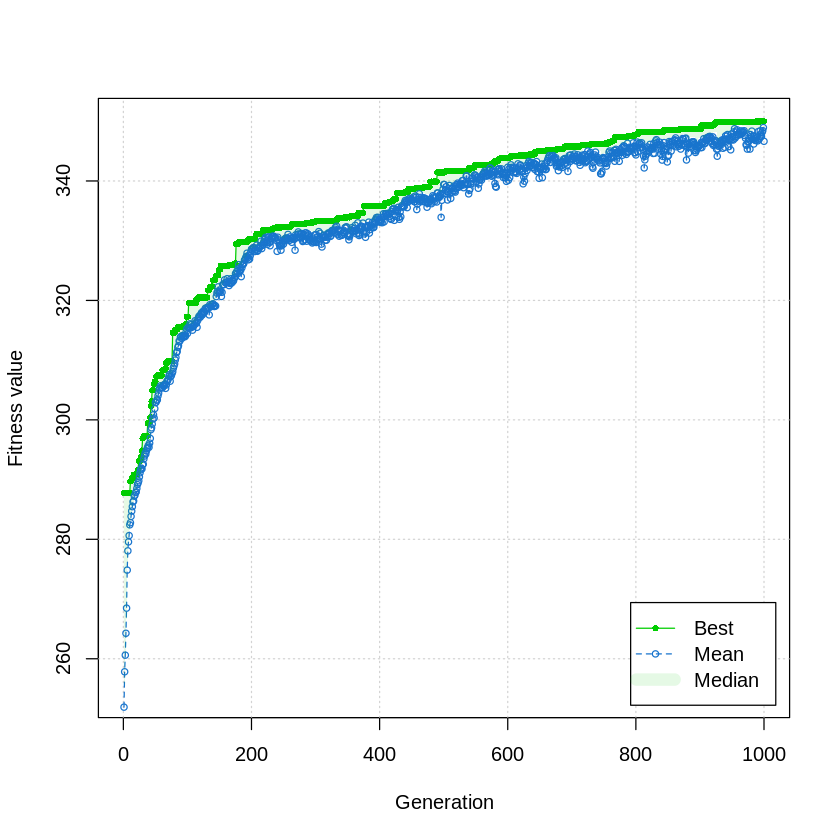

mx_opt: 349.9873 g
mx_opt: 258.3015 g (Fin constante)

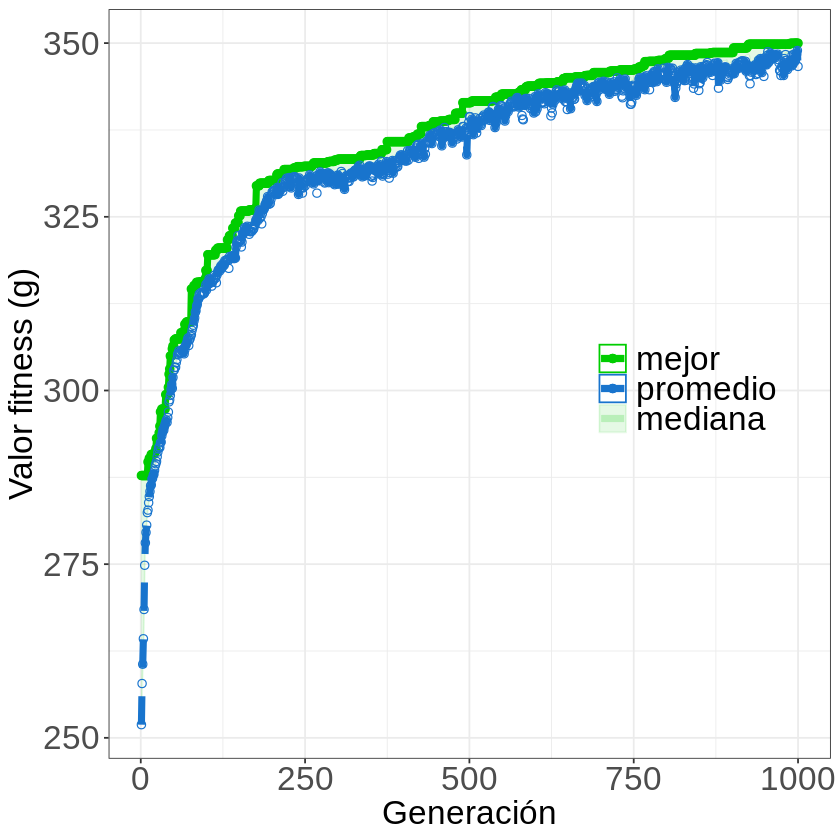

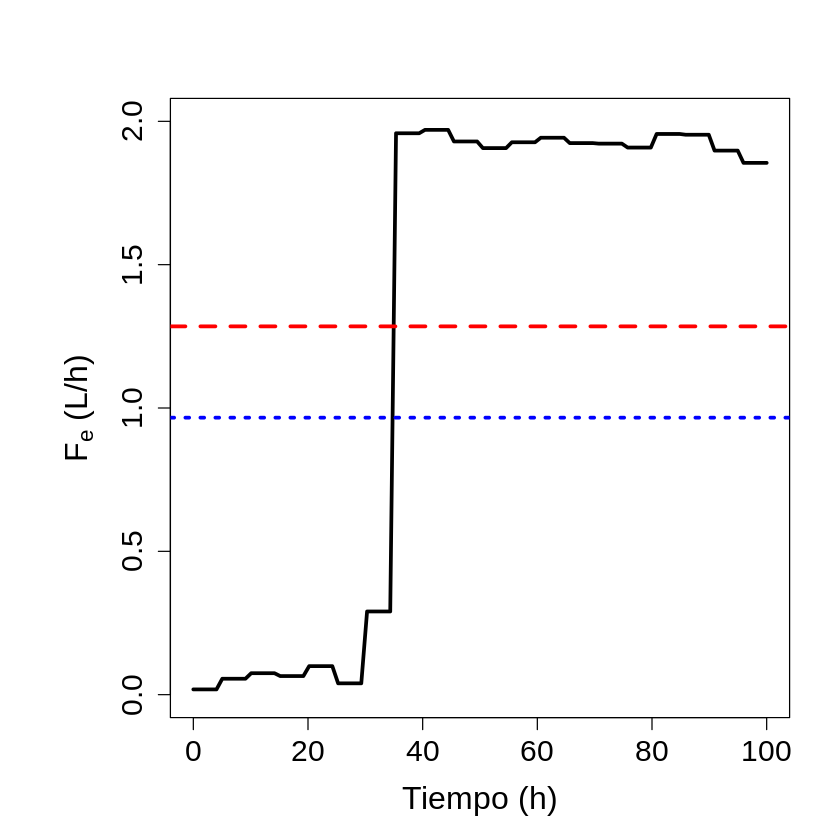

In [244]:
out_zb_opt <- show_results2(GA_zb, GA_zb_const, p_zb)

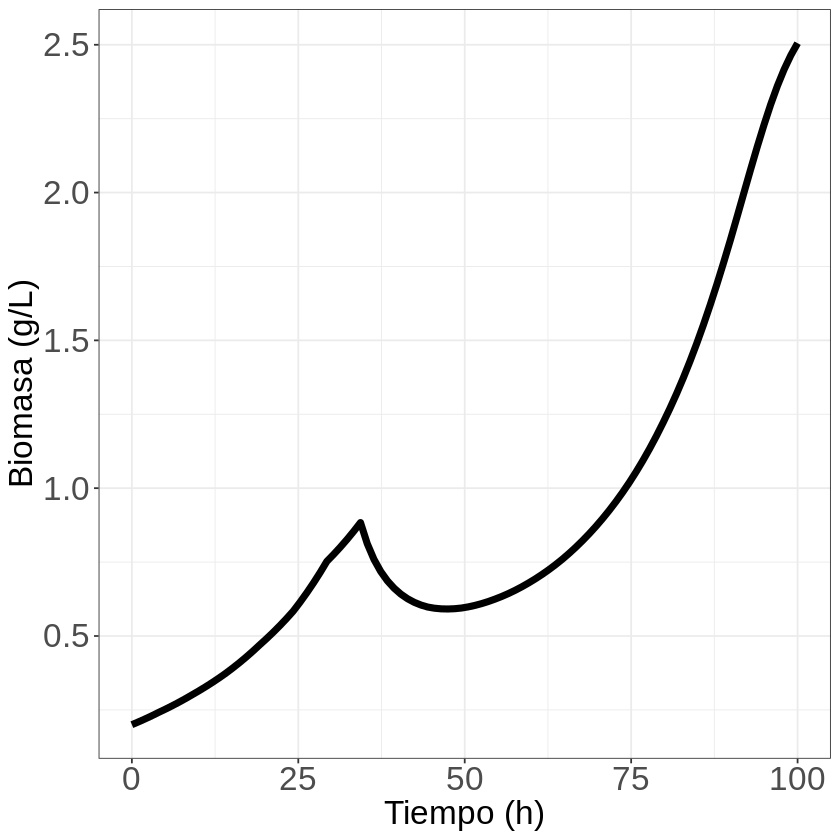

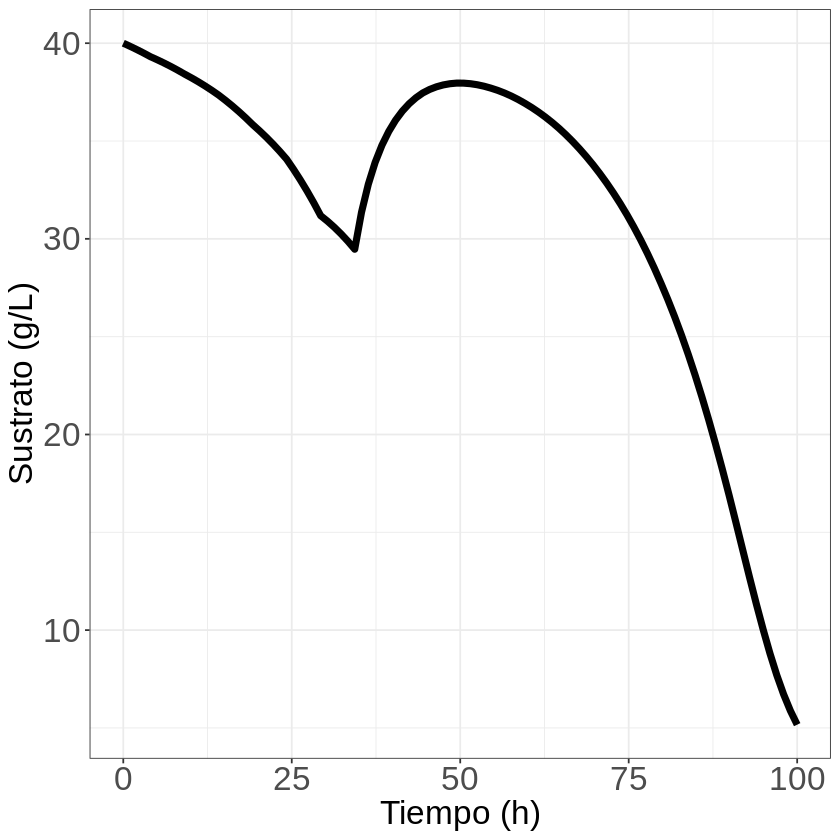

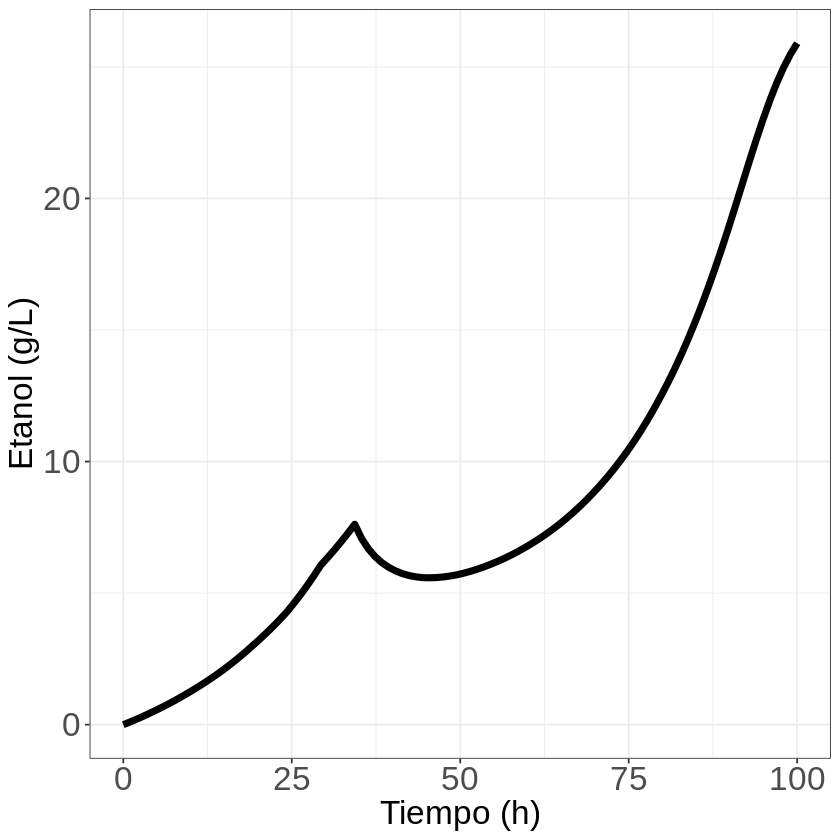

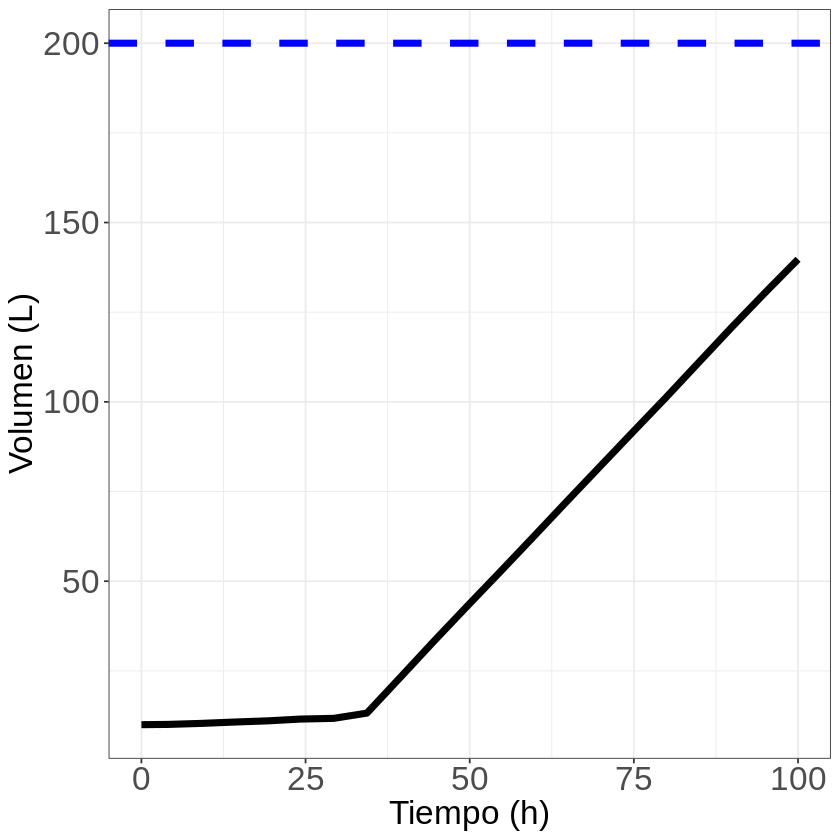

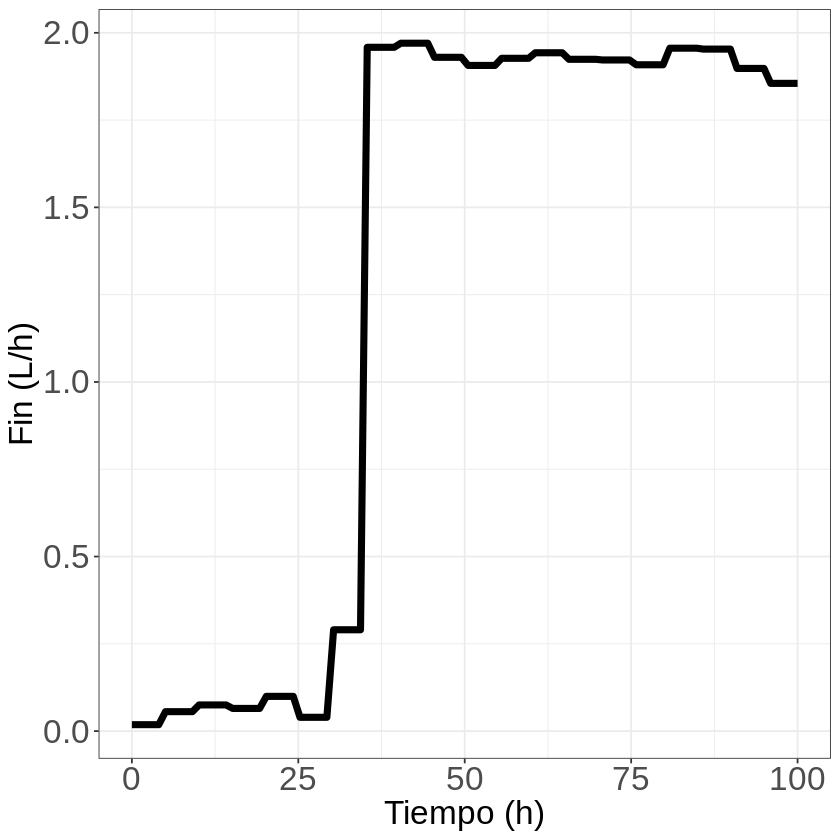

In [52]:
plot_data(out_zb_opt)

### Optimización de Fin para *Zygosaccharomyces rouxi*

In [53]:
# realizar optimización 
set.seed(123)
pop_size_perf <- 50
generation_perf <- 1000
GA_zr <- get_Fin_opt2(p_zr, pop_size = pop_size_perf, generations = generation_perf)

timepo de ejecución 36.44064

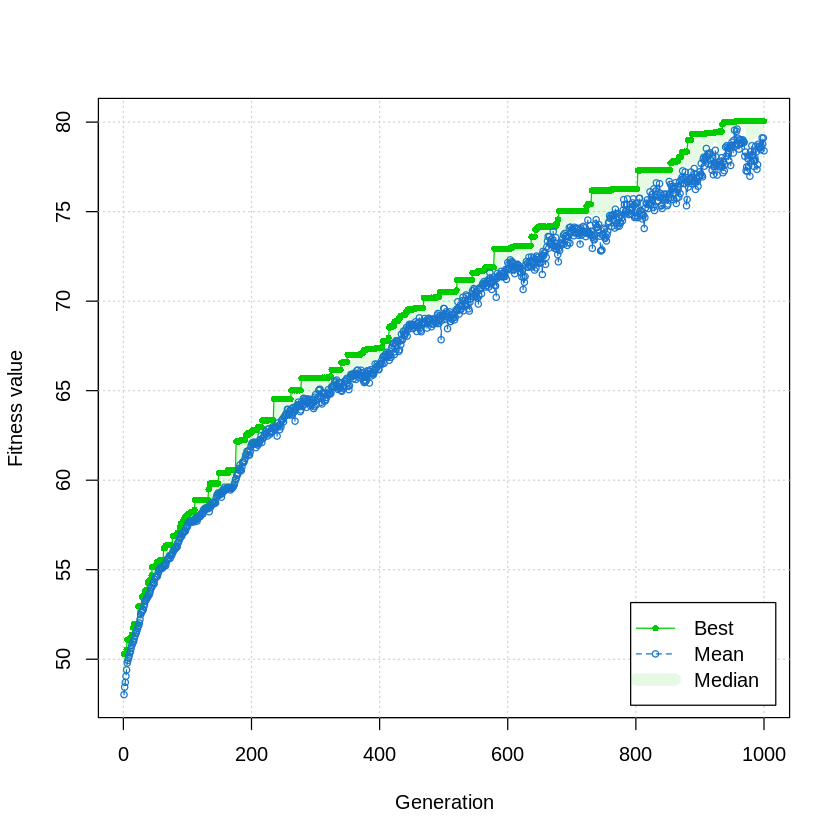

mx_opt: 80.04243 g
mx_opt: 76.02821 g (Fin constante)

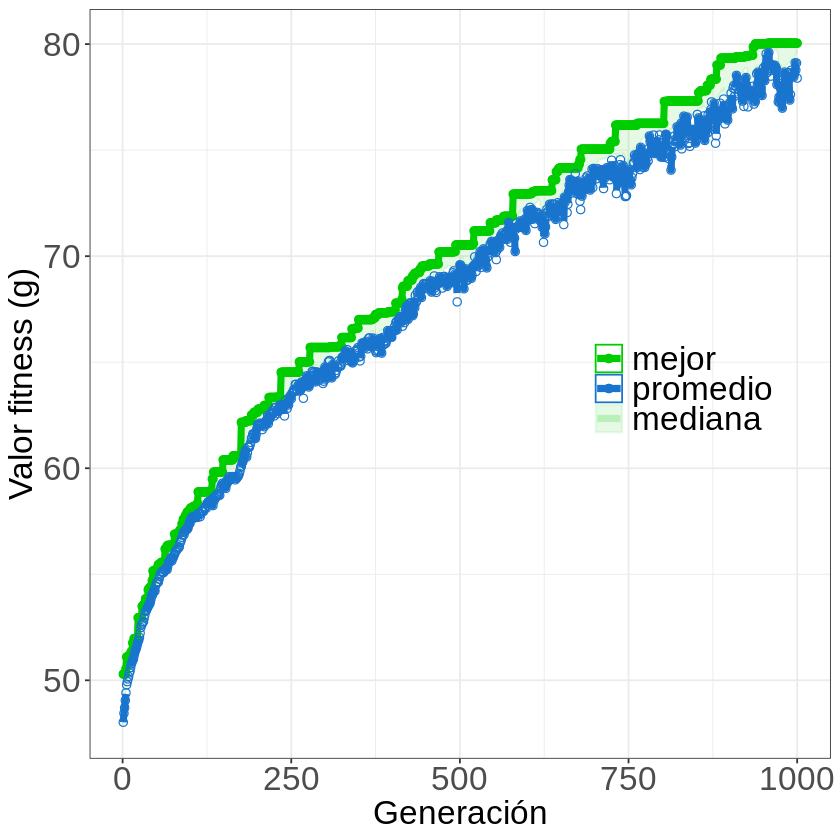

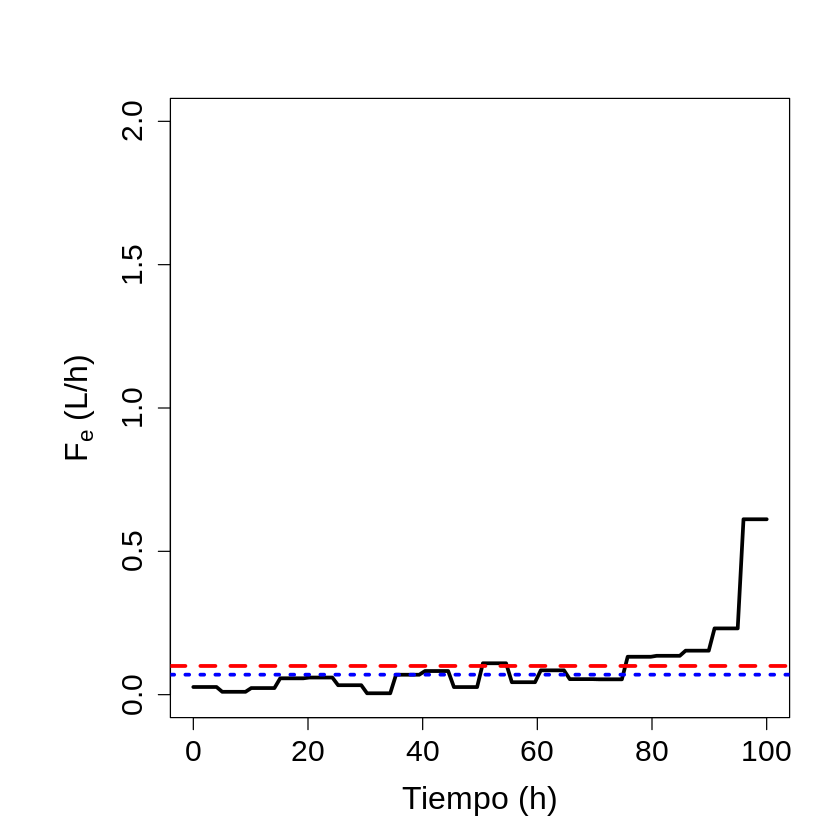

In [245]:
out_zr_opt <- show_results2(GA_zr,GA_zr_const,p_zr)

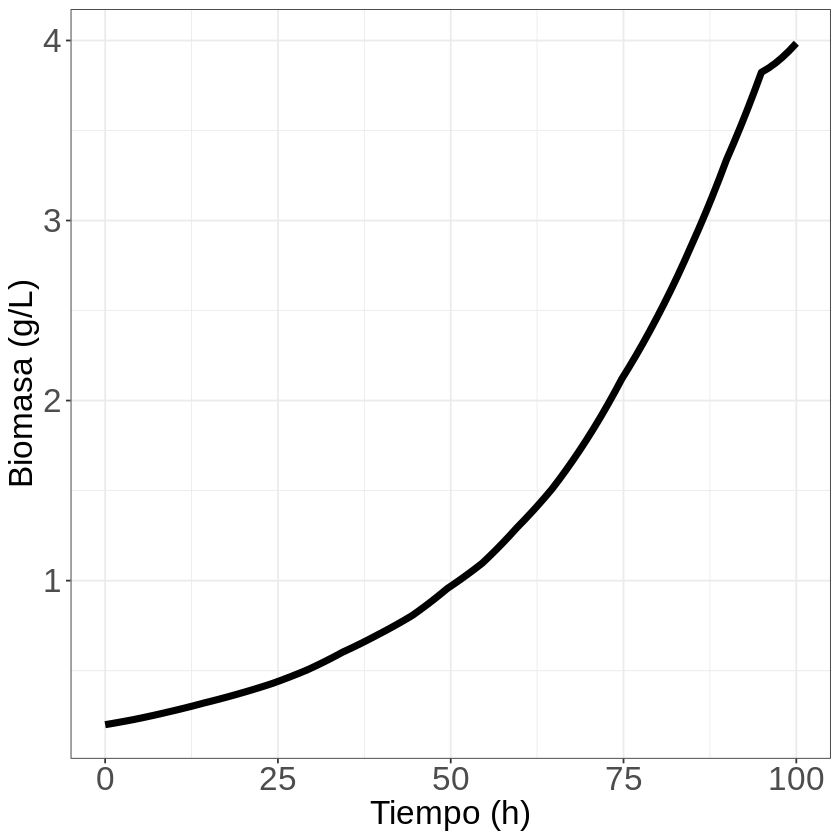

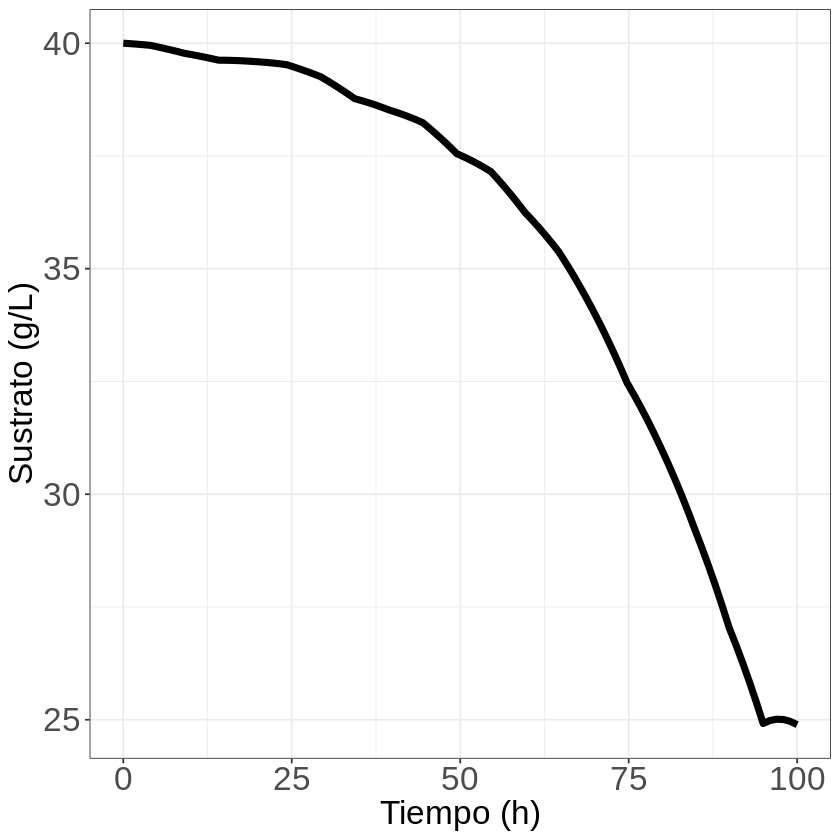

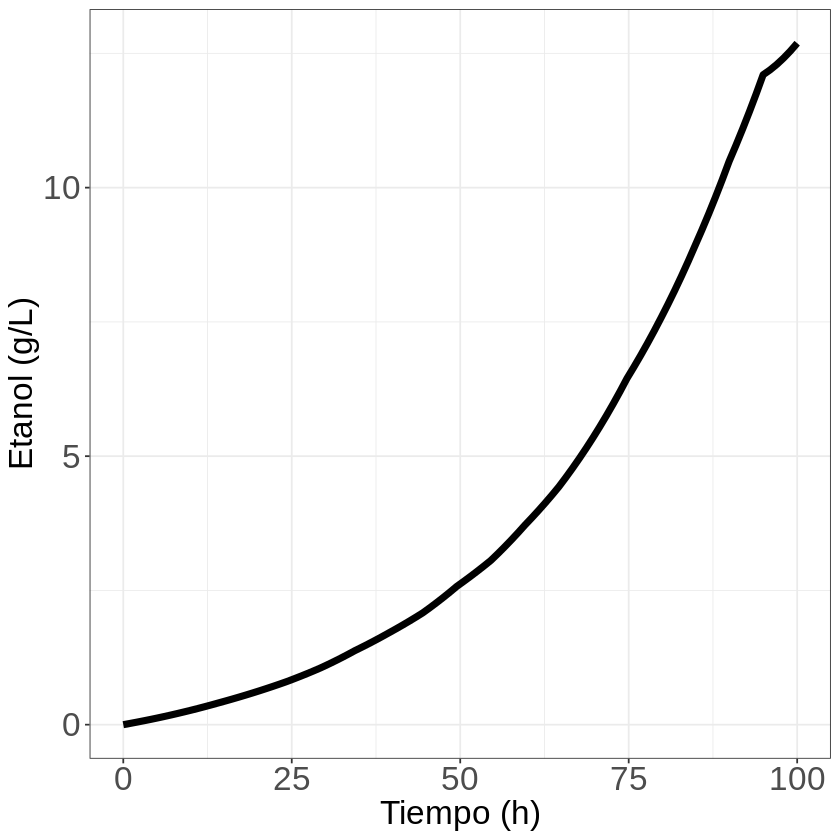

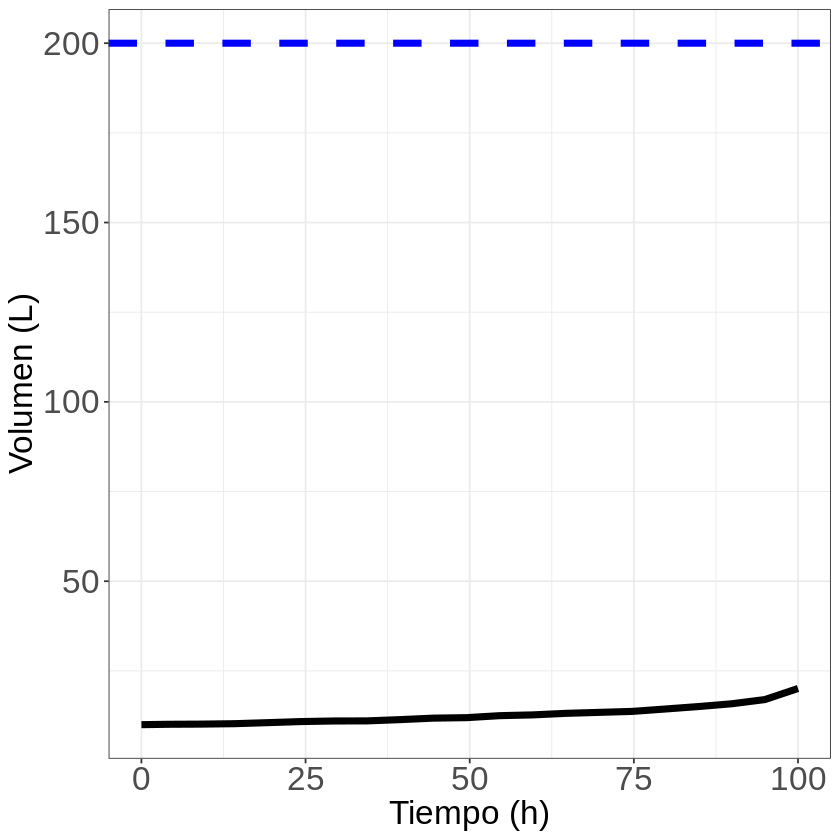

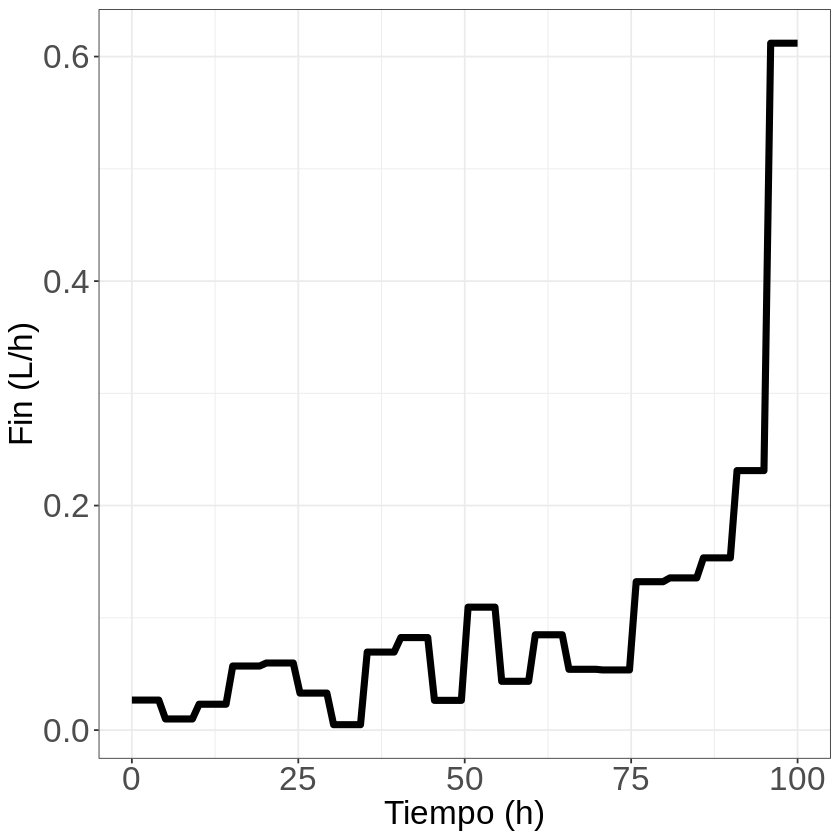

In [55]:
plot_data(out_zr_opt)

# Resultados 

|levadura |	$F_{e}$ constante	|	$F_{e}$ variable	|	$F_{e}$ constant |	$F_{e}$ variable	|
|:---:|:---:|:---:|:---:|:---:|
| |	$F_{e}^{opt}$ 	|	$m_x^{opt}$	|	$F_{e}$ promedio |	$m_x^{opt}$	|
| IT | 1.62926 L/h | 651.711 g | 1.663 L/h | 721.4138 g |
| KM | 1.62926 L/h | 473.2654 g | 1.6469 L/h | 524.8923 g |
| PK | 1.249466 L/h | 476.4802 g | 1.4378 L/h | 588.8083 g |
| ZB | 0.9663 L/h | 258.3015 g | 1.2847 L/h | 349.9873 g |
| ZR | 0.069749 L/h | 76.02821 g | 0.10013 L/h | 80.0424 g |

In [84]:
# @title máxima producción de biomasa generada con Fe constante 
cat("IT: \n")
cat("Fin_opt:", GA_it_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it_const@fitnessValue, "g","\n")
cat("KM: \n")
cat("Fin_opt:", GA_km_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km_const@fitnessValue, "g","\n")
cat("PK: \n")
cat("Fin_opt:", GA_pk_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk_const@fitnessValue, "g","\n")
cat("ZB: \n")
cat("Fin_opt:", GA_zb_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb_const@fitnessValue, "g","\n")
cat("ZR: \n")
cat("Fin_opt:", GA_zr_const@solution," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr_const@fitnessValue, "g","\n")


IT: 
Fin_opt: 1.62926  L/h 
mx_opt: 651.7111 g 
KM: 
Fin_opt: 1.62926  L/h 
mx_opt: 473.2654 g 
PK: 
Fin_opt: 1.249466  L/h 
mx_opt: 476.4802 g 
ZB: 
Fin_opt: 0.9663353  L/h 
mx_opt: 258.3015 g 
ZR: 
Fin_opt: 0.06974961  L/h 
mx_opt: 76.02821 g 


In [87]:
# @title máxima producción de biomasa generada con el perfil Fe 
cat("IT: \n")
cat("Fin_opt_avg:", mean(GA_it@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_it@fitnessValue, "g","\n")
cat("KM: \n")
cat("Fin_opt_avg:", mean(GA_km@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_km@fitnessValue, "g","\n")
cat("PK: \n")
cat("Fin_opt_avg:", mean(GA_pk@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_pk@fitnessValue, "g","\n")
cat("ZB: \n")
cat("Fin_opt_avg:", mean(GA_zb@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zb@fitnessValue, "g","\n")
cat("ZR: \n")
cat("Fin_opt_avg:", mean(GA_zr@solution)," L/h" ,"\n")
# maxima producción de biomasa que se obtiene
cat("mx_opt:", GA_zr@fitnessValue, "g","\n")

IT: 
Fin_opt_avg: 1.663545  L/h 
mx_opt: 721.4138 g 
KM: 
Fin_opt_avg: 1.646966  L/h 
mx_opt: 524.8923 g 
PK: 
Fin_opt_avg: 1.437852  L/h 
mx_opt: 588.8083 g 
ZB: 
Fin_opt_avg: 1.284754  L/h 
mx_opt: 349.9873 g 
ZR: 
Fin_opt_avg: 0.1001383  L/h 
mx_opt: 80.04243 g 


In [311]:
data_Fe <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it_const@fitnessValue,GA_km_const@fitnessValue,GA_pk_const@fitnessValue,GA_zb_const@fitnessValue,GA_zr_const@fitnessValue))

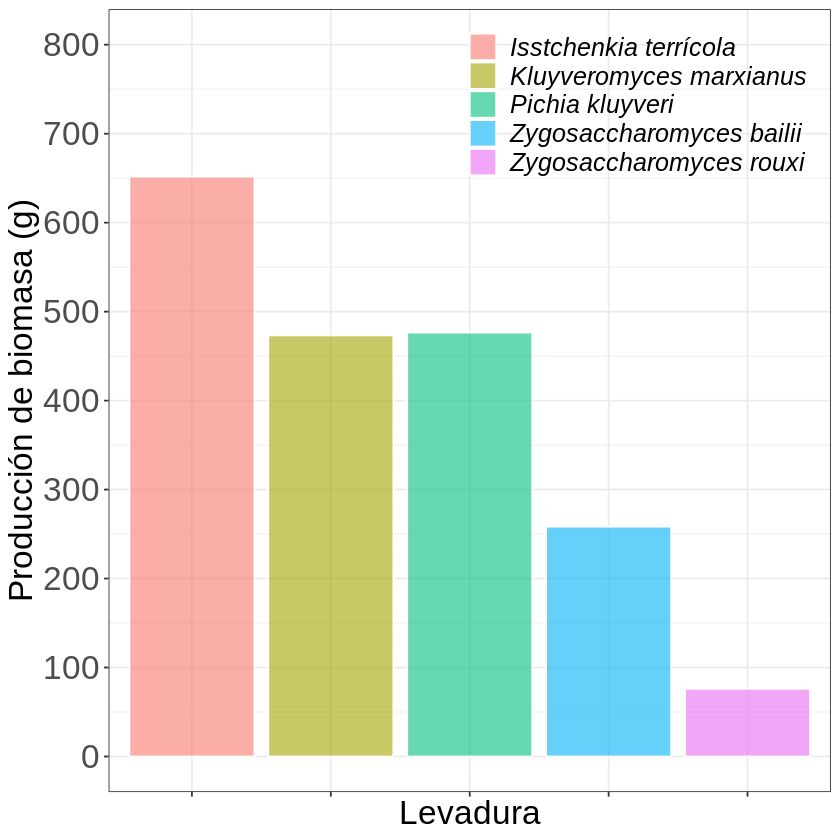

In [312]:
ggplot(data=data_Fe, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Producción de biomasa (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.text.x = element_blank(),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [313]:
data_profil <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(GA_it@fitnessValue, GA_km@fitnessValue, GA_pk@fitnessValue, GA_zb@fitnessValue, GA_zr@fitnessValue))

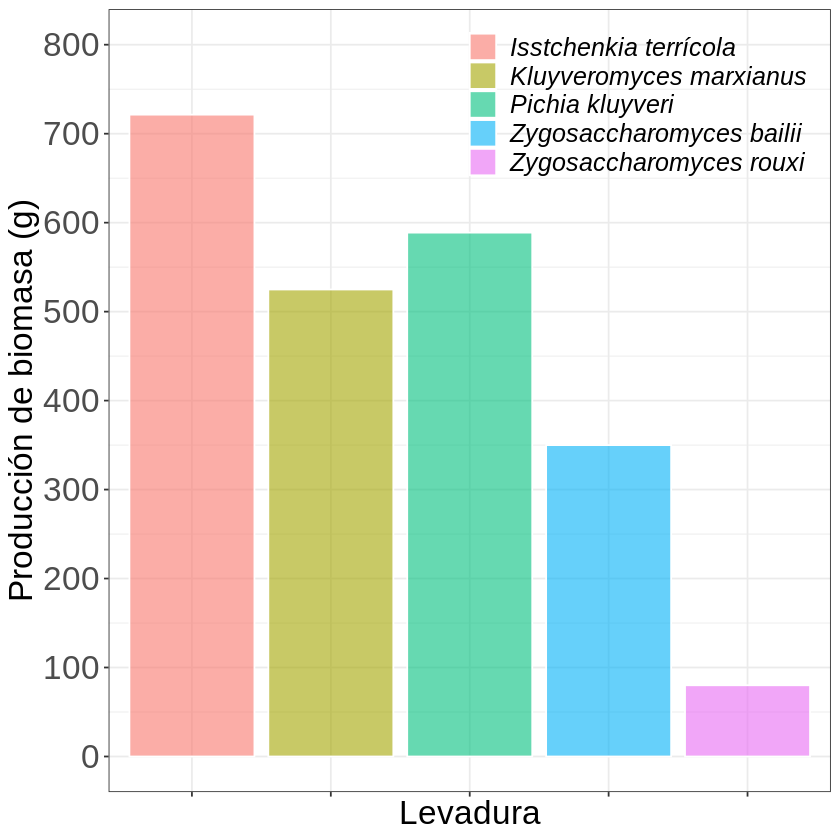

In [314]:
ggplot(data=data_profil, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Producción de biomasa (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

### Comparación de la producción de biomasa con flujo de alimentación constante

In [376]:
data_mx_time_const <- data.frame(times = rep(out_it_opt_const$time,5), mx = c(out_it_opt_const$x*out_it_opt_const$V,out_km_opt_const$x*out_km_opt_const$V,
                                      out_pk_opt_const$x*out_pk_opt_const$V,out_zb_opt_const$x*out_zb_opt_const$V,out_zr_opt_const$x*out_zr_opt_const$V),
                          lev = rep(c("Isstchenkia terrícola","Kluyveromyces marxianus","Pichia kluyveri",
                          "Zygosaccharomyces bailii","Zygosaccharomyces rouxi"), each = length(out_it_opt_const$time)))

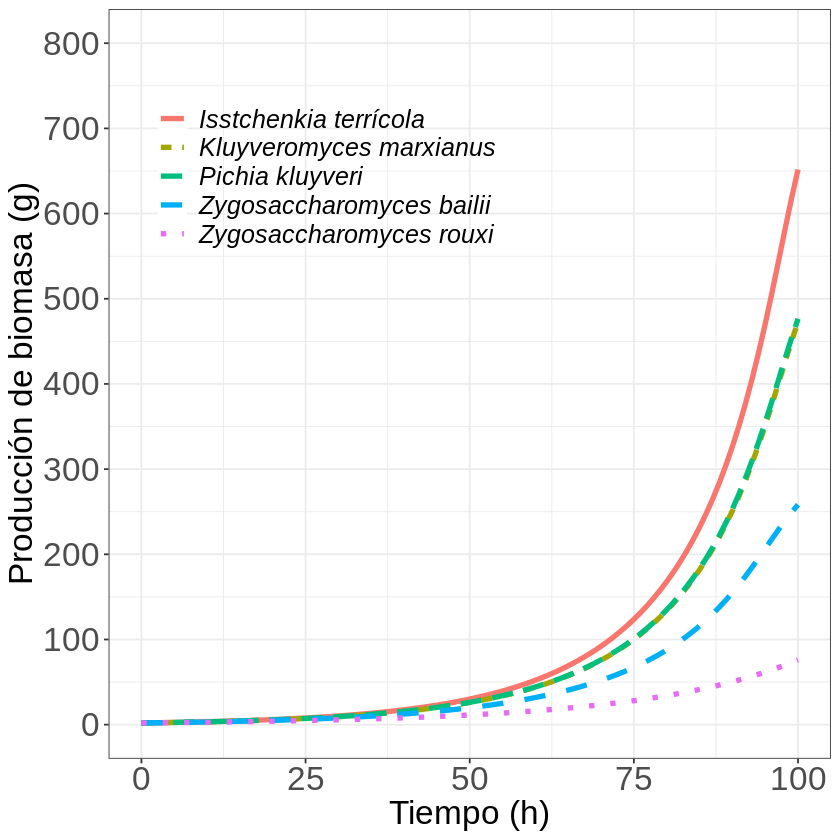

In [383]:
ggplot(data = data_mx_time_const,aes(x = times, y = mx, col = lev, lty = lev))+
    geom_line(lwd = 1.5) +
    ylab("Producción de biomasa (g)") +
    xlab("Tiempo (h)") +
    scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
    theme_bw() +
    theme( 
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.3, 0.80), 
            legend.background = element_rect(fill=NA))+
            labs(col = "") +
            labs(lty = "")


### Comparación en la producción de biomasa durante la fermentación con flujo de alimentación variable

In [384]:
data_mx_time <- data.frame(times = rep(out_it_opt$times,5), mx = c(out_it_opt$x*out_it_opt$V,out_km_opt$x*out_km_opt$V,
                                      out_pk_opt$x*out_pk_opt$V,out_zb_opt$x*out_zb_opt$V,out_zr_opt$x*out_zr_opt$V),
                          lev = rep(c("Isstchenkia terrícola","Kluyveromyces marxianus","Pichia kluyveri",
                          "Zygosaccharomyces bailii","Zygosaccharomyces rouxi"), each = length(out_it_opt$times)))

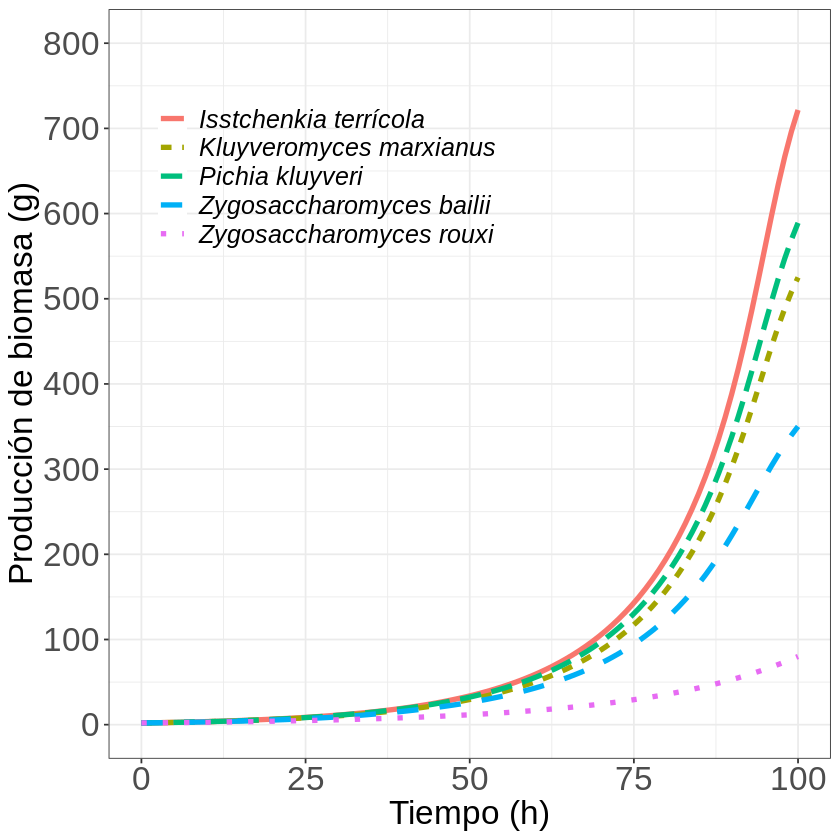

In [385]:
ggplot(data = data_mx_time,aes(x = times, y = mx, col = lev, lty = lev))+
    geom_line(lwd = 1.5) +
    ylab("Producción de biomasa (g)") +
    xlab("Tiempo (h)") +
    scale_y_continuous(limits = c(0, 800), breaks = seq(0, 800, 100)) +
    theme_bw() +
    theme( 
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.3, 0.80), 
            legend.background = element_rect(fill=NA))+
            labs(col = "") +
            labs(lty = "")


### Comparación en el consumo de sustrato durante la fermentación con flujo de alimentación constante

In [398]:
get_substrate <- function(Fe, sf){
    if(length(Fe) > 1) {
        consumed_sub <- sum(Fe*sf*delta_t)
    }
    else {
        consumed_sub <- Fin*sf*tf    
    }
    return(consumed_sub)
}

In [399]:
data_ms_const <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    ms = c(get_substrate(GA_it_const@solution,sf),get_substrate(GA_km_const@solution,sf),get_substrate(GA_pk_const@solution,sf),
                    get_substrate(GA_zb_const@solution,sf),get_substrate(GA_zr_const@solution,sf)))

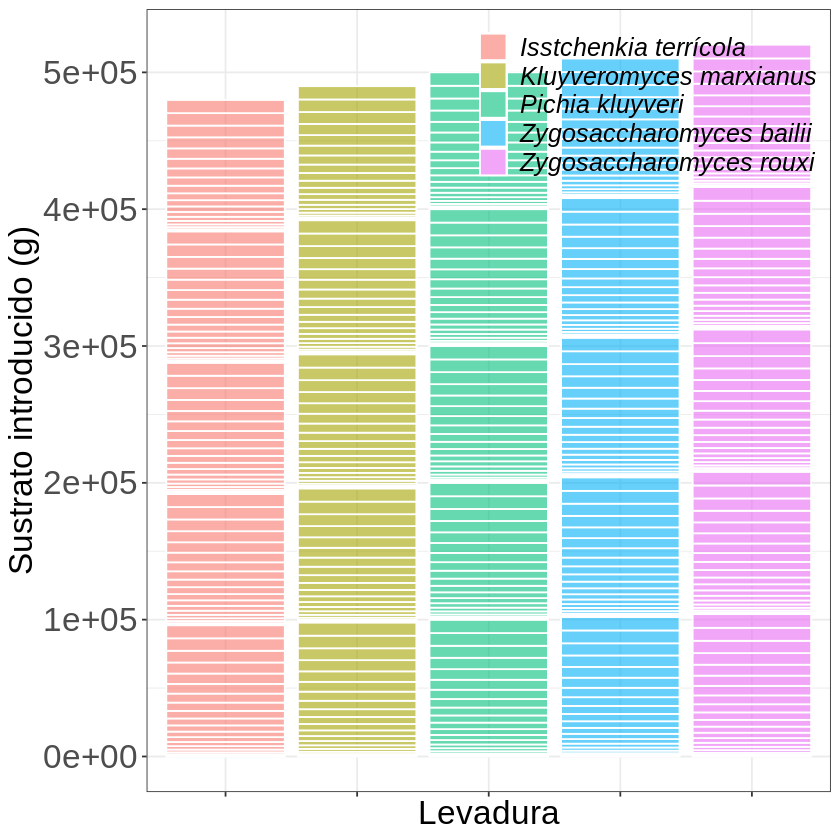

In [401]:
ggplot(data=data_ms_const, aes(x=lev, y=ms, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Sustrato introducido (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  #scale_y_continuous(limits = c(0, 1800), breaks = seq(0, 1800, 200)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

### Comparación en el consumo de sustrato durante la fermentación con flujo de alimentación variable

In [331]:
data_ms <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    ms = c(get_substrate(GA_it@solution,sf),get_substrate(GA_km@solution,sf),get_substrate(GA_pk@solution,sf),
                    get_substrate(GA_zb@solution,sf),get_substrate(GA_zr@solution,sf)))

lev ms       
1 IT  1663.5447
2 KM  1646.9661
3 PK  1437.8518
4 ZB  1284.7543
5 ZR   100.1383

In [402]:
sum(GA_it@solution*sf*delta_t)

x1         x2        x3        x4       x5       x6       x7      
[1,] 0.05159646 0.0541392 0.3636944 1.888003 1.868262 1.836677 1.976068
     x8       x9       x10      x11      x12      x13      x14      x15     
[1,] 1.988135 1.952098 1.950798 1.922545 1.939357 1.937017 1.944469 1.868441
     x16      x17     x18      x19      x20     
[1,] 1.960425 1.97403 1.966998 1.933144 1.894999

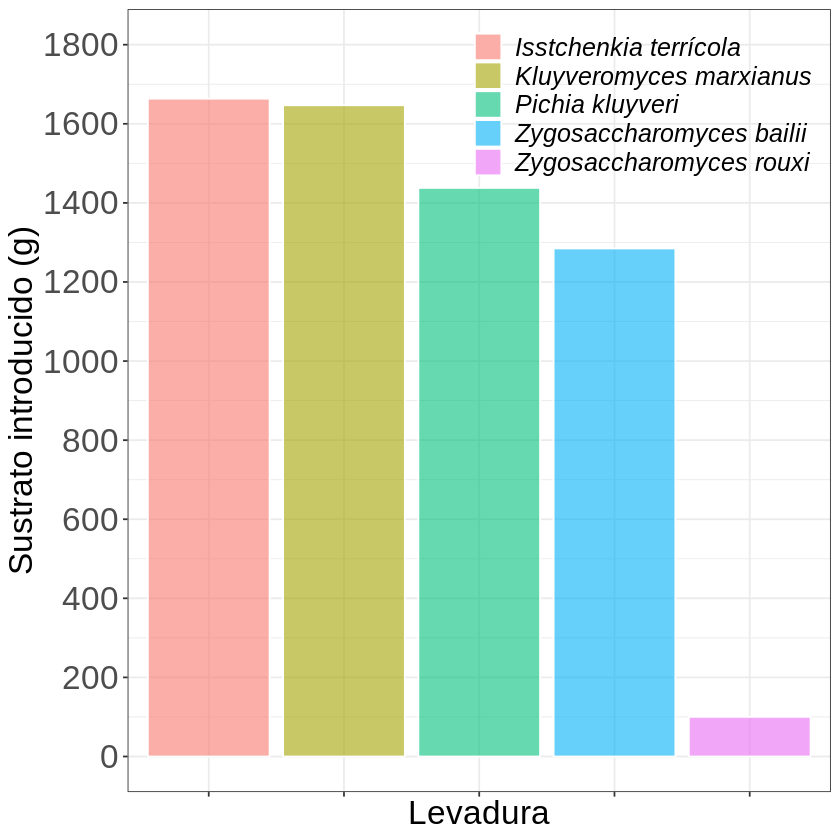

In [338]:
ggplot(data=data_ms, aes(x=lev, y=ms, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Sustrato introducido (g)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_y_continuous(limits = c(0, 1800), breaks = seq(0, 1800, 200)) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x = element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            